# Предсказание возвращения клиента:

В распоряжении информация по трем интернет-магазинам: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков.
В них есть обезличенная история покупок клиентов за определенный период.

**Цель:**
Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней.

**Исходные данные**

- marketplace - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц;
- apparel - магазин одежды, по характеристикам похожий на маркетплейс;
- gifts – магазин подарков (очень маленький);
- client_id – идентификатор клиента;
- quantity – количество товара в заказе;
- price – цена 1 единицы товара в заказе;
- message_id – идентификатор сообщения из рассылки;
- date – дата покупки;

### Содержание

* [Загрузка и предобработка данных](#chapter1)
    * [Таблица Apparel - магазин одежды](#section_1_1)
    * [Таблица Marketplace - мультикатегорийный магазин](#section_1_2)
    * [Таблица Gifts – магазин подарков](#section_1_3)
        * [Заключение по предварительному анализу](#section_1_2_1)
* [Подготовка выборок](#chapter2)
* [Загрузка и предобработка данных](#chapter3)
    * [CatBoost, общая выборка](#section_3_2)
    * [CatBoost, Apparel](#section_3_4)
    * [CatBoost, Marketplace](#section_3_6)
    * [CatBoost, Gifts](#section_3_8)
* [Тестирование модели](#chapter4)

## Загрузка и подготовка данных <a class="anchor" id="chapter1"></a>

Изучим данные в 3 таблицах

In [146]:
# !pip install sweetviz
#!pip install dabl --user

In [147]:
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import warnings
import sweetviz as sv
import dabl
import phik
import datetime as dt
import sklearn
from catboost import Pool
from sklearn.ensemble import RandomForestClassifier
from catboost.utils import get_roc_curve
from phik.report import plot_correlation_matrix
from datetime import date
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

In [148]:
warnings.filterwarnings('ignore')
sns.set()
sns.set_style("whitegrid")

In [531]:
df_a = pd.read_csv('apparel-purchases.csv')
df_g = pd.read_csv('gifts-purchases.csv')
df_m = pd.read_csv('marketplace-purchases.csv')

### Таблица Apparel - магазин одежды <a class="anchor" id="section_1_1"></a>

Начнем исследование данных с магазина Apparel

In [150]:
df_a.head(15)

client_id  quantity   price        date  \
0   1515915625468068833         1  3499.0  2023-09-08   
1   1515915625468068833         1  3499.0  2023-09-08   
2   1515915625468068833         1  3499.0  2023-09-08   
3   1515915625468068833         1  2450.0  2023-09-08   
4   1515915625468068833         1  2450.0  2023-09-08   
5   1515915625468068833         1  2450.0  2023-09-08   
6   1515915625468079941         1   999.0  2023-09-01   
7   1515915625468079941         1   712.0  2023-09-01   
8   1515915625468079941         1  1499.0  2023-09-01   
9   1515915625468079941         1  1068.0  2023-09-01   
10  1515915625468079941         1  1499.0  2023-09-01   
11  1515915625468079941         1  1068.0  2023-09-01   
12  1515915625468079941         1   799.0  2023-09-01   
13  1515915625468079941         1   759.0  2023-09-01   
14  1515915625468091813         1   174.0  2023-09-26   

                                 message_id recommended_by  
0   1515915625468068833-13781-64fad81bece56   bulk_message  
1   1515915625468068833-13781-64fad81bece56   bulk_message  
2   1515915625468068833-13781-64fad81bece56   bulk_message  
3   1515915625468068833-13781-64fad81bece56   bulk_message  
4   1515915625468068833-13781-64fad81bece56   bulk_message  
5   1515915625468068833-13781-64fad81bece56   bulk_message  
6   1515915625468079941-13718-64e899a67a51d   bulk_message  
7   1515915625468079941-13718-64e899a67a51d   bulk_message  
8   1515915625468079941-13718-64e899a67a51d   bulk_message  
9   1515915625468079941-13718-64e899a67a51d   bulk_message  
10  1515915625468079941-13718-64e899a67a51d   bulk_message  
11  1515915625468079941-13718-64e899a67a51d   bulk_message  
12  1515915625468079941-13718-64e899a67a51d   bulk_message  
13  1515915625468079941-13718-64e899a67a51d   bulk_message  
14  1515915625468091813-13864-651141a531bb2   bulk_message

In [151]:
print(df_a.info())
print('Количество дубликатов -', df_a.duplicated().sum())
print('Количество пропусков - \n', df_a.isna().sum(),sep='')
df_a.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       133104 non-null  int64  
 1   quantity        133104 non-null  int64  
 2   price           133104 non-null  float64
 3   date            133104 non-null  object 
 4   message_id      133104 non-null  object 
 5   recommended_by  133104 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB
None
Количество дубликатов - 59250
Количество пропусков - 
client_id         0
quantity          0
price             0
date              0
message_id        0
recommended_by    0
dtype: int64


client_id       quantity          price
count  1.331040e+05  133104.000000  133104.000000
mean   1.515916e+18       1.004312    1110.433067
std    1.422078e+08       0.149315    1257.080854
min    1.515916e+18       1.000000       1.000000
25%    1.515916e+18       1.000000     280.000000
50%    1.515916e+18       1.000000     799.000000
75%    1.515916e+18       1.000000    1499.000000
max    1.515916e+18      30.000000   63499.000000

Таблица не содержит пропусков. В данных большое количество дубликатов, 59250 из 133104 (45%). Решено, рассматривать их как разные позиции в чеке, поэтому найдем общее количество за день и удалим дубликаты.

**Категоризируем товары по цене:**
- Категория **A** < 100 рублей
- Категория A < **B** < 500 рублей
- Категория B < **C** < 1000 рублей
- Категория C < **D** < 5000 рублей
- Категория D < **E** < 10.000 рублей
- Категория E < **F** 

In [152]:
def product_category(x):
    if x < 100:
        return "A"
    if x < 500:
        return "B"
    if x < 1000:
        return "C"
    if x < 5000:
        return "D"
    if x < 10000:
        return "E"
    else:
        return "F"

In [532]:
df_a['product_category'] = df_a['price'].apply(product_category)

In [533]:
df_a['total_sum'] = df_a.groupby(['client_id', 'price', 'date', 'message_id',
       'recommended_by'])['quantity'].transform('sum')
df_a.head()

client_id  quantity   price        date  \
0  1515915625468068833         1  3499.0  2023-09-08   
1  1515915625468068833         1  3499.0  2023-09-08   
2  1515915625468068833         1  3499.0  2023-09-08   
3  1515915625468068833         1  2450.0  2023-09-08   
4  1515915625468068833         1  2450.0  2023-09-08   

                                message_id recommended_by product_category  \
0  1515915625468068833-13781-64fad81bece56   bulk_message                D   
1  1515915625468068833-13781-64fad81bece56   bulk_message                D   
2  1515915625468068833-13781-64fad81bece56   bulk_message                D   
3  1515915625468068833-13781-64fad81bece56   bulk_message                D   
4  1515915625468068833-13781-64fad81bece56   bulk_message                D   

   total_sum  
0          3  
1          3  
2          3  
3          3  
4          3

Мы нашли общее количество покупок за день. Теперь удалим дубликаты.

In [534]:
df_a.drop_duplicates(inplace=True)
df_a.reset_index(drop=True,inplace=True)

In [535]:
df_a.head()

client_id  quantity   price        date  \
0  1515915625468068833         1  3499.0  2023-09-08   
1  1515915625468068833         1  2450.0  2023-09-08   
2  1515915625468079941         1   999.0  2023-09-01   
3  1515915625468079941         1   712.0  2023-09-01   
4  1515915625468079941         1  1499.0  2023-09-01   

                                message_id recommended_by product_category  \
0  1515915625468068833-13781-64fad81bece56   bulk_message                D   
1  1515915625468068833-13781-64fad81bece56   bulk_message                D   
2  1515915625468079941-13718-64e899a67a51d   bulk_message                C   
3  1515915625468079941-13718-64e899a67a51d   bulk_message                C   
4  1515915625468079941-13718-64e899a67a51d   bulk_message                D   

   total_sum  
0          3  
1          3  
2          1  
3          1  
4          2

Также добавим количество уникальных позиций за день. Критерием уникальности будет цена.

In [536]:
df_a['unique_count'] = df_a.groupby(['client_id', 'date'])['price'].transform('nunique')

Построим автоматический анализ

                                             |          | [  0%]   00:00 -> (? left)


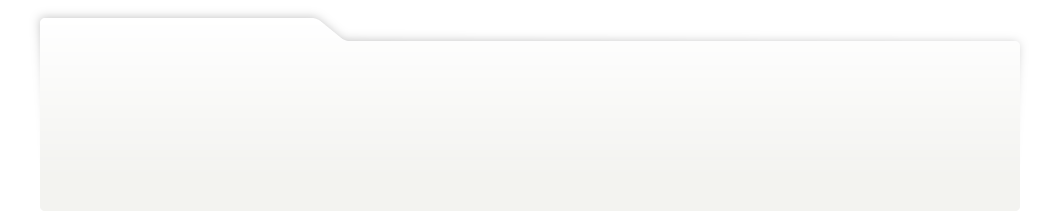
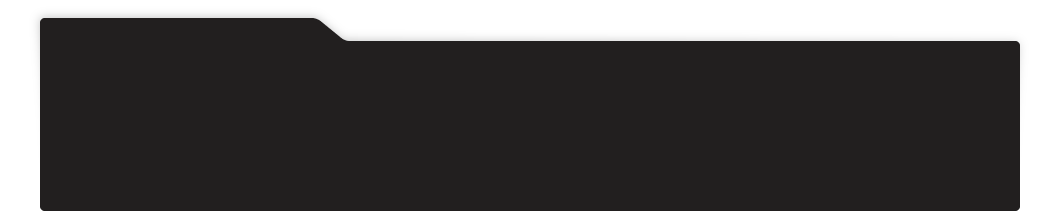
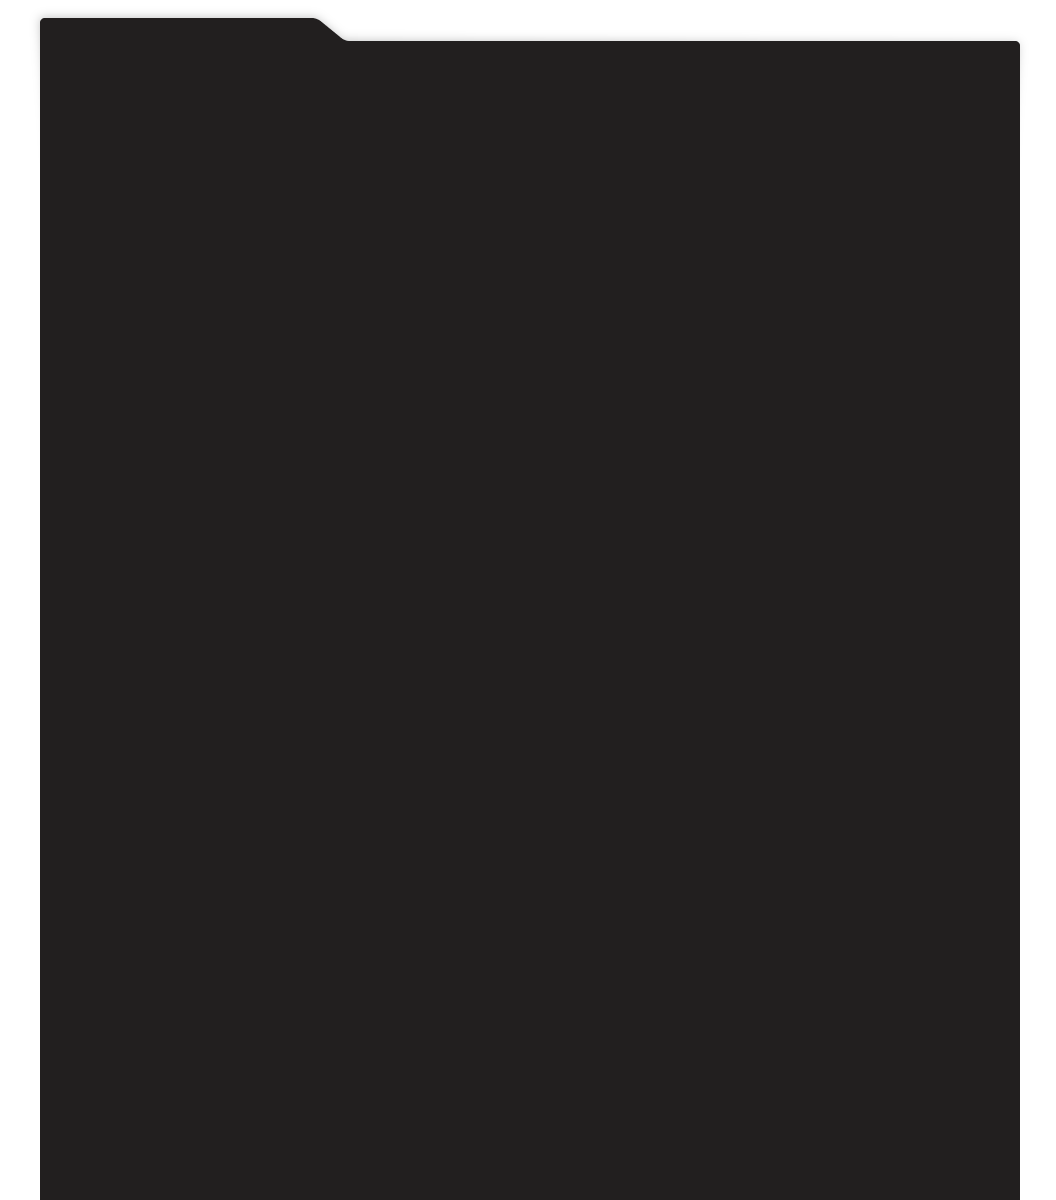
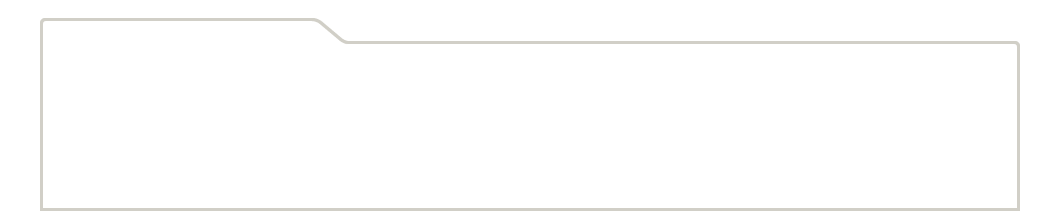
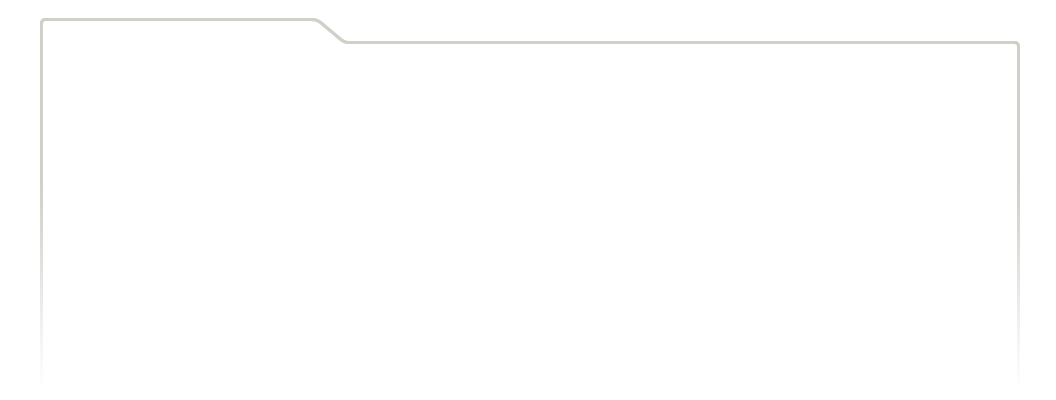
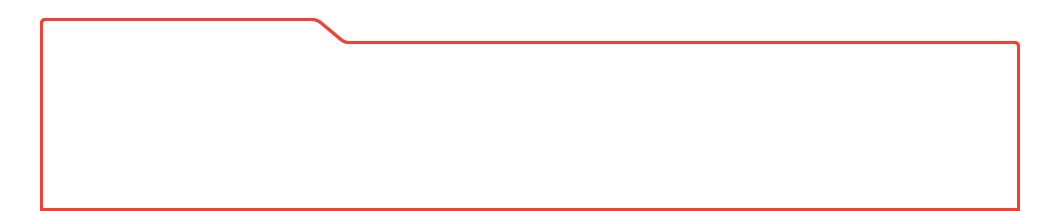
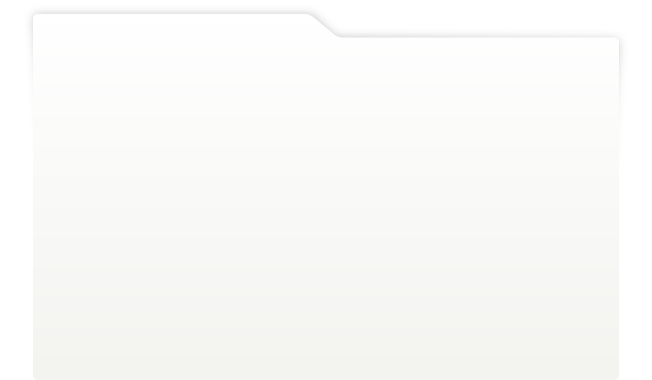
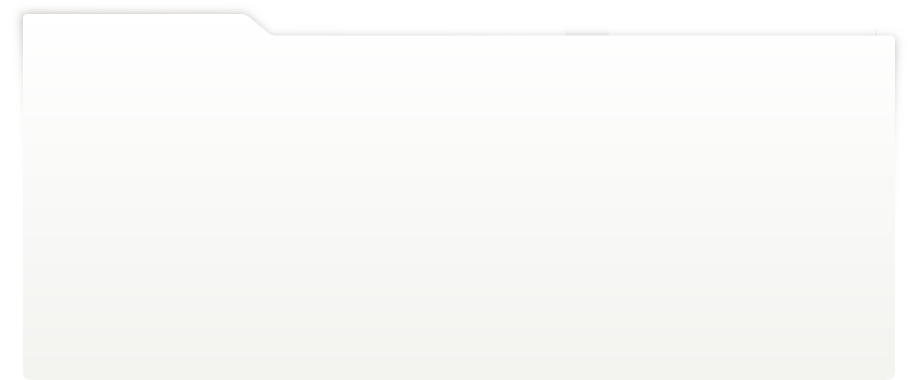
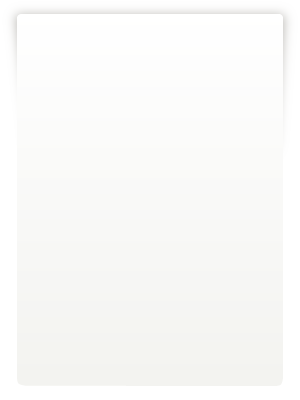
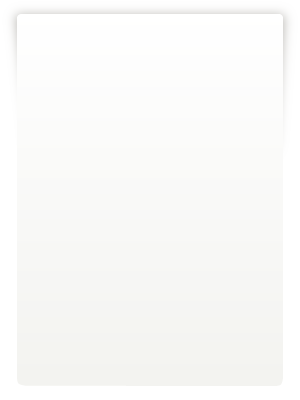
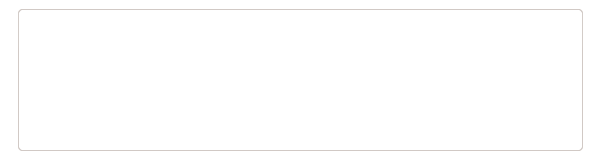
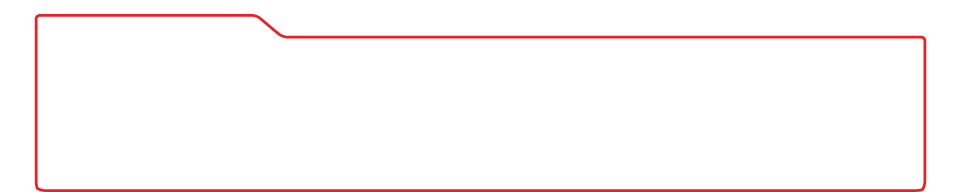
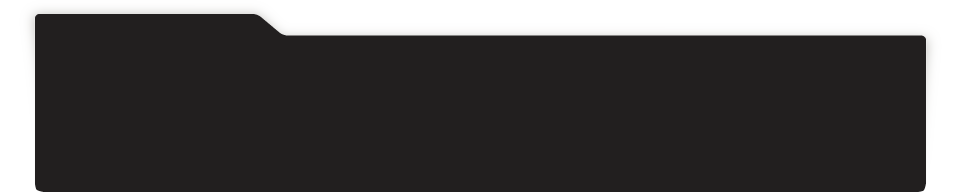
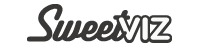
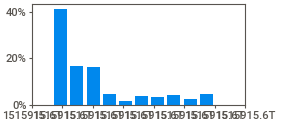
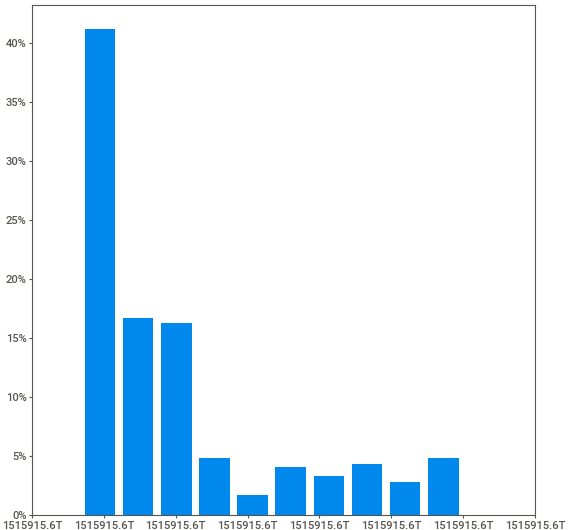
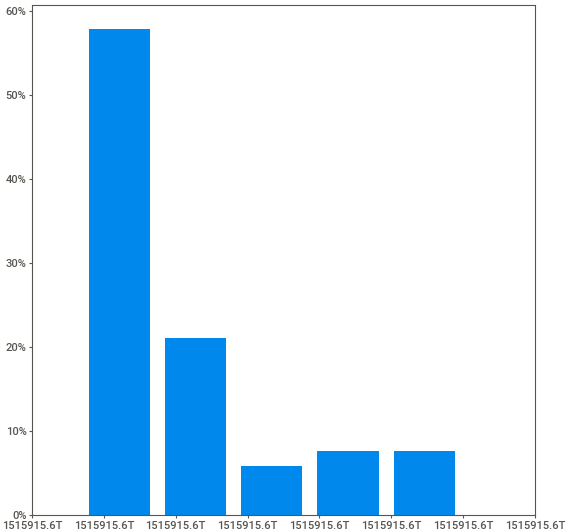
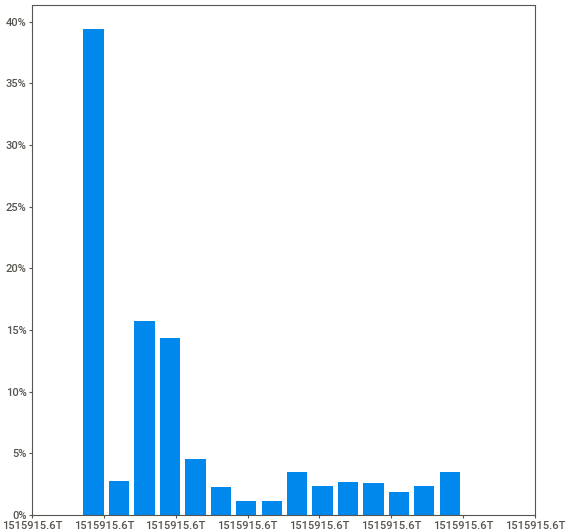
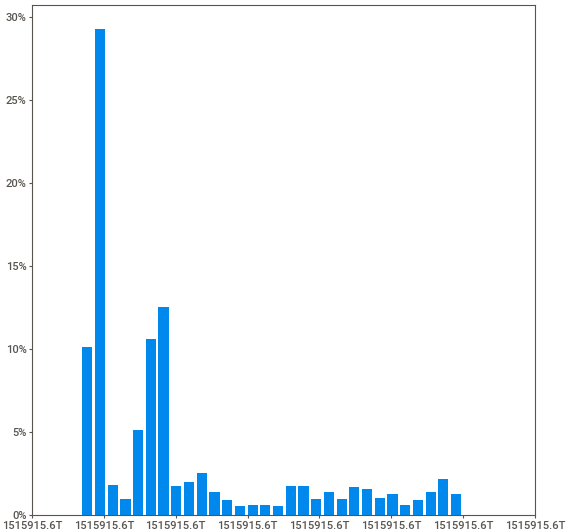
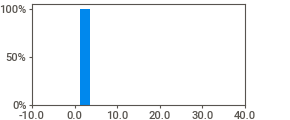
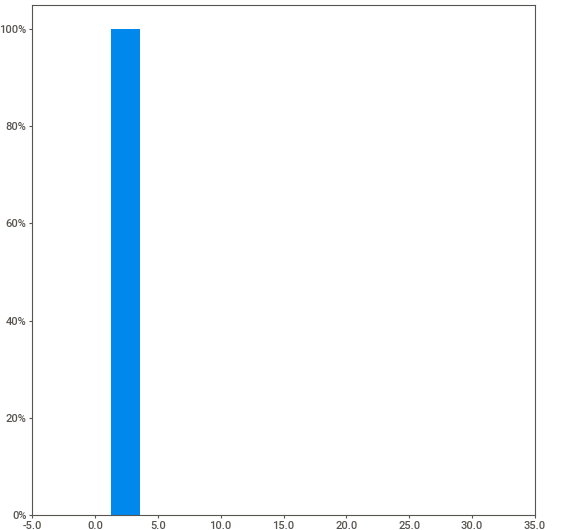
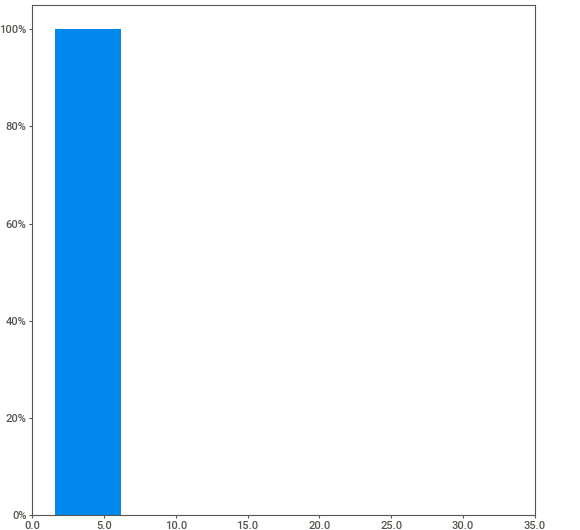
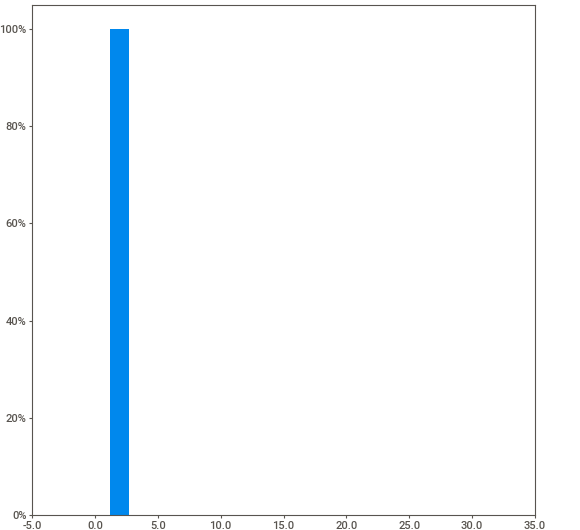
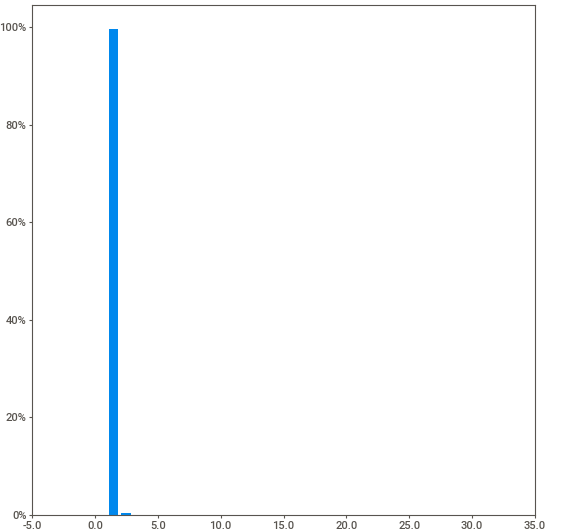
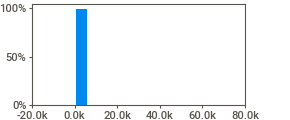
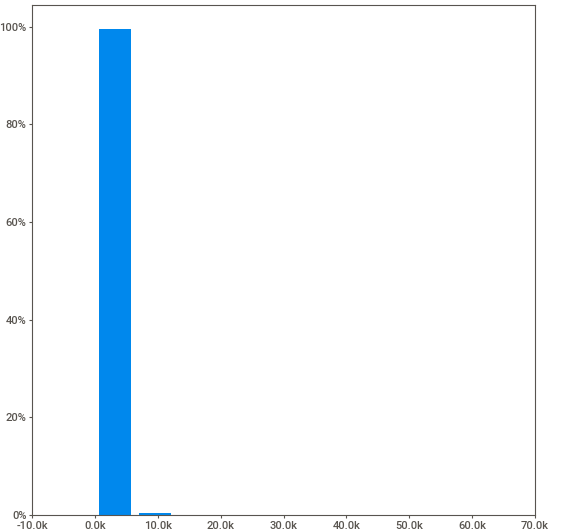
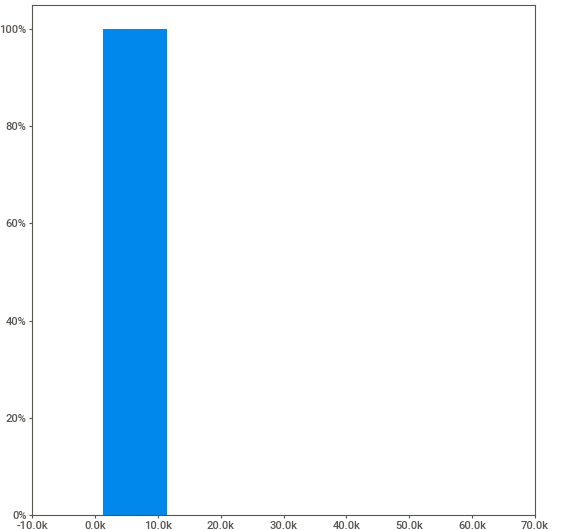
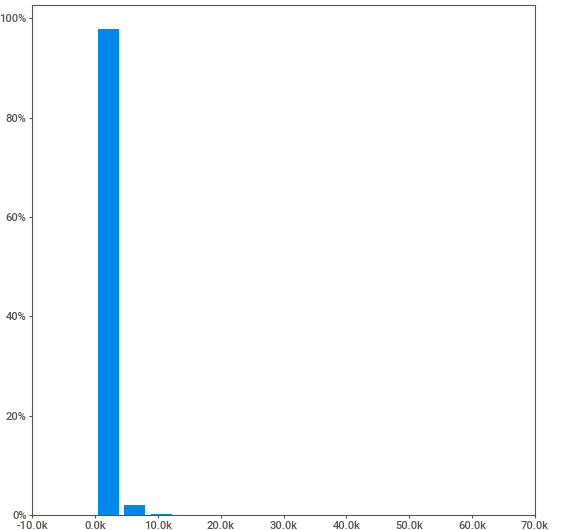
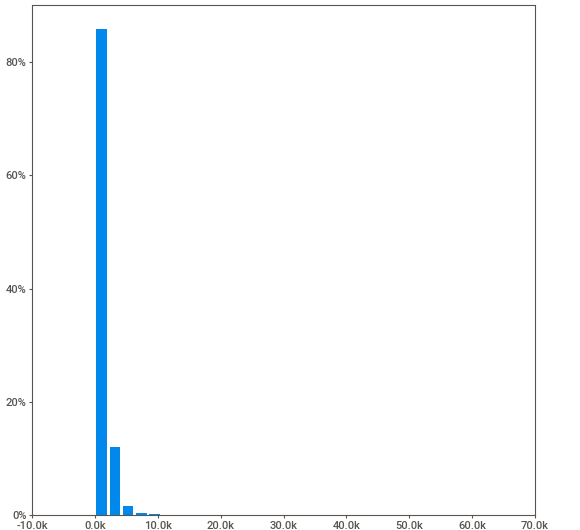
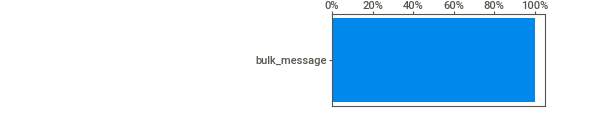
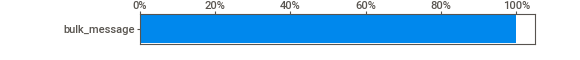
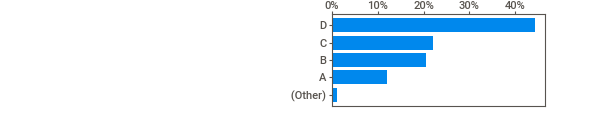
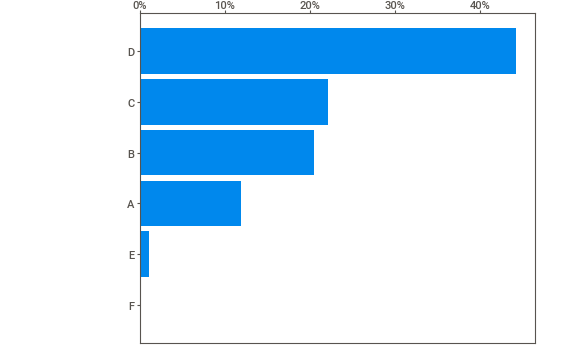
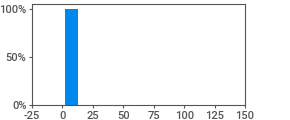
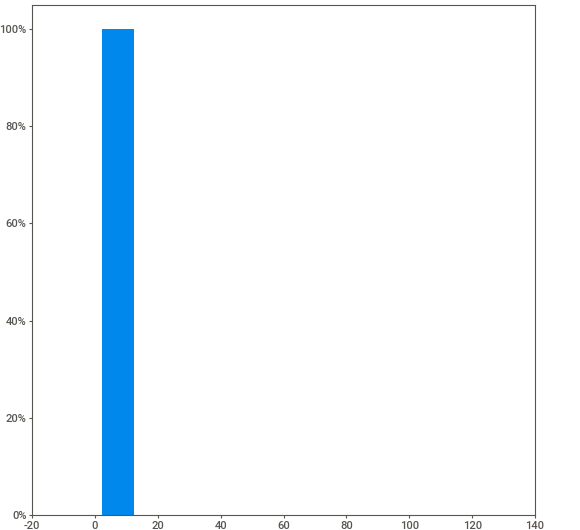
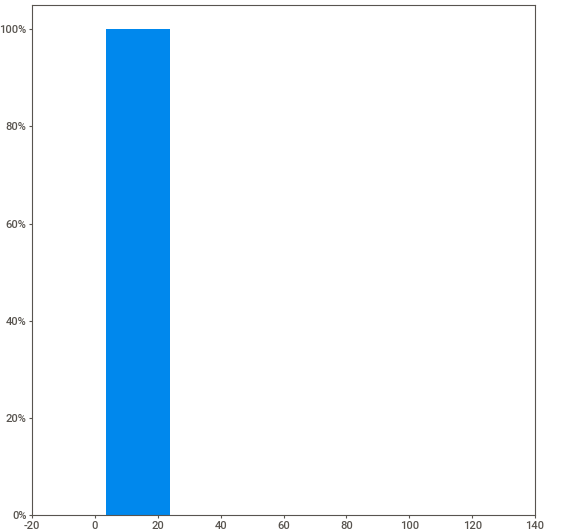
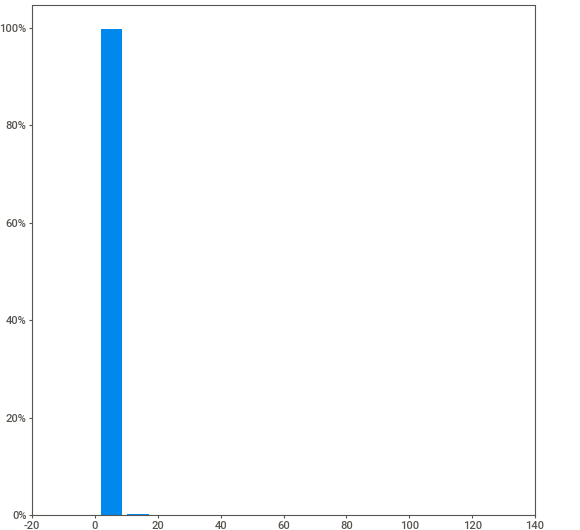
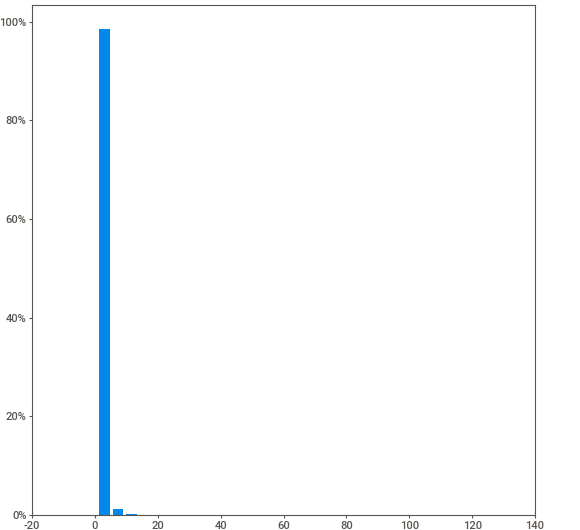
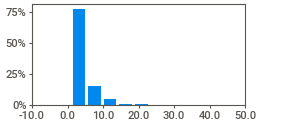
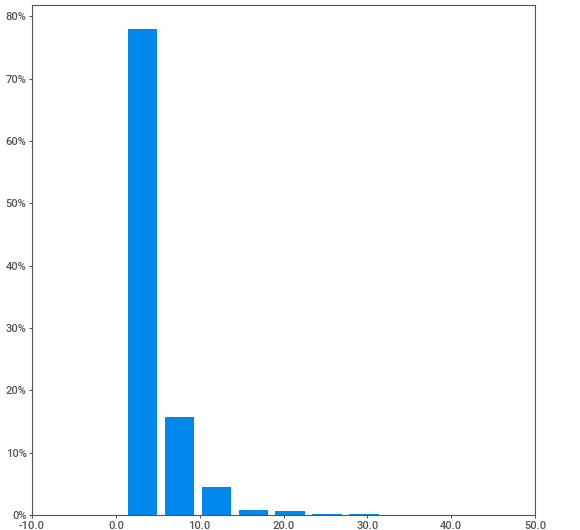
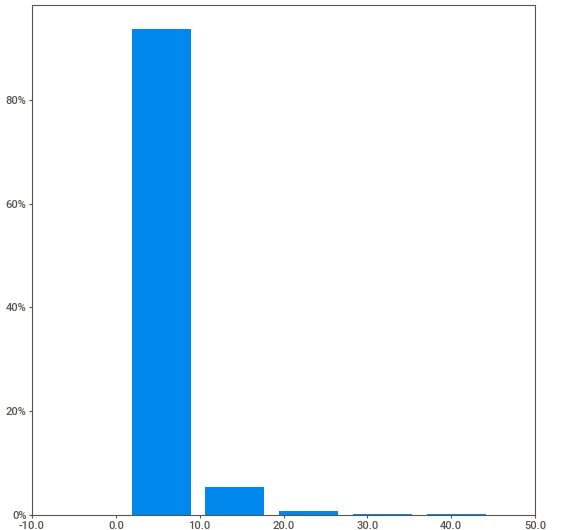
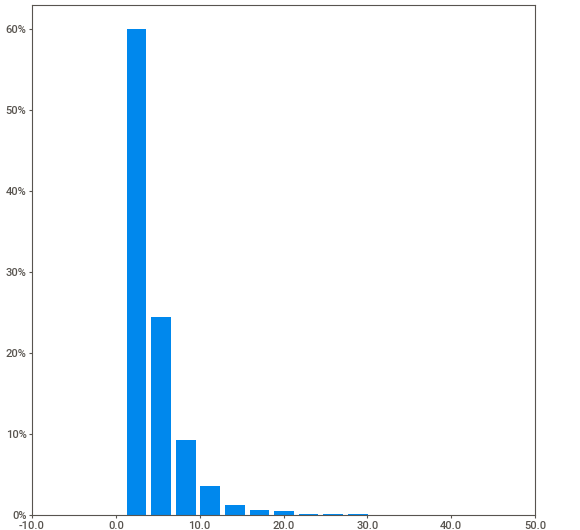
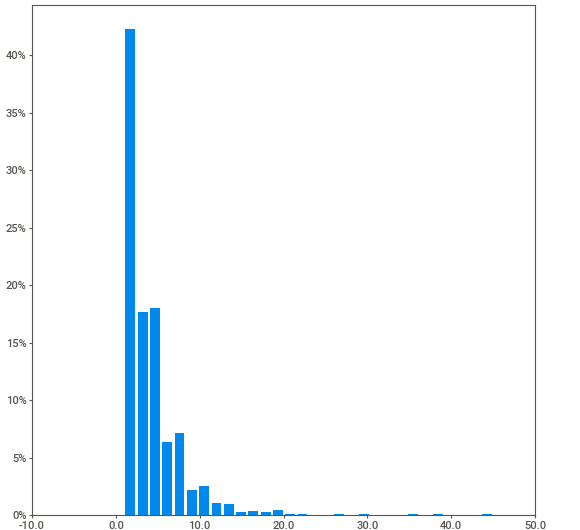
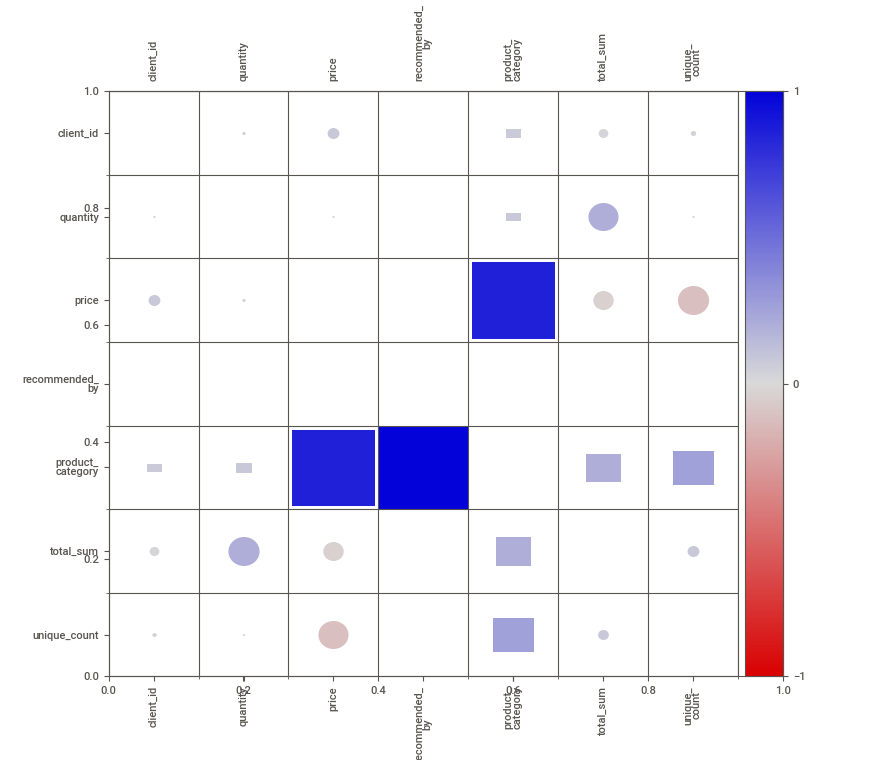
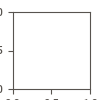

In [158]:
report = sv.analyze(df_a)
report.show_notebook()

Во-первых, мы видим, что в recommended_by нет уникальных значений. Удалим этот столбец. Во-вторых, у нас есть аномальные количества в quantity и price, изучим их. Также проверим message_id, сколько уникальных значений и есть ли корреляция между ними и целевым признаком.

In [159]:
df_a['recommended_by'].unique()

array(['bulk_message'], dtype=object)

In [160]:
df_a['message_id'].unique().shape

(25426,)

In [537]:
df_a.drop(['recommended_by','quantity'],axis=1,inplace=True)

Рассмотрим сколько есть товаров стоимостью больше 10.000р

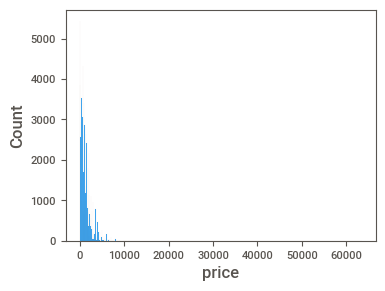

In [162]:
plt.figure(figsize=(4,3))
sns.histplot(df_a,x='price')
plt.show()

In [163]:
print(df_a[df_a['price']>10000].count())

client_id           112
price               112
date                112
message_id          112
product_category    112
total_sum           112
unique_count        112
dtype: int64


Так как таких значения всего 112, оставим их в категории F и не будем добавлять подразделы.

Создадим функцию, чтобы определить целевой признак. Нужная информация - совершит ли покупатель повторную покупку в течение ближайших 30 дней.

Приведем поле date к datetime.

In [538]:
df_a['date']= pd.to_datetime(df_a['date'])

Найдем общую сумму за день и развернем таблицу

In [539]:
df_a['price_sum'] = df_a['price'] * df_a['total_sum']
df_a.drop('price',axis=1,inplace=True)

In [540]:
df_a['common_sum'] = df_a.groupby(['client_id', 'date'])['price_sum'].transform('sum')
df_a.drop('price_sum',axis=1,inplace=True)

In [544]:
data_a = pd.pivot_table(df_a,
               index=["client_id", "date",'unique_count','message_id','common_sum'],
               values=["total_sum"],
               columns=["product_category"],
               aggfunc=[np.sum],
               fill_value=0
              ).reset_index()

In [545]:
data_a.head()

client_id       date unique_count  \
                                                                
product_category                                                
0                 1515915625468061003 2023-01-04            6   
1                 1515915625468061170 2023-03-26            2   
2                 1515915625468061170 2023-03-29            5   
3                 1515915625468061170 2023-06-17            1   
4                 1515915625468061994 2022-11-15            1   

                                               message_id common_sum  \
                                                                       
product_category                                                       
0                  1515915625468061003-9148-63b54b04855a4    16235.0   
1                 1515915625468061170-11144-641ad2cda77a2     5412.0   
2                 1515915625468061170-11208-6423f082d2fcb    25192.0   
3                 1515915625468061170-13157-6483192913837     2997.0   
4                  1515915625468061994-7882-637397eab304e      199.0   

                       sum                  
                 total_sum                  
product_category         A  B  C   D  E  F  
0                        0  0  0   7  0  0  
1                        2  0  0   2  0  0  
2                        0  0  0  12  0  0  
3                        0  0  3   0  0  0  
4                        0  1  0   0  0  0

In [546]:
data_a.columns = data_a.columns.droplevel(0)
data_a.columns=["client_id", "date",'unique_count','message_id','common_sum','A', 'B', 'C', 'D', 'E', 'F']

In [547]:
data_a = data_a.sort_values(['client_id','date'])

In [548]:
data_a

client_id       date  unique_count  \
0      1515915625468061003 2023-01-04             6   
1      1515915625468061170 2023-03-26             2   
2      1515915625468061170 2023-03-29             5   
3      1515915625468061170 2023-06-17             1   
4      1515915625468061994 2022-11-15             1   
...                    ...        ...           ...   
33268  1515915625998152414 2023-10-12             4   
33269  1515915625998380048 2023-10-14             1   
33270  1515915625998392034 2023-10-17             3   
33271  1515915625998917545 2023-10-23             1   
33272  1515915625999034637 2023-10-26             5   

                                    message_id  common_sum  A  B  C   D  E  F  
0       1515915625468061003-9148-63b54b04855a4     16235.0  0  0  0   7  0  0  
1      1515915625468061170-11144-641ad2cda77a2      5412.0  2  0  0   2  0  0  
2      1515915625468061170-11208-6423f082d2fcb     25192.0  0  0  0  12  0  0  
3      1515915625468061170-13157-6483192913837      2997.0  0  0  3   0  0  0  
4       1515915625468061994-7882-637397eab304e       199.0  0  1  0   0  0  0  
...                                        ...         ... .. .. ..  .. .. ..  
33268  1515915625487285279-13943-6527c5f7bf496      3210.0  2  4  2   0  0  0  
33269  1515915625500456745-13959-652a5904bbe9d      4499.0  0  0  0   1  0  0  
33270  1515915625998357625-13965-652e4ec021fac      5036.0  0  0  4   2  0  0  
33271  1515915625998917545-13990-653644913ee8a       198.0  2  0  0   0  0  0  
33272  1515915625999034637-14008-653a0fb5400b1     11470.0  0  0  0   6  0  0  

[33273 rows x 11 columns]

Создадим функцию для целевого признака.

In [549]:
def target_creation(data,name_customer,name_date,delta="30 days"):
    """Функция создает поле с целевым признаком в DataFrame
        data - DataFrame
        name_customer - поле с id клиента
        name_date - поле с датой покупки
    """
    d = data[[name_customer,name_date]]
    d['next_date'] = d.groupby(name_customer)[name_date].shift(-1)
    data['target'] = (d['next_date'] - d[name_date] <= pd.Timedelta(delta)).astype(int)
    return data

In [550]:
data_a = target_creation(data_a,'client_id','date')

На покупающую способность будет влиять празднечные дни и выходные. Рассмотрим Новый Год, 14 Февраля, 23 Февраля и 8 Марта. Так как это наиболее популярные праздники, когда покупают подарки. Найдем эти дни.

In [660]:
def date_check(x,y):
    """Функция возвращает за какой период был совершена покупка до праздника y. X - дата покупки"""
    if ((y - dt.timedelta(days=3)).strftime('%m-%d') <= x <= y.strftime('%m-%d')):
        return f'{y}_3d'
    elif (y - dt.timedelta(days=10)).strftime('%m-%d') <= x <= ((y - dt.timedelta(days=4)).strftime('%m-%d')):
        return f'{y}_10d'
    elif (y - dt.timedelta(weeks=4)).strftime('%m-%d') <= x <= ((y - dt.timedelta(days=11)).strftime('%m-%d')):
        return f'{y}_m'

def holiday_classification(x):
    """Функция возвращает date_check для основных праздников"""
    date_23 = pd.Timestamp('2022-02-23')
    date_ny = pd.Timestamp('2022-12-31')
    date_8 = pd.Timestamp('2022-03-08')
    date_14 = pd.Timestamp('2022-02-14')
    date_list = [date_23, date_ny, date_8, date_14]
    x = x.strftime('%m-%d')
    l = list()
    for y in date_list:
        l.append(date_check(x,y))
    return l

data_a['weekend'] = (data_a['date'].dt.weekday > 5).astype(int)
data_a[['23f','ny','8m','14f']] = pd.DataFrame(data_a['date'].apply(holiday_classification).tolist())


KeyboardInterrupt



In [552]:
data_a = data_a.fillna('0') # заменим пропуски

In [553]:
data_a

client_id       date  unique_count  \
0      1515915625468061003 2023-01-04             6   
1      1515915625468061170 2023-03-26             2   
2      1515915625468061170 2023-03-29             5   
3      1515915625468061170 2023-06-17             1   
4      1515915625468061994 2022-11-15             1   
...                    ...        ...           ...   
33268  1515915625998152414 2023-10-12             4   
33269  1515915625998380048 2023-10-14             1   
33270  1515915625998392034 2023-10-17             3   
33271  1515915625998917545 2023-10-23             1   
33272  1515915625999034637 2023-10-26             5   

                                    message_id  common_sum  A  B  C   D  E  F  \
0       1515915625468061003-9148-63b54b04855a4     16235.0  0  0  0   7  0  0   
1      1515915625468061170-11144-641ad2cda77a2      5412.0  2  0  0   2  0  0   
2      1515915625468061170-11208-6423f082d2fcb     25192.0  0  0  0  12  0  0   
3      1515915625468061170-13157-6483192913837      2997.0  0  0  3   0  0  0   
4       1515915625468061994-7882-637397eab304e       199.0  0  1  0   0  0  0   
...                                        ...         ... .. .. ..  .. .. ..   
33268  1515915625487285279-13943-6527c5f7bf496      3210.0  2  4  2   0  0  0   
33269  1515915625500456745-13959-652a5904bbe9d      4499.0  0  0  0   1  0  0   
33270  1515915625998357625-13965-652e4ec021fac      5036.0  0  0  4   2  0  0   
33271  1515915625998917545-13990-653644913ee8a       198.0  2  0  0   0  0  0   
33272  1515915625999034637-14008-653a0fb5400b1     11470.0  0  0  0   6  0  0   

       target  weekend 23f ny 8m 14f  
0           0        0   0  0  0   0  
1           1        1   0  0  0   0  
2           0        0   0  0  0   0  
3           0        0   0  0  0   0  
4           1        0   0  0  0   0  
...       ...      ...  .. .. ..  ..  
33268       0        0   0  0  0   0  
33269       0        0   0  0  0   0  
33270       0        0   0  0  0   0  
33271       0        0   0  0  0   0  
33272       0        0   0  0  0   0  

[33273 rows x 17 columns]

Последний шаг - заменим поле date на месяц. Так мы сможем понять сезонность товара.

In [554]:
data_a.date = data_a.date.dt.month

Проведем корреляционный анализ

interval columns not set, guessing: ['date', 'unique_count', 'common_sum', 'A', 'B', 'C', 'D', 'E', 'F', 'target', 'weekend']


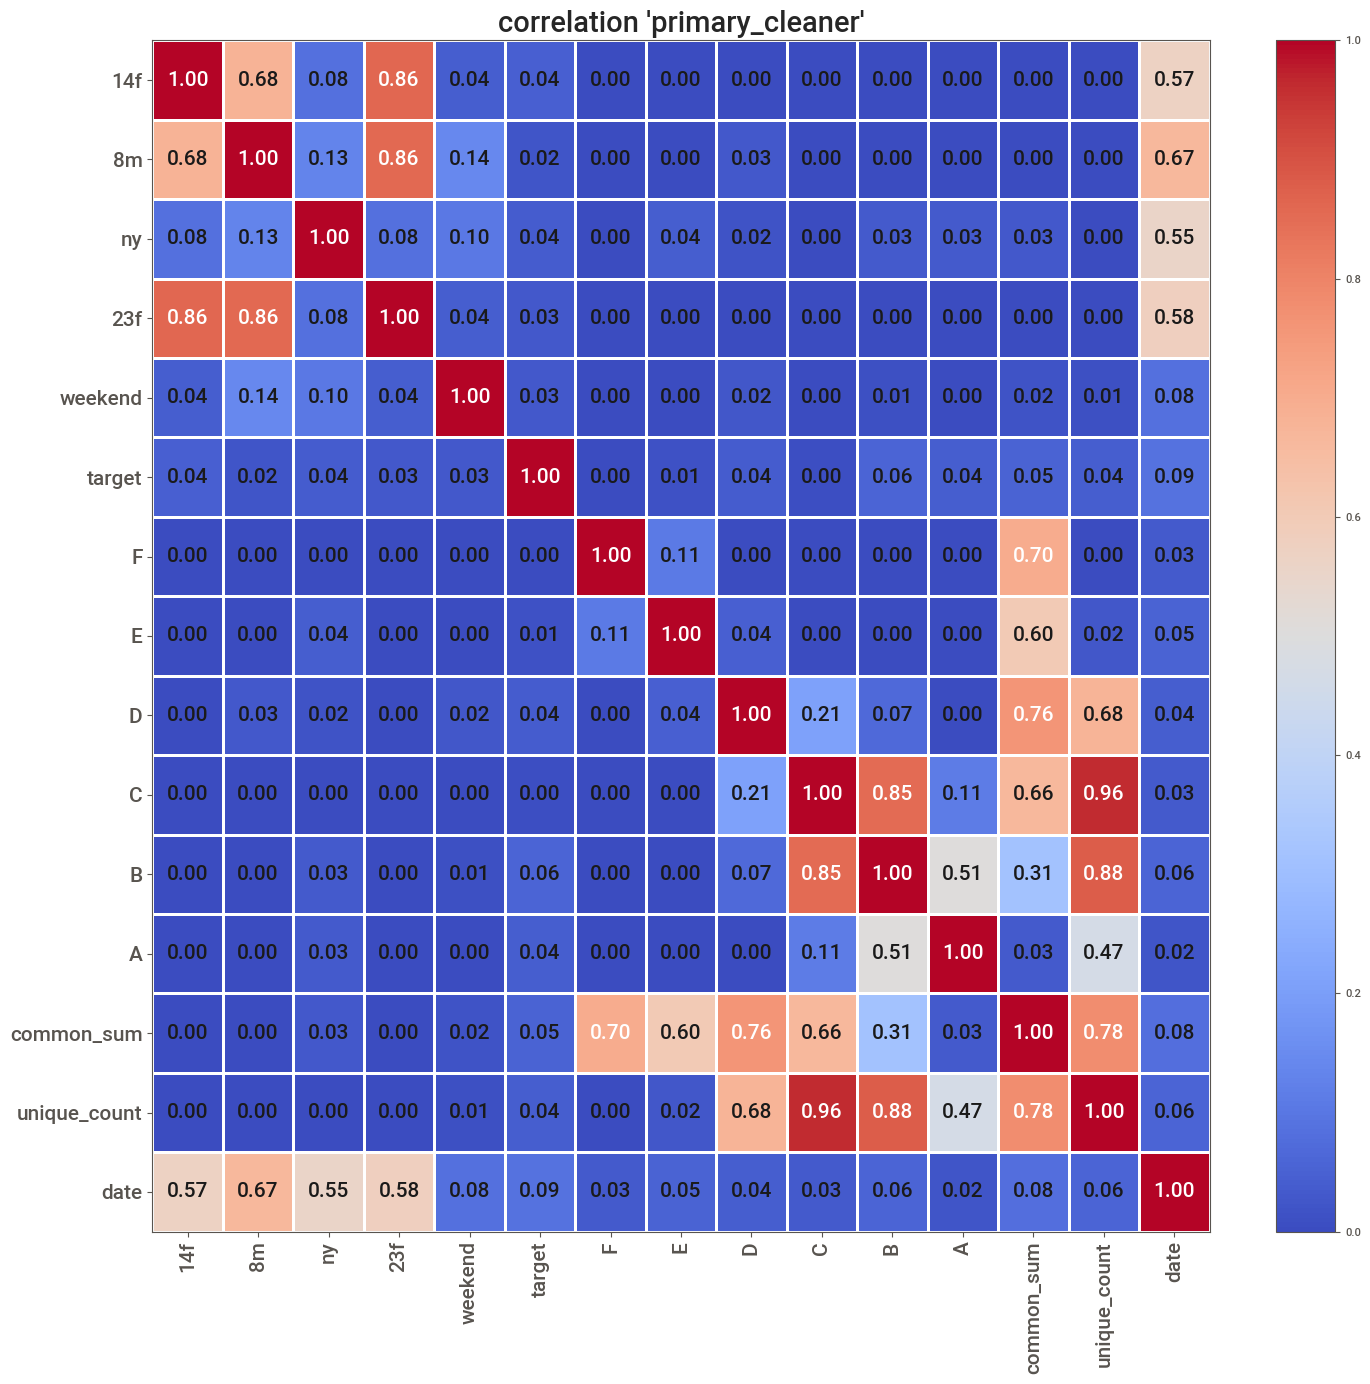

In [178]:
phik_overview = data_a.drop(['client_id','message_id'],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='coolwarm',
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

interval columns not set, guessing: ['target']


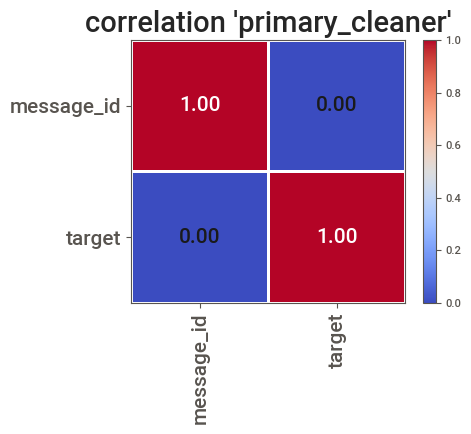

In [179]:
phik_overview = data_a[['target','message_id']].phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='coolwarm',
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(5, 4.5))

Исходя из коэффициентов корреляции удалим поле с сообщениями, а также id клиента (так как никакой информации в id нет).

In [555]:
data_a = data_a.drop(['client_id','message_id'],axis=1)

### Таблица Marketplace - магазин одежды <a class="anchor" id="section_1_2"></a>

Изучим распределение цен в таблице Marketplace

In [556]:
df_m.head()

client_id  quantity    price  \
0  1515915625440944408         1   6298.0   
1  1515915625440992498         1   7318.0   
2  1515915625441026424         1  65798.0   
3  1515915625441118180         1   5598.0   
4  1515915625441124500         1  77998.0   

                               message_id  created_at                 date  
0  1515915625440944408-1752-6450b79616277  2023-05-02  2023-05-02 08:49:57  
1  1515915625440992498-1818-646b35d089c98  2023-05-22  2023-05-22 13:52:13  
2  1515915625441026424-1802-64634e24a2cb9  2023-05-17  2023-05-17 11:21:04  
3  1515915625441118180-1820-646c9444ebf39  2023-05-23  2023-05-23 19:02:53  
4  1515915625441124500-1825-646ed5cf4d5ed  2023-05-25  2023-05-25 07:46:52

In [557]:
print(df_m.info())
print('Количество дубликатов -', df_m.duplicated().sum())
print('Количество пропусков - \n', df_m.isna().sum(),sep='')
df_m.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   48182 non-null  int64  
 1   quantity    48182 non-null  int64  
 2   price       48182 non-null  float64
 3   message_id  48182 non-null  object 
 4   created_at  48182 non-null  object 
 5   date        48182 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ MB
None
Количество дубликатов - 2159
Количество пропусков - 
client_id     0
quantity      0
price         0
message_id    0
created_at    0
date          0
dtype: int64


client_id      quantity         price
count  4.818200e+04  48182.000000  4.818200e+04
mean   1.515916e+18      1.017413  2.791895e+04
std    3.173388e+07      0.540592  4.492274e+04
min    1.515916e+18      1.000000  0.000000e+00
25%    1.515916e+18      1.000000  1.204250e+03
50%    1.515916e+18      1.000000  9.998000e+03
75%    1.515916e+18      1.000000  3.599800e+04
max    1.515916e+18     50.000000  1.299998e+06

По сравнению с Apparel стоимость товаров значительно выше, что видно из describe. Поэтому переопределим категории для df_m. Будем основываться на квантили.

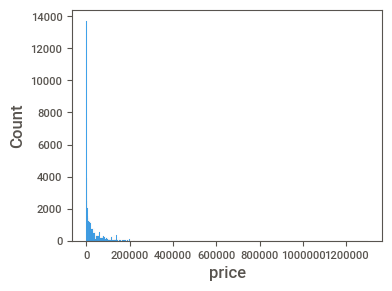

In [197]:
plt.figure(figsize=(4,3))
sns.histplot(df_m,x='price')
plt.show()

In [198]:
df_m.price.quantile([.1,.2,.25,.5,.75,.9])

0.10        2.00
0.20      478.00
0.25     1204.25
0.50     9998.00
0.75    35998.00
0.90    83996.00
Name: price, dtype: float64

In [80]:
def product_category_m(x):
    if x < 100:
        return "A"
    if x < 1250:
        return "B"
    if x < 10000:
        return "C"
    if x < 36000:
        return "D"
    if x < 85000:
        return "E"
    else:
        return "F"

In [181]:
def df_preparation_m(df_a):
    df_a['product_category'] = df_a['price'].apply(product_category_m)
    df_a['total_sum'] = df_a.groupby(['client_id', 'price', 'date', 'message_id'])['quantity'].transform('sum')
    df_a.drop_duplicates(inplace=True)
    df_a.reset_index(drop=True,inplace=True)
    df_a['unique_count'] = df_a.groupby(['client_id', 'date'])['price'].transform('nunique')
    df_a.drop(['quantity'],axis=1,inplace=True)
    df_a['date']= pd.to_datetime(df_a['date'])
    df_a['price_sum'] = df_a['price'] * df_a['total_sum']
    df_a.drop('price',axis=1,inplace=True)
    df_a['common_sum'] = df_a.groupby(['client_id', 'date'])['price_sum'].transform('sum')
    df_a.drop('price_sum',axis=1,inplace=True)
    data_a = pd.pivot_table(df_a,
                   index=["client_id", "date",'unique_count','message_id','common_sum'],
                   values=["total_sum"],
                   columns=["product_category"],
                   aggfunc=[np.sum],
                   fill_value=0
                  ).reset_index()
    data_a.columns = data_a.columns.droplevel(0)
    data_a.columns=["client_id", "date",'unique_count','message_id','common_sum','A', 'B', 'C', 'D', 'E', 'F']
    data_a = data_a.sort_values(['client_id','date'])
    data_a = target_creation(data_a,'client_id','date')
    data_a['weekend'] = (data_a['date'].dt.weekday > 5).astype(int)
    data_a[['23f','ny','8m','14f']] = pd.DataFrame(data_a['date'].apply(holiday_classification).tolist())
    data_a = data_a.fillna('0')
    data_a.date = data_a.date.dt.month
    return data_a

                                             |          | [  0%]   00:00 -> (? left)


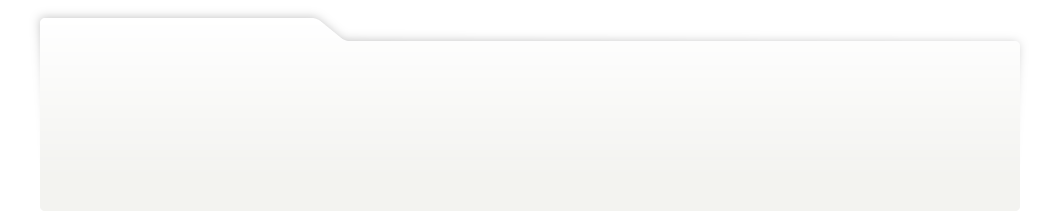
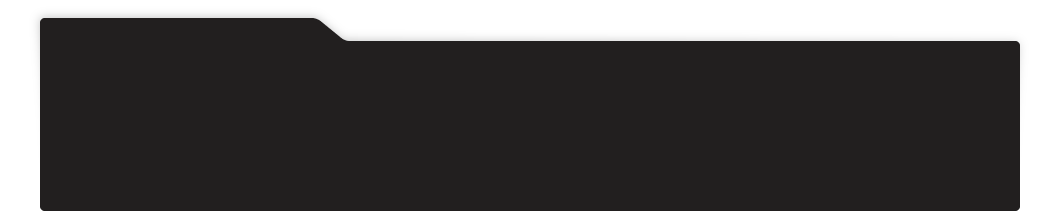
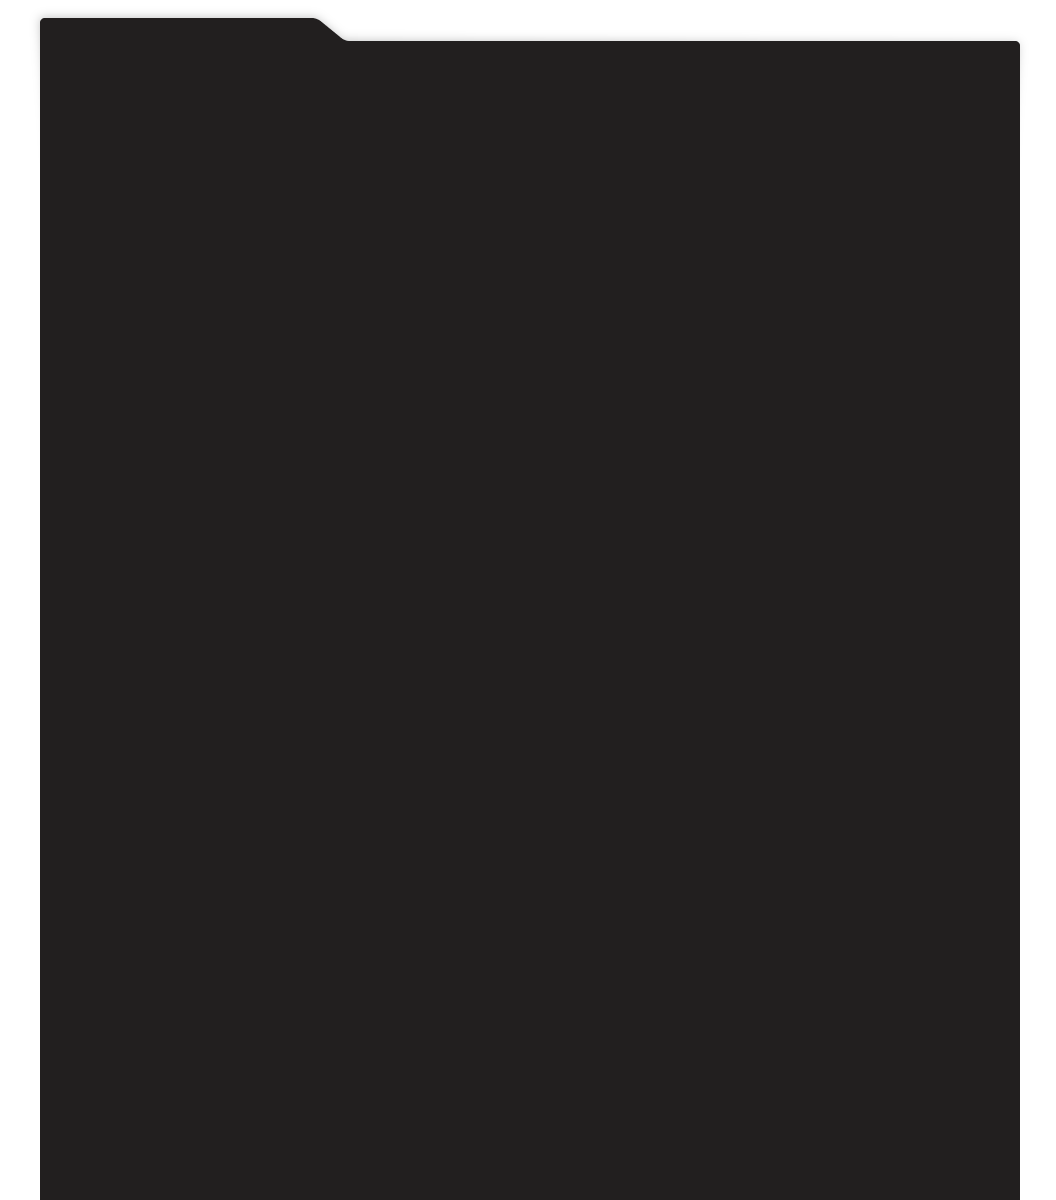
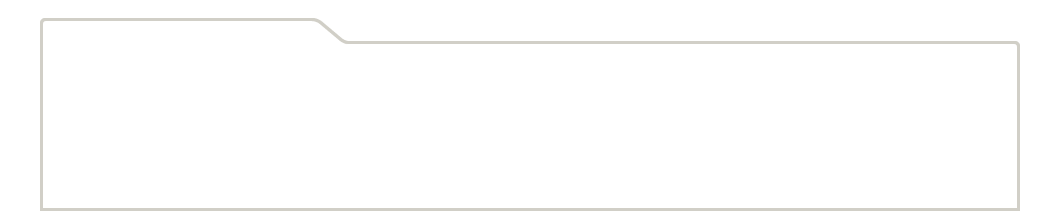
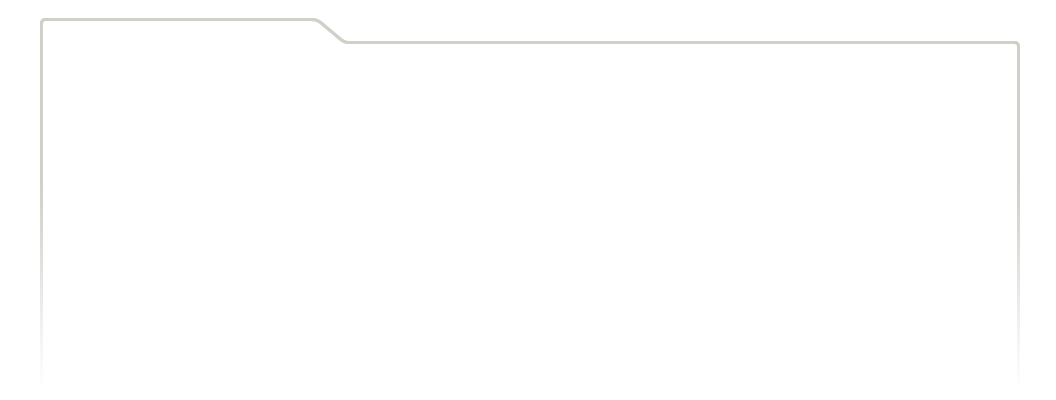
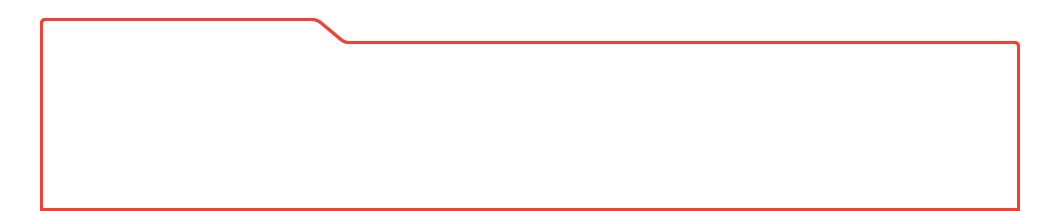
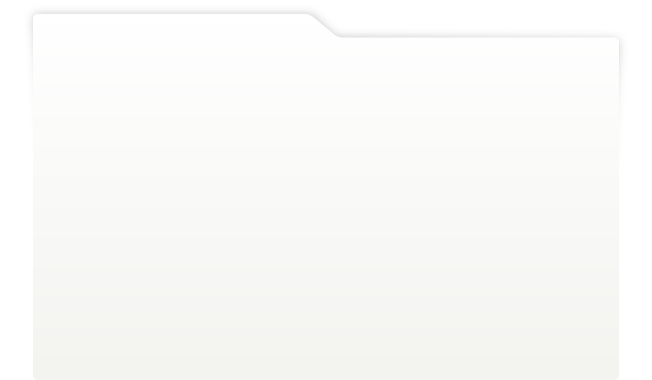
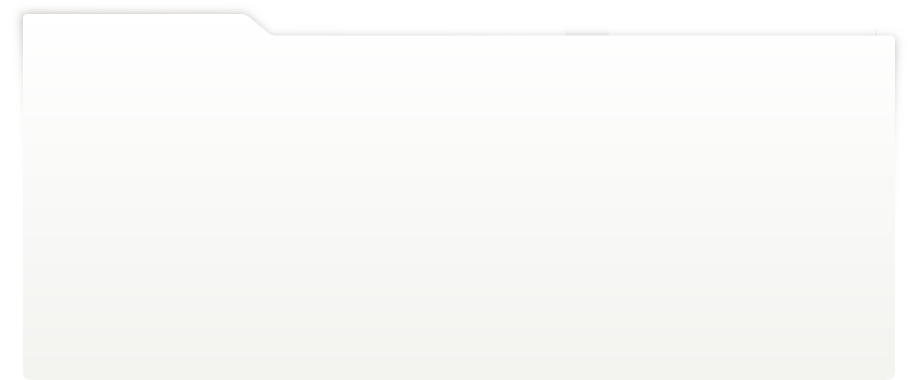
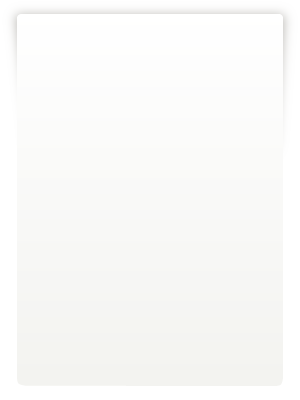
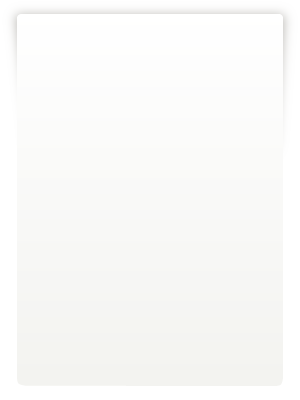
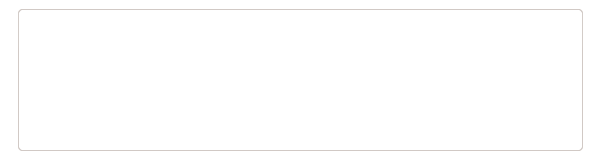
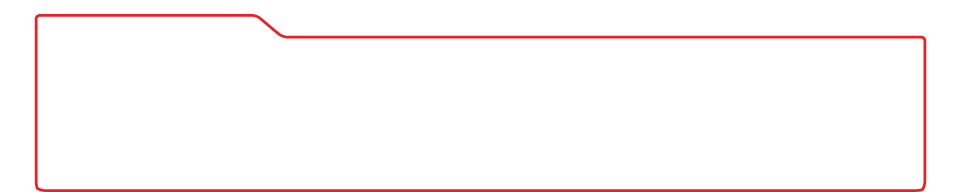
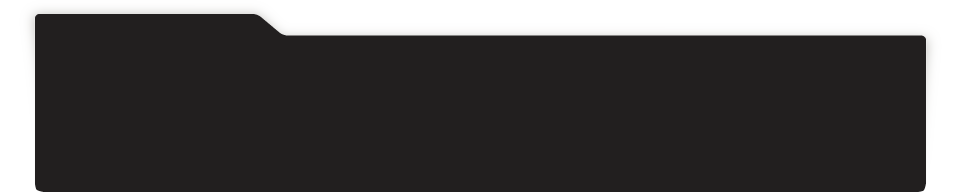
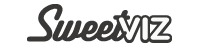
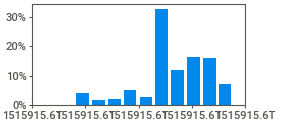
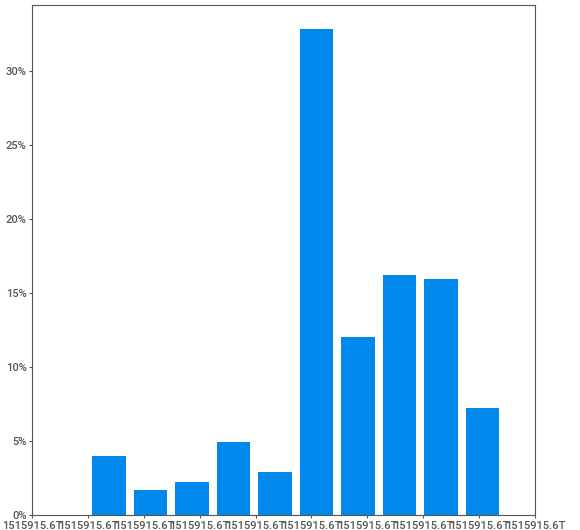
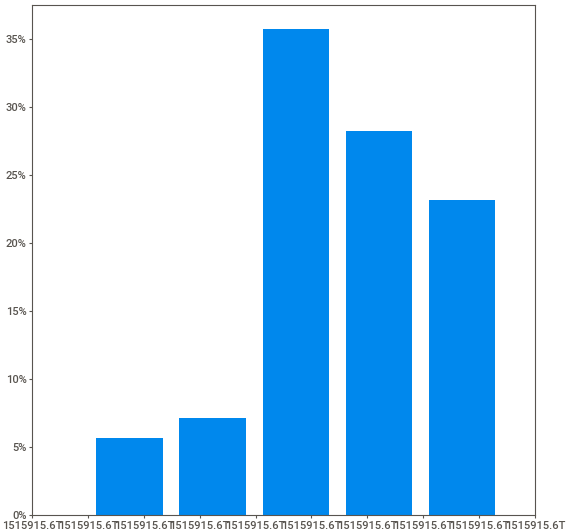
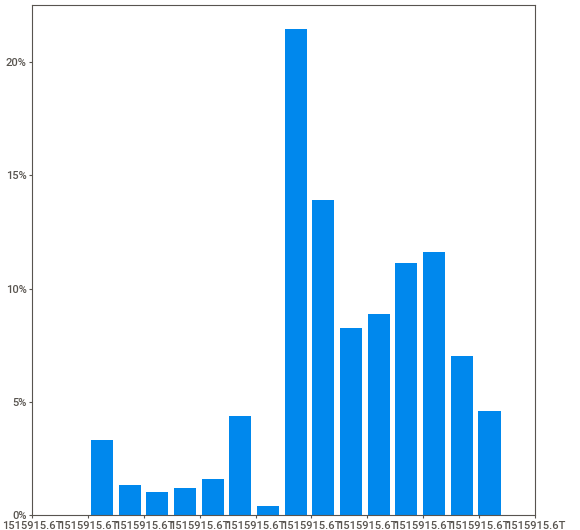
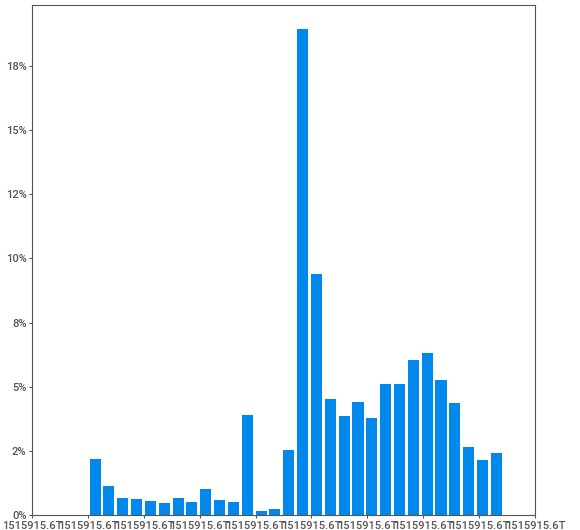
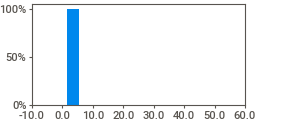
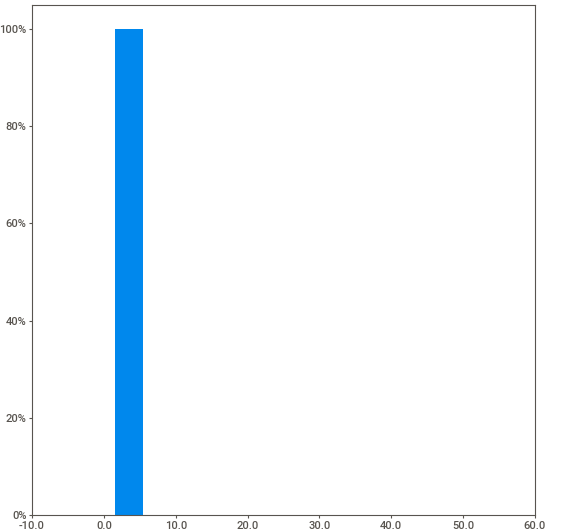
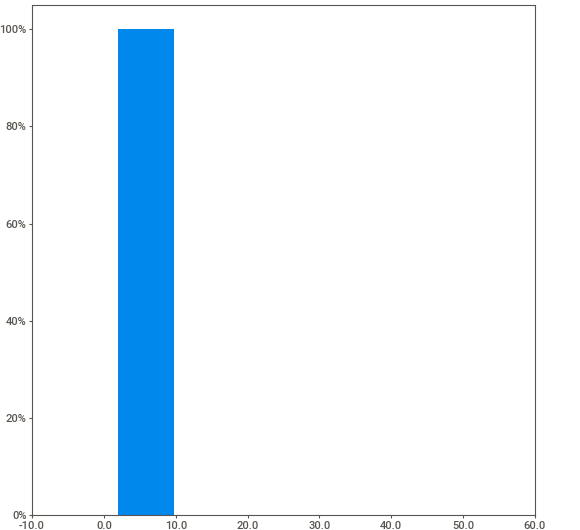
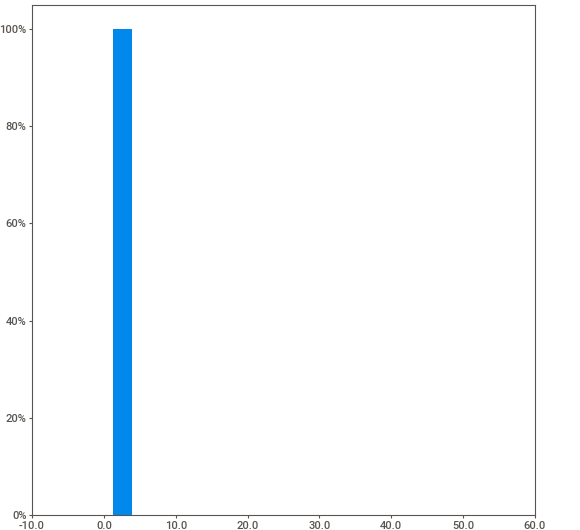
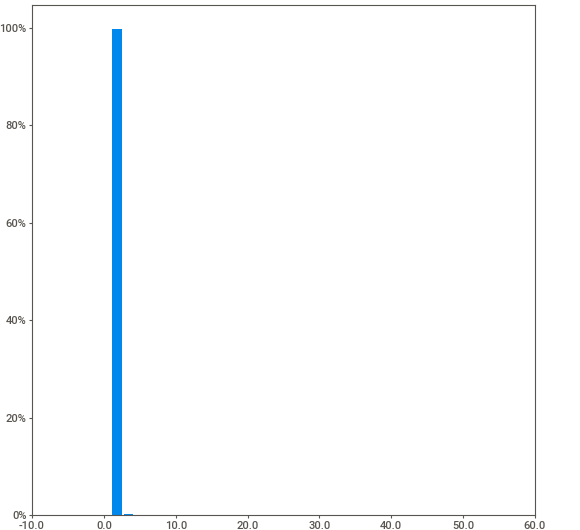
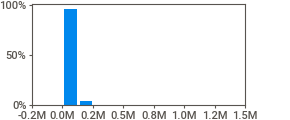
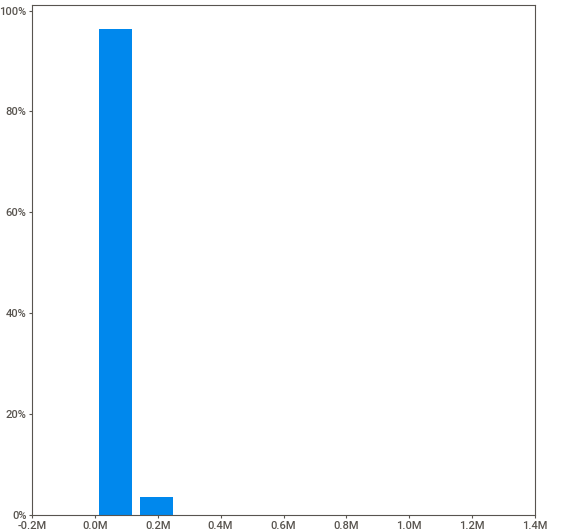
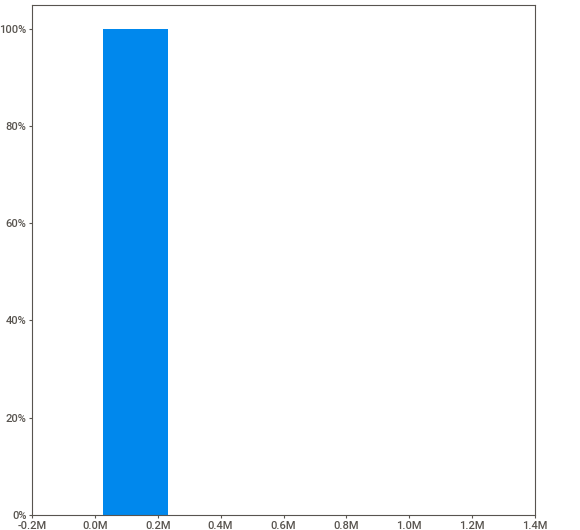
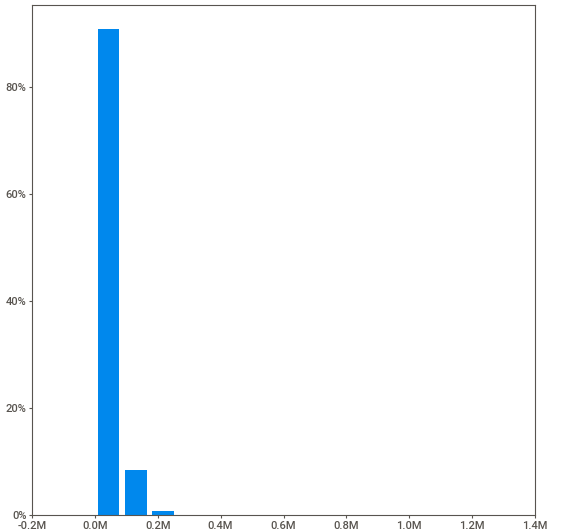
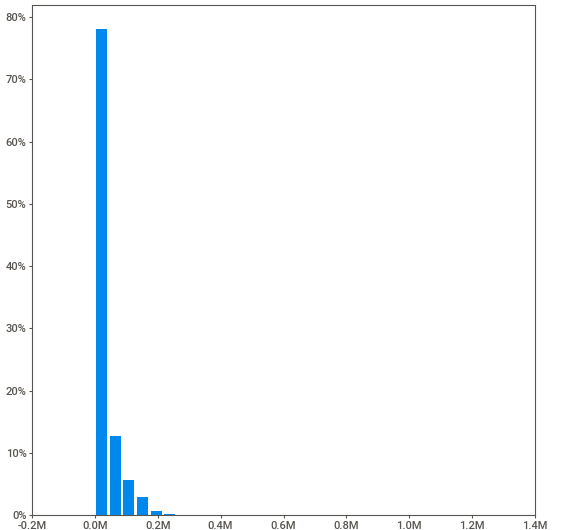
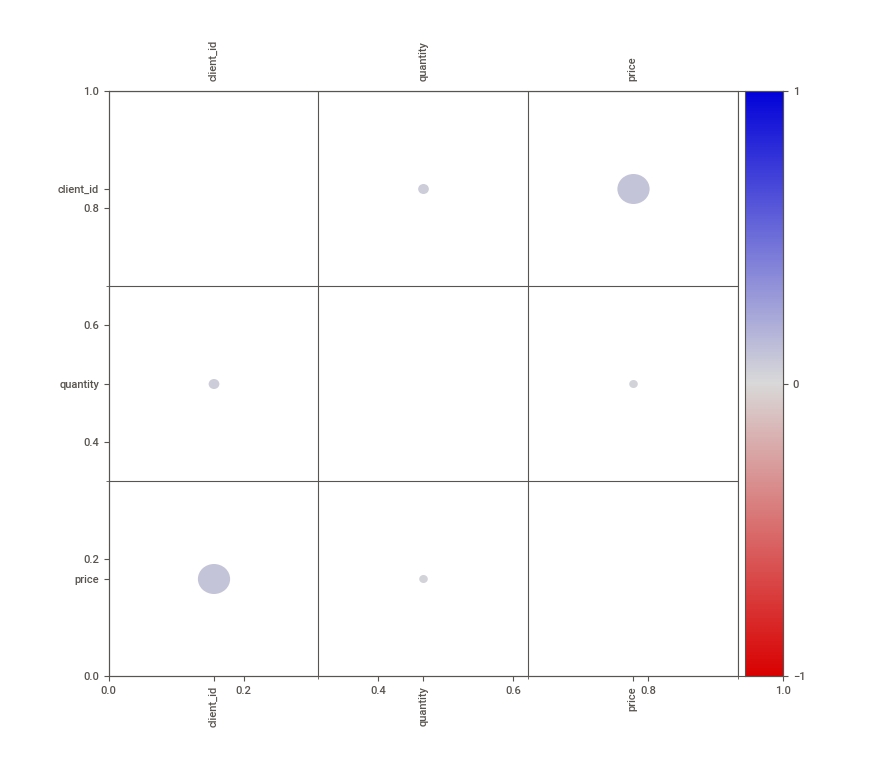
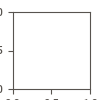

In [82]:
report_m = sv.analyze(df_m)
report_m.show_notebook()

Приведем поле date к формату %y-%m-%d

In [558]:
df_m['date']= pd.to_datetime(df_m['date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')

In [183]:
data_m = df_preparation_m(df_m)

In [184]:
data_m.head()

client_id  date  unique_count  \
0  1515915625440099873     7             1   
1  1515915625440099873     8             1   
2  1515915625440939402     1             1   
3  1515915625440944408     3             1   
4  1515915625440944408     5             1   

                               message_id  common_sum  A  B  C  D  E  F  \
0  1515915625440099873-1965-64abd07b9561d     31998.0  0  0  0  1  0  0   
1  1515915625440099873-2021-64d219c458813      1218.0  0  1  0  0  0  0   
2  1515915625440939402-1474-63d738fa8d5cc     75998.0  0  0  0  0  1  0   
3  1515915625440944408-1587-63fef11f97d27       882.0  0  1  0  0  0  0   
4  1515915625440944408-1752-6450b79616277      6298.0  0  0  1  0  0  0   

   target  weekend                    23f ny                       8m  \
0       1        1                      0  0                        0   
1       0        0                      0  0                        0   
2       0        0  2022-02-23 00:00:00_m  0                        0   
3       0        0                      0  0  2022-03-08 00:00:00_10d   
4       0        0                      0  0                        0   

                     14f  
0                      0  
1                      0  
2  2022-02-14 00:00:00_m  
3                      0  
4                      0

interval columns not set, guessing: ['date', 'unique_count', 'common_sum', 'A', 'B', 'C', 'D', 'E', 'F', 'target', 'weekend']


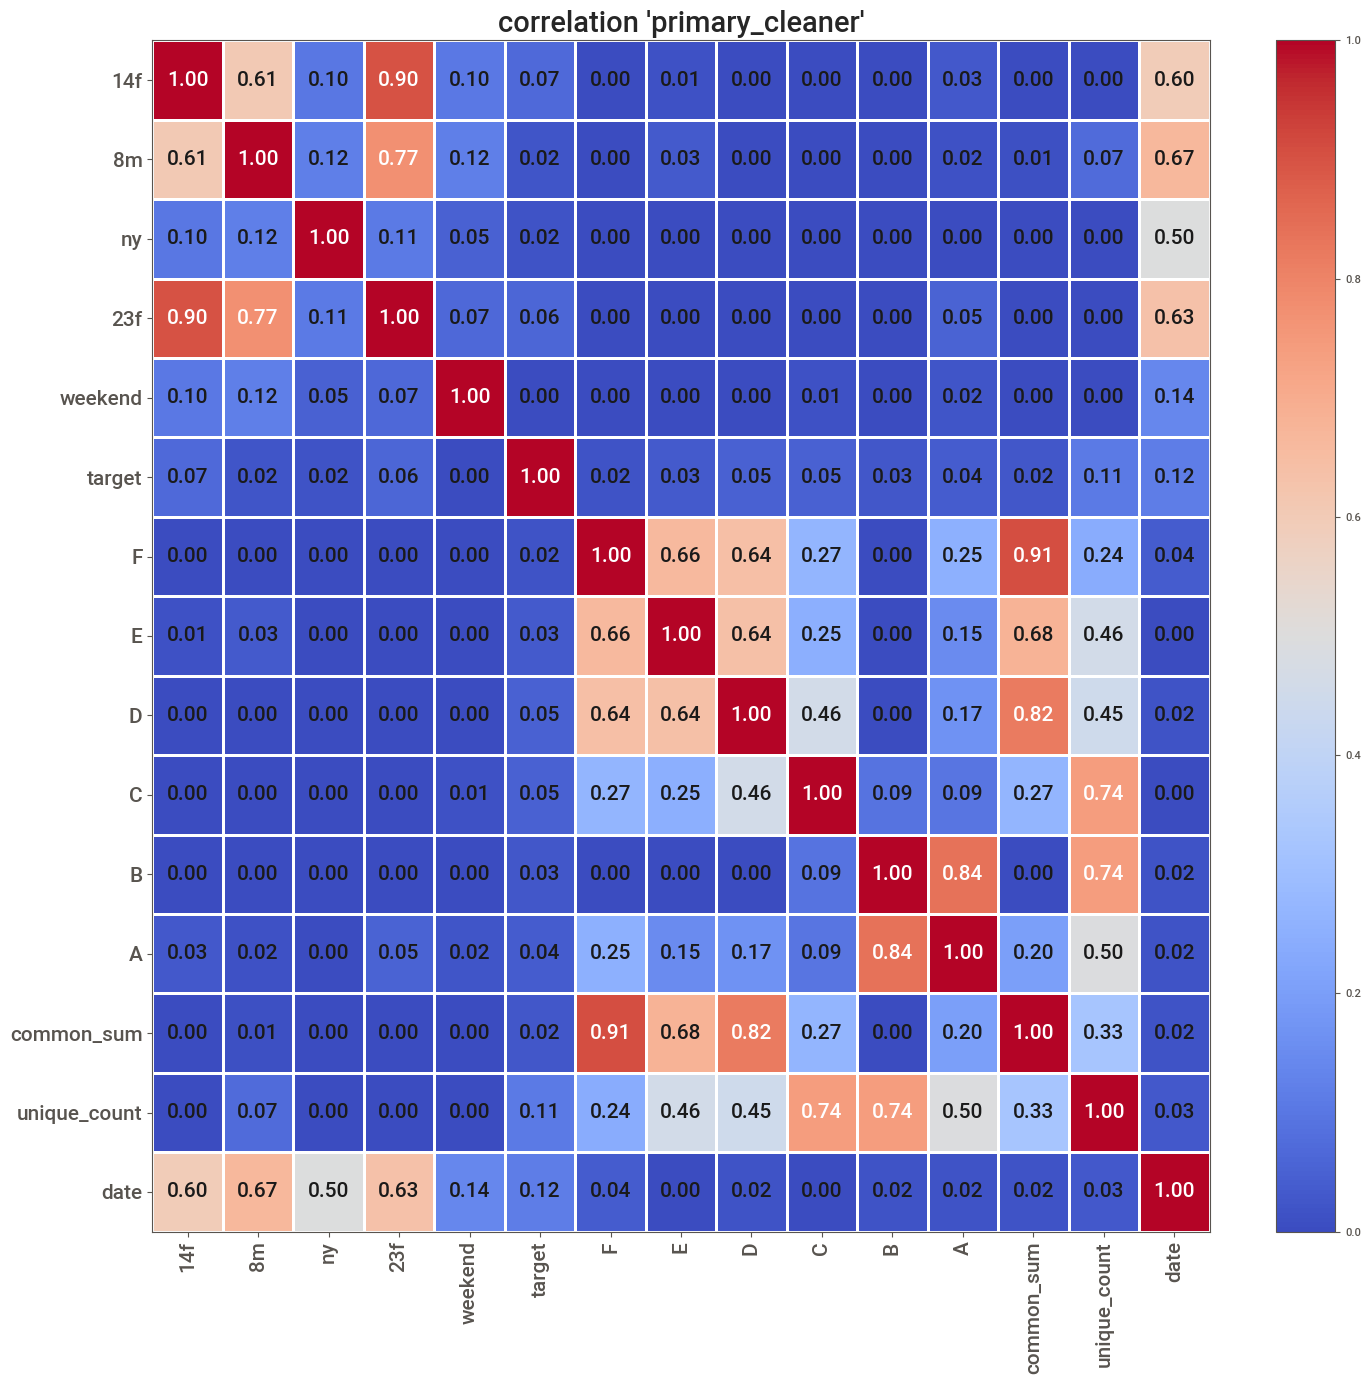

In [185]:
phik_overview = data_m.drop(['client_id','message_id'],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='coolwarm',
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

interval columns not set, guessing: ['target']


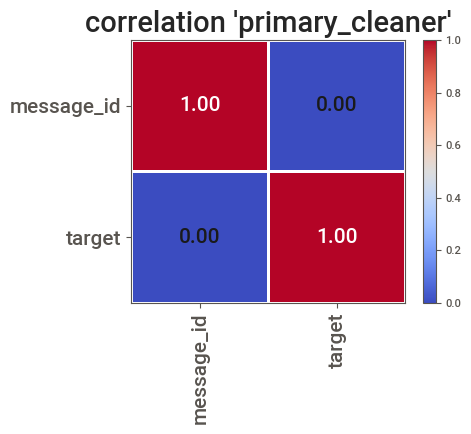

In [186]:
phik_overview = data_m[['target','message_id']].phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='coolwarm',
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(5, 4.5))

Исходя из коэффициентов корреляции удалим поле с сообщениями, а также id клиента (так как никакой информации в id нет).

In [208]:
data_m = data_m.drop(['client_id','message_id'],axis=1)

### Таблица Gifts – магазин подарков <a class="anchor" id="section_1_3"></a>

Рассмотрим последний магазин - Gifts

In [189]:
df_g.head()

client_id  quantity    price        date  \
0  1515915625803894158         1   8943.0  2023-10-11   
1  1515915625803894158         1  46369.0  2023-10-11   
2  1515915625803894158         1   4666.0  2023-10-11   
3  1515915625803894158         1  11963.0  2023-10-11   
4  1515915625803894158         1  13107.0  2023-10-11   

                                message_id recommended_by  
0  1515915625935652010-16166-6525589bca68f   bulk_message  
1  1515915625935652010-16166-6525589bca68f   bulk_message  
2  1515915625935652010-16166-6525589bca68f   bulk_message  
3  1515915625935652010-16166-6525589bca68f   bulk_message  
4  1515915625935652010-16166-6525589bca68f   bulk_message

In [190]:
print(df_g.info())
print('Количество дубликатов -', df_g.duplicated().sum())
print('Количество пропусков - \n', df_g.isna().sum(),sep='')
df_g.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       811 non-null    int64  
 1   quantity        811 non-null    int64  
 2   price           811 non-null    float64
 3   date            811 non-null    object 
 4   message_id      811 non-null    object 
 5   recommended_by  811 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.1+ KB
None
Количество дубликатов - 56
Количество пропусков - 
client_id         0
quantity          0
price             0
date              0
message_id        0
recommended_by    0
dtype: int64


client_id    quantity          price
count  8.110000e+02  811.000000     811.000000
mean   1.515916e+18    1.003699   14468.795314
std    6.255407e+07    0.060745   17774.341837
min    1.515916e+18    1.000000     656.000000
25%    1.515916e+18    1.000000    3878.000000
50%    1.515916e+18    1.000000    7533.000000
75%    1.515916e+18    1.000000   17938.000000
max    1.515916e+18    2.000000  173586.000000

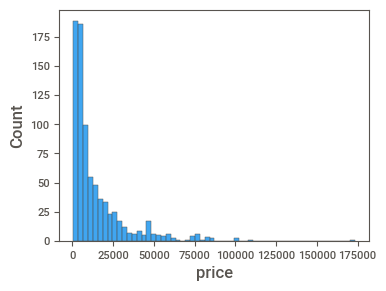

In [191]:
plt.figure(figsize=(4,3))
sns.histplot(df_g,x='price')
plt.show()

In [201]:
df_g.price.quantile([.1,.2,.25,.5,.75,.9])

0.10     2316.0
0.20     3414.0
0.25     3878.0
0.50     7533.0
0.75    17938.0
0.90    34990.0
Name: price, dtype: float64

In [202]:
def product_category_g(x):
    if x < 2000:
        return "A"
    if x < 3400:
        return "B"
    if x < 4000:
        return "C"
    if x < 7600:
        return "D"
    if x < 18000:
        return "E"
    else:
        return "F"

In [203]:
def df_preparation_g(df_a):
    df_a['product_category'] = df_a['price'].apply(product_category_g)
    df_a['total_sum'] = df_a.groupby(['client_id', 'price', 'date', 'message_id'])['quantity'].transform('sum')
    df_a.drop_duplicates(inplace=True)
    df_a.reset_index(drop=True,inplace=True)
    df_a['unique_count'] = df_a.groupby(['client_id', 'date'])['price'].transform('nunique')
    df_a.drop(['quantity'],axis=1,inplace=True)
    df_a['date']= pd.to_datetime(df_a['date'])
    df_a['price_sum'] = df_a['price'] * df_a['total_sum']
    df_a.drop('price',axis=1,inplace=True)
    df_a['common_sum'] = df_a.groupby(['client_id', 'date'])['price_sum'].transform('sum')
    df_a.drop('price_sum',axis=1,inplace=True)
    data_a = pd.pivot_table(df_a,
                   index=["client_id", "date",'unique_count','message_id','common_sum'],
                   values=["total_sum"],
                   columns=["product_category"],
                   aggfunc=[np.sum],
                   fill_value=0
                  ).reset_index()
    data_a.columns = data_a.columns.droplevel(0)
    data_a.columns=["client_id", "date",'unique_count','message_id','common_sum','A', 'B', 'C', 'D', 'E', 'F']
    data_a = data_a.sort_values(['client_id','date'])
    data_a = target_creation(data_a,'client_id','date')
    data_a['weekend'] = (data_a['date'].dt.weekday > 5).astype(int)
    data_a[['23f','ny','8m','14f']] = pd.DataFrame(data_a['date'].apply(holiday_classification).tolist())
    data_a = data_a.fillna('0')
    data_a.date = data_a.date.dt.month
    return data_a

                                             |          | [  0%]   00:00 -> (? left)


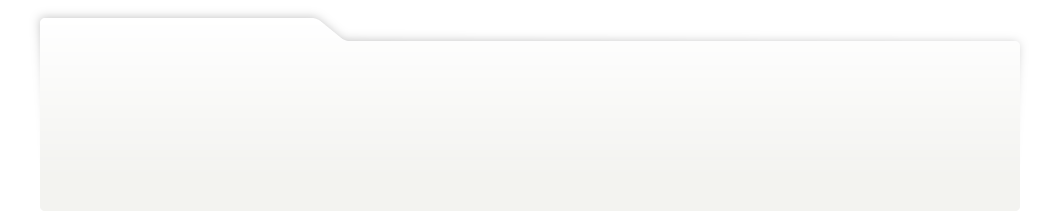
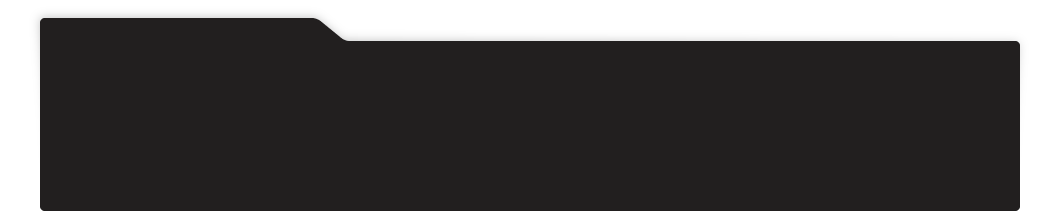
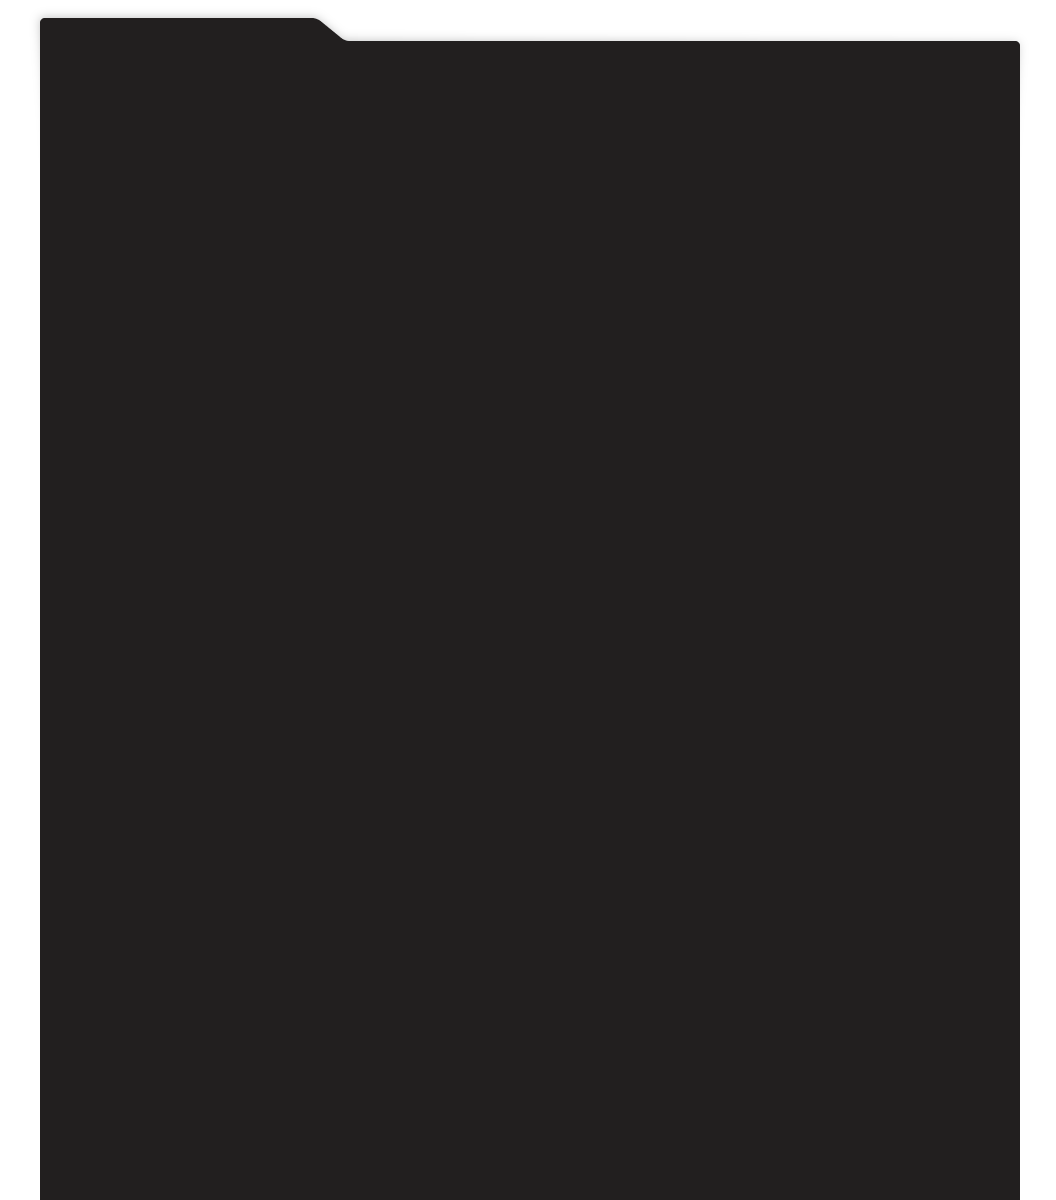
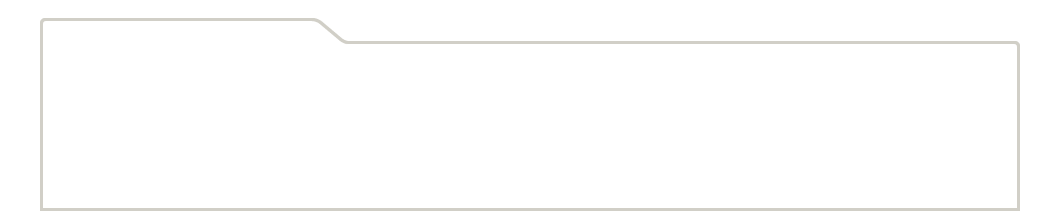
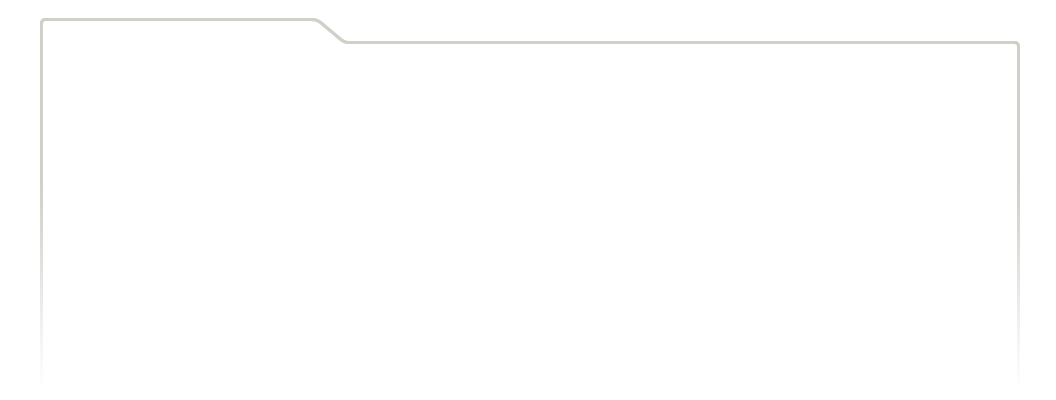
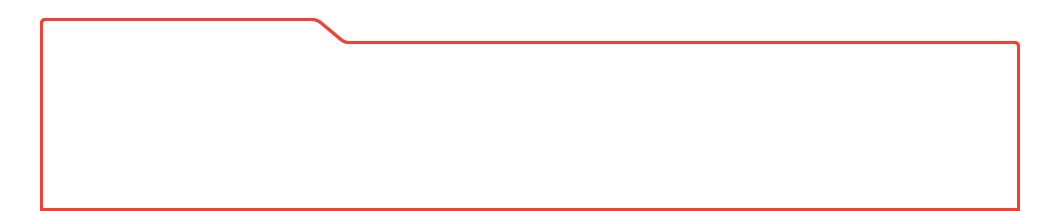
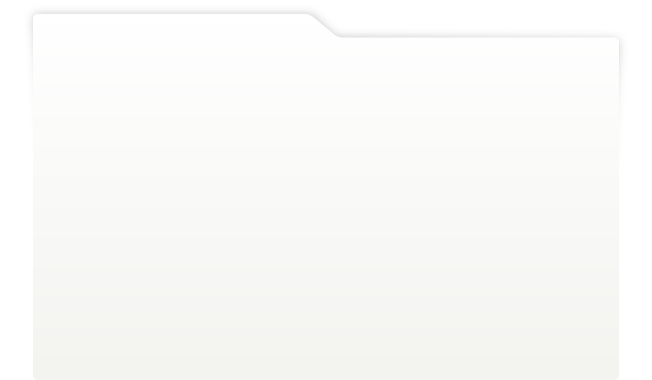
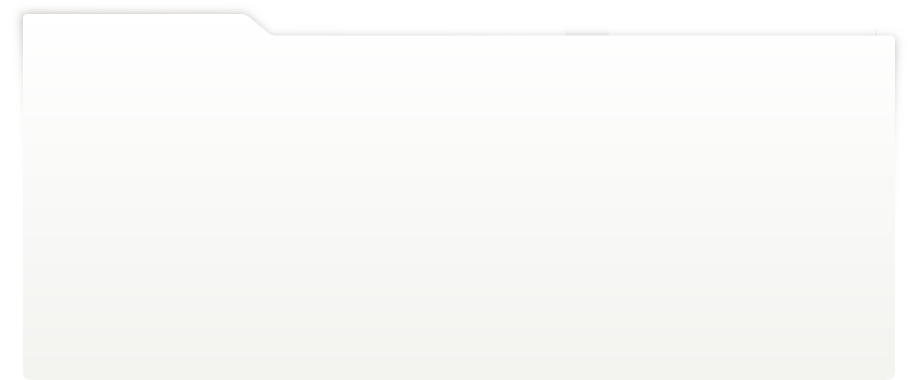
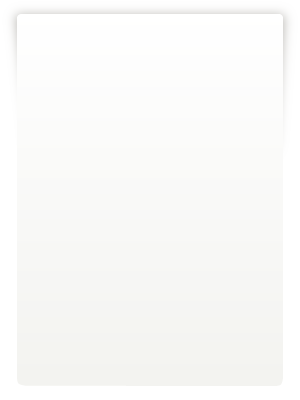
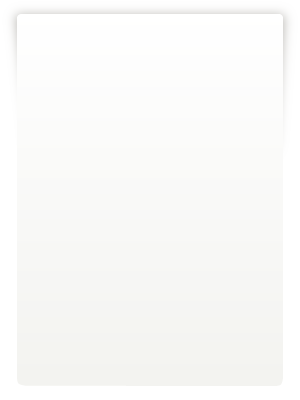
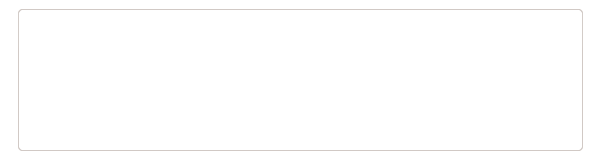
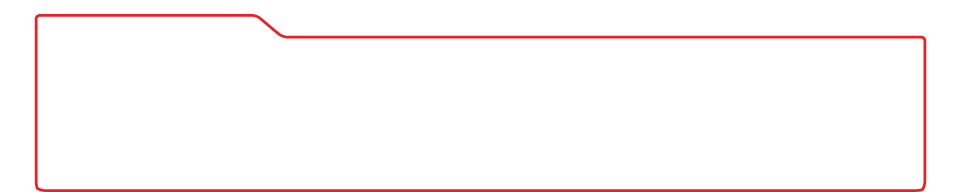
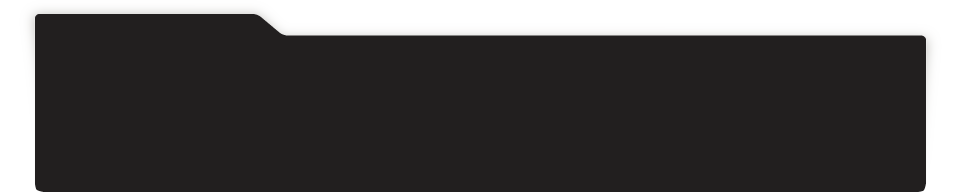
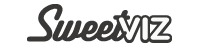
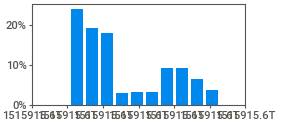
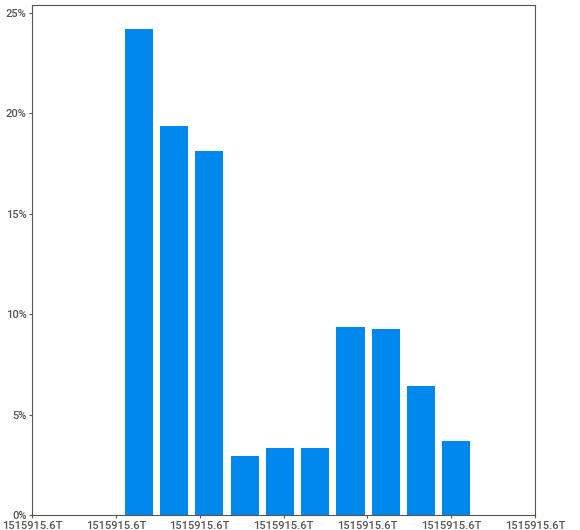
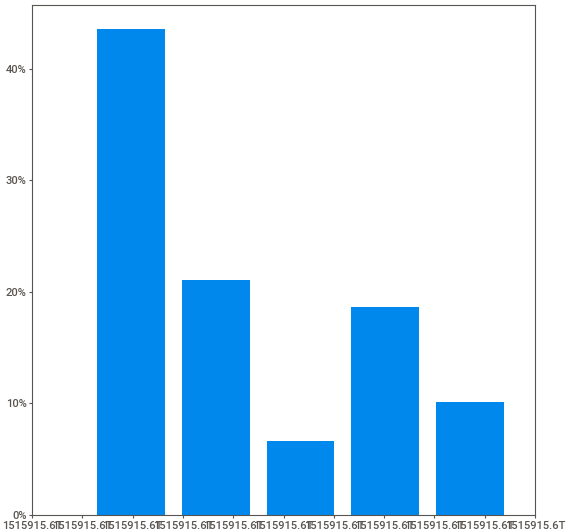
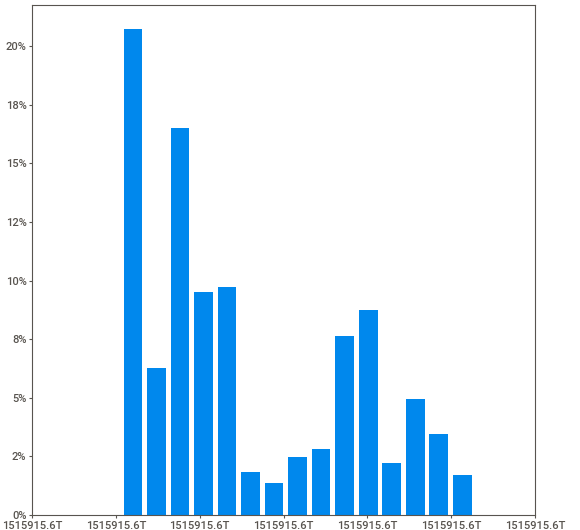
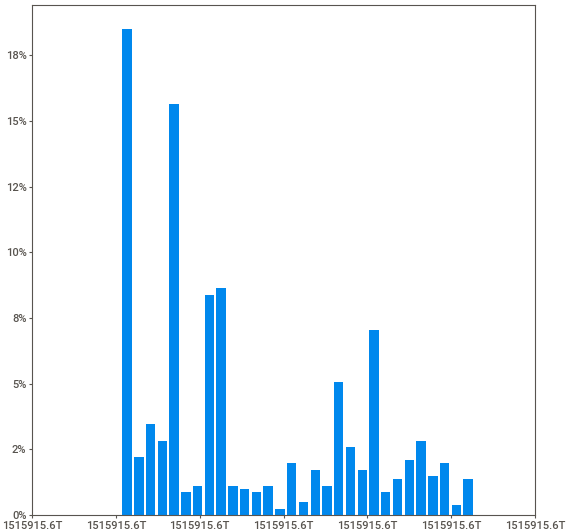
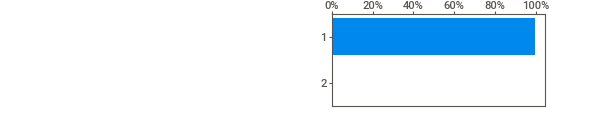
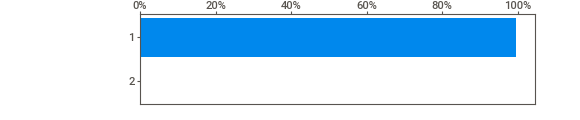
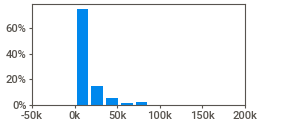
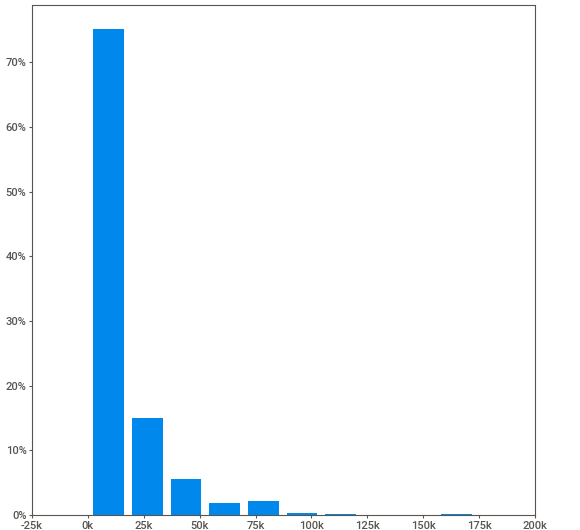
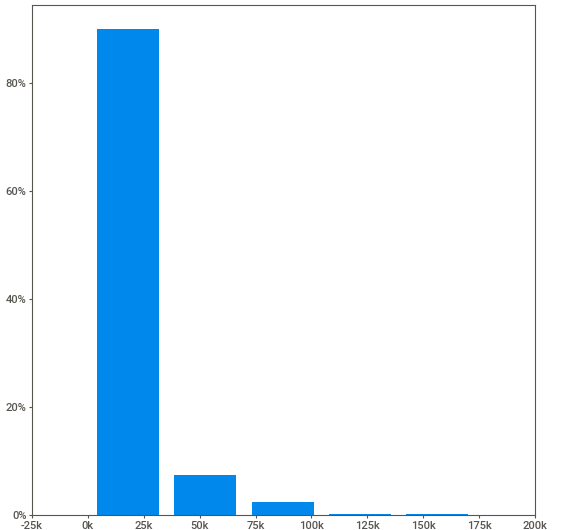
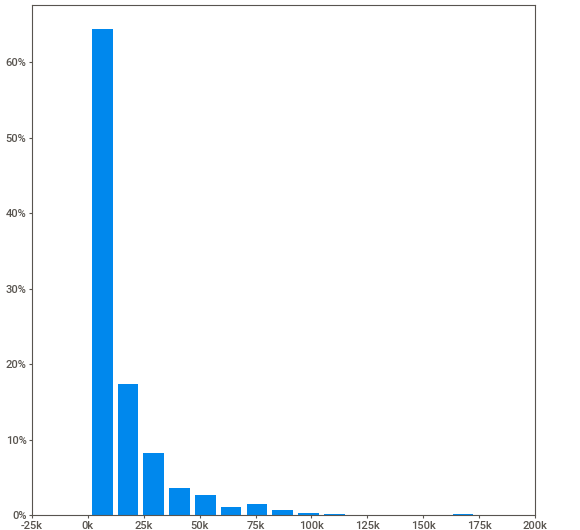
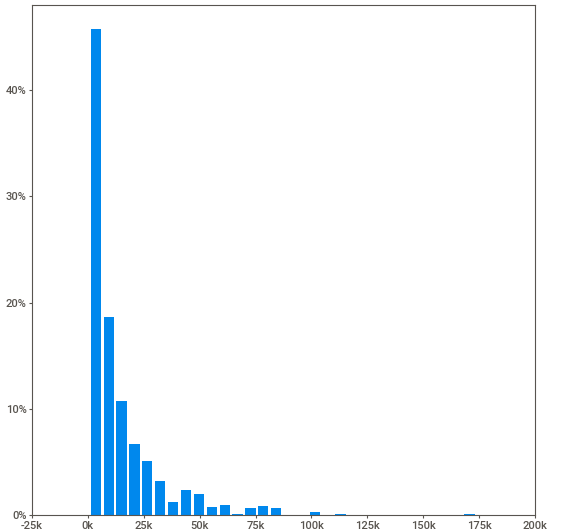
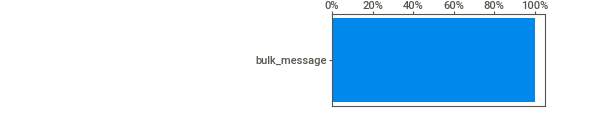
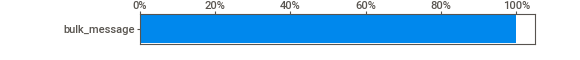
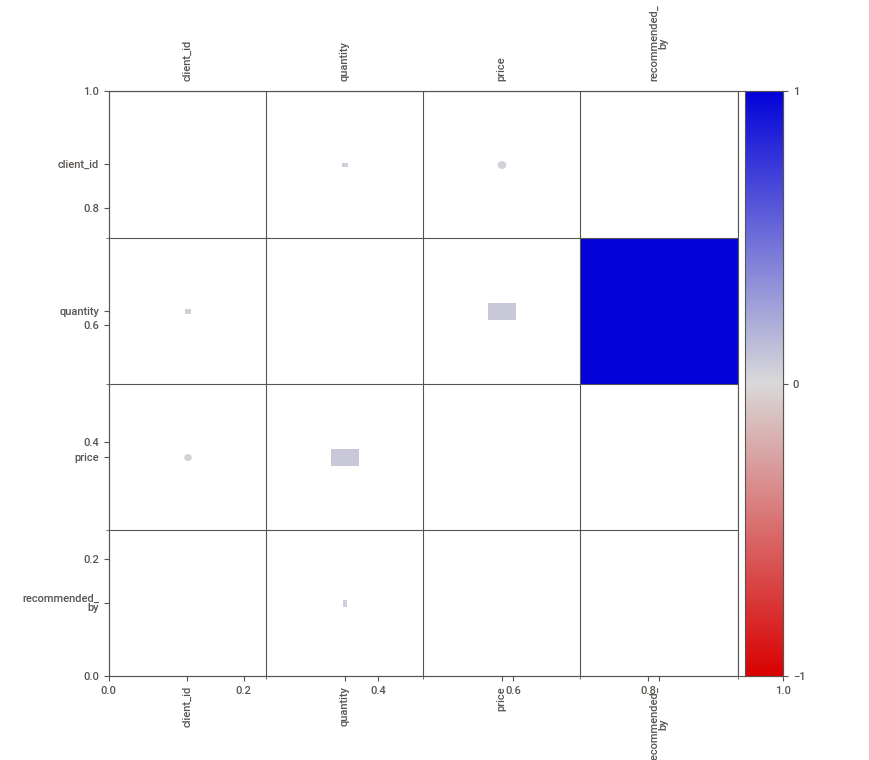
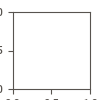

In [204]:
report_g = sv.analyze(df_g)
report_g.show_notebook()

In [205]:
data_g = df_preparation_g(df_g)

interval columns not set, guessing: ['date', 'unique_count', 'common_sum', 'A', 'B', 'C', 'D', 'E', 'F', 'target', 'weekend']


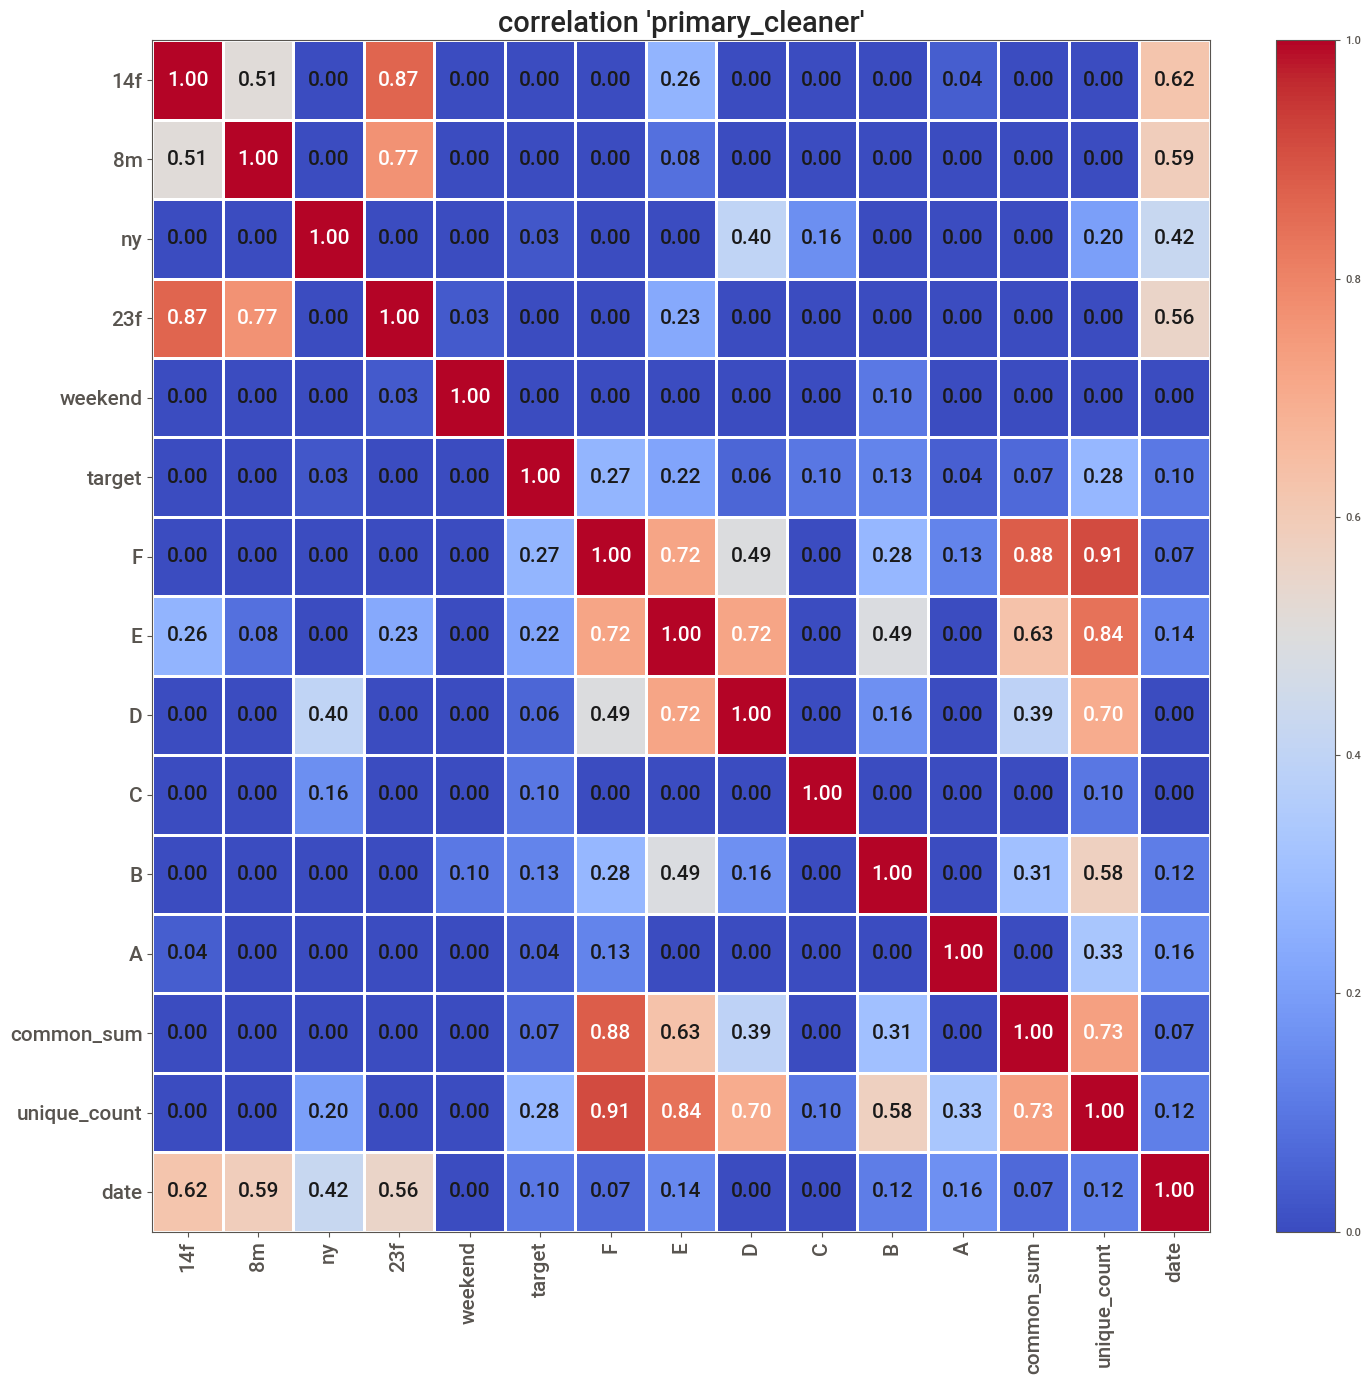

In [206]:
phik_overview = data_g.drop(['client_id','message_id'],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='coolwarm',
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

interval columns not set, guessing: ['target']


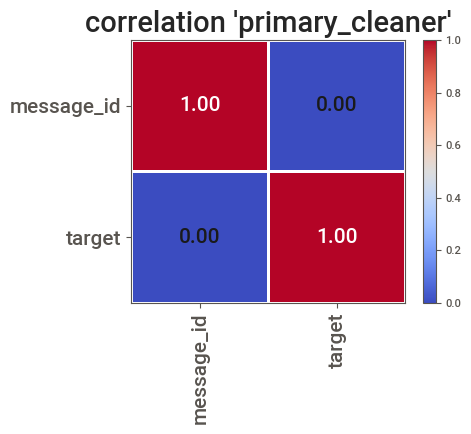

In [207]:
phik_overview = data_g[['target','message_id']].phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='coolwarm',
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(5, 4.5))

In [218]:
data_g = data_g.drop(['client_id','message_id'],axis=1)

#### Заключение по предварительному анализу <a class="anchor" id="section_1_2_1"></a>

В ходе предобработки данных были удалены поля: 'client_id','message_id','recommended_by' (из-за нулейвой корреляции). Таблица была преобразована к следующему виду.

- date - месяц
- unique_count - количество уникальных позиций в заказе
- common_sum - общая сумма
- [A B C	D E	F] - количество товаров в чеке (купленных за один день) для каждой ценовой категории
- target - целевой признак 
- weekend - выходной ли день
- 23f - период до 23 февраля
- ny - период до нового года
- 8m - период до 28 марта
- 14f - период до 14 февраля

## Подготовка выборок <a class="anchor" id="chapter2"></a>

Подготовим выборки для обучения, валидации и тестирования. Из-за ограничения мощностей не будем использовать кросс валидацию.
Соотношение выборок возьмем 70%, 15% и 15% соответственно.

Числовые значения будем маштабировать StandartScaler.

Как оговорено ранее, данных немного, поэтому подготовим два подхода один с объединенным DataFrame: data_c = data_a + data_m. И подготовим данные с раздельными выборками. data_g слишком сильно отличается от предыдущих, что видно из средних и распределения данных.

**Рассмотрим общую выборку**

In [582]:
data_c = pd.concat([data_a, data_m]).reset_index()
data_c = data_c.drop('index',axis=1)
columns_c = ['date','23f','ny','8m','14f']
columns_n = data_c.drop(['date','23f','ny','8m','14f','target'],axis=1).columns.to_list()

In [590]:
def feature_creater(data, columns_c, columns_n):
    """Функция возвращает выборки для обучения модели"""
    RANDOM_STATE = 123
    target = data['target'] 
    feature = data.drop('target',axis=1)
    x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.3,
                                                        random_state=RANDOM_STATE, stratify=target)
    x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5,
                                                        random_state=RANDOM_STATE, stratify=y_test)
    scaler = StandardScaler()
    x_train[columns_n] = scaler.fit_transform(x_train[columns_n])
    x_test[columns_n] = scaler.transform(x_test[columns_n])
    x_valid[columns_n] = scaler.transform(x_valid[columns_n])
    """oe = make_column_transformer(
        (OneHotEncoder(), columns_c),
         remainder='drop',)
    x_train = oe.fit_transform(x_train)
    x_test = oe.transform(x_test)
    x_valid = oe.transform(x_valid)"""
    return {'x_train': x_train, 'x_valid': x_valid, 'x_test': x_test, 
            'y_train': y_train, 'y_valid': y_valid, 'y_test': y_test}

In [591]:
xy_c = feature_creater(data_c,columns_c, columns_n) # совместная выборка
xy_a = feature_creater(data_a, columns_c, columns_n) # выборка Apparel
xy_m = feature_creater(data_m, columns_c, columns_n) # выборка Marketplace
xy_g = feature_creater(data_g, columns_c, columns_n) # выборка Gifts

## Обучение моделей <a class="anchor" id="chapter3"></a>

Моделями для бинарной классификации выбран  CatBoostClassifier. Метрикой для обучения выбрана roc-auc и precision

### CatBoostClassifier,  общая выборка <a class="anchor" id="section_3_2"></a>

In [607]:
model_cb = CatBoostClassifier(loss_function='Logloss',early_stopping_rounds=20,
                              iterations=1000,random_seed=seed, eval_metric='AUC')
grid = {'learning_rate': [0.05, 0.1, 0.2],
        'depth': [7,10,15,20],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
       }
train_pool = Pool(xy_c['x_train'], xy_c['y_train'],cat_features=columns_c)
grid_cb = model_cb.grid_search(grid,
                               train_pool)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.5186369	best: 0.5186369 (0)	total: 378ms	remaining: 6m 18s
1:	test: 0.5764071	best: 0.5764071 (1)	total: 481ms	remaining: 4m
2:	test: 0.6043769	best: 0.6043769 (2)	total: 723ms	remaining: 4m
3:	test: 0.6065586	best: 0.6065586 (3)	total: 886ms	remaining: 3m 40s
4:	test: 0.6137672	best: 0.6137672 (4)	total: 1.01s	remaining: 3m 22s
5:	test: 0.6154240	best: 0.6154240 (5)	total: 1.2s	remaining: 3m 19s
6:	test: 0.6160444	best: 0.6160444 (6)	total: 1.34s	remaining: 3m 10s
7:	test: 0.6166176	best: 0.6166176 (7)	total: 1.43s	remaining: 2m 57s
8:	test: 0.6166176	best: 0.6166176 (7)	total: 1.46s	remaining: 2m 40s
9:	test: 0.6168965	best: 0.6168965 (9)	total: 1.58s	remaining: 2m 36s
10:	test: 0.6177382	best: 0.6177382 (10)	total: 1.7s	remaining: 2m 32s
11:	test: 0.6210885	best: 0.6210885 (11)	total: 1.83s	remaining: 2m 30s
12:	test: 0.6203132	best: 0.6210885 (11)	total: 1.94s	remaining: 2m 27s
13:	test: 0.6202328	best: 0.6210885 (11)	total: 2.04s	remaining: 2m 23s
14:	test: 0.6200202	be

115:	test: 0.6626985	best: 0.6626985 (115)	total: 12s	remaining: 1m 31s
116:	test: 0.6626985	best: 0.6626985 (115)	total: 12.1s	remaining: 1m 31s
117:	test: 0.6628244	best: 0.6628244 (117)	total: 12.2s	remaining: 1m 31s
118:	test: 0.6628265	best: 0.6628265 (118)	total: 12.3s	remaining: 1m 31s
119:	test: 0.6627583	best: 0.6628265 (118)	total: 12.4s	remaining: 1m 31s
120:	test: 0.6627298	best: 0.6628265 (118)	total: 12.5s	remaining: 1m 31s
121:	test: 0.6627232	best: 0.6628265 (118)	total: 12.6s	remaining: 1m 30s
122:	test: 0.6627803	best: 0.6628265 (118)	total: 12.7s	remaining: 1m 30s
123:	test: 0.6632009	best: 0.6632009 (123)	total: 12.8s	remaining: 1m 30s
124:	test: 0.6632009	best: 0.6632009 (123)	total: 12.9s	remaining: 1m 30s
125:	test: 0.6635340	best: 0.6635340 (125)	total: 13s	remaining: 1m 30s
126:	test: 0.6635327	best: 0.6635340 (125)	total: 13.1s	remaining: 1m 29s
127:	test: 0.6635617	best: 0.6635617 (127)	total: 13.1s	remaining: 1m 29s
128:	test: 0.6635702	best: 0.6635702 (128)

64:	test: 0.6621274	best: 0.6621274 (64)	total: 6.14s	remaining: 1m 28s
65:	test: 0.6619222	best: 0.6621274 (64)	total: 6.25s	remaining: 1m 28s
66:	test: 0.6618263	best: 0.6621274 (64)	total: 6.34s	remaining: 1m 28s
67:	test: 0.6620294	best: 0.6621274 (64)	total: 6.45s	remaining: 1m 28s
68:	test: 0.6620375	best: 0.6621274 (64)	total: 6.5s	remaining: 1m 27s
69:	test: 0.6622703	best: 0.6622703 (69)	total: 6.61s	remaining: 1m 27s
70:	test: 0.6624980	best: 0.6624980 (70)	total: 6.73s	remaining: 1m 28s
71:	test: 0.6623680	best: 0.6624980 (70)	total: 6.82s	remaining: 1m 27s
72:	test: 0.6629150	best: 0.6629150 (72)	total: 6.92s	remaining: 1m 27s
73:	test: 0.6629293	best: 0.6629293 (73)	total: 7.01s	remaining: 1m 27s
74:	test: 0.6625641	best: 0.6629293 (73)	total: 7.12s	remaining: 1m 27s
75:	test: 0.6627019	best: 0.6629293 (73)	total: 7.17s	remaining: 1m 27s
76:	test: 0.6626350	best: 0.6629293 (73)	total: 7.27s	remaining: 1m 27s
77:	test: 0.6626086	best: 0.6629293 (73)	total: 7.38s	remaining: 

177:	test: 0.6707886	best: 0.6708052 (176)	total: 18.1s	remaining: 1m 23s
178:	test: 0.6708029	best: 0.6708052 (176)	total: 18.2s	remaining: 1m 23s
179:	test: 0.6708236	best: 0.6708236 (179)	total: 18.4s	remaining: 1m 23s
180:	test: 0.6712294	best: 0.6712294 (180)	total: 18.5s	remaining: 1m 23s
181:	test: 0.6710457	best: 0.6712294 (180)	total: 18.6s	remaining: 1m 23s
182:	test: 0.6709640	best: 0.6712294 (180)	total: 18.7s	remaining: 1m 23s
183:	test: 0.6713649	best: 0.6713649 (183)	total: 18.8s	remaining: 1m 23s
184:	test: 0.6713553	best: 0.6713649 (183)	total: 18.9s	remaining: 1m 23s
185:	test: 0.6712043	best: 0.6713649 (183)	total: 19s	remaining: 1m 23s
186:	test: 0.6712824	best: 0.6713649 (183)	total: 19.1s	remaining: 1m 23s
187:	test: 0.6710922	best: 0.6713649 (183)	total: 19.2s	remaining: 1m 23s
188:	test: 0.6711633	best: 0.6713649 (183)	total: 19.4s	remaining: 1m 23s
189:	test: 0.6715597	best: 0.6715597 (189)	total: 19.5s	remaining: 1m 23s
190:	test: 0.6714446	best: 0.6715597 (18

77:	test: 0.6661581	best: 0.6664393 (57)	total: 7.72s	remaining: 1m 31s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6664392767
bestIteration = 57

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.6664393	best: 0.6715597 (1)	total: 46.1s	remaining: 14m 36s
0:	test: 0.5185721	best: 0.5185721 (0)	total: 102ms	remaining: 1m 41s
1:	test: 0.5770965	best: 0.5770965 (1)	total: 236ms	remaining: 1m 57s
2:	test: 0.6041022	best: 0.6041022 (2)	total: 335ms	remaining: 1m 51s
3:	test: 0.6062868	best: 0.6062868 (3)	total: 449ms	remaining: 1m 51s
4:	test: 0.6135361	best: 0.6135361 (4)	total: 571ms	remaining: 1m 53s
5:	test: 0.6152556	best: 0.6152556 (5)	total: 687ms	remaining: 1m 53s
6:	test: 0.6159985	best: 0.6159985 (6)	total: 793ms	remaining: 1m 52s
7:	test: 0.6164647	best: 0.6164647 (7)	total: 880ms	remaining: 1m 49s
8:	test: 0.6164647	best: 0.6164647 (7)	total: 900ms	remaining: 1

111:	test: 0.6640654	best: 0.6641377 (108)	total: 11s	remaining: 1m 27s
112:	test: 0.6641445	best: 0.6641445 (112)	total: 11.1s	remaining: 1m 27s
113:	test: 0.6640604	best: 0.6641445 (112)	total: 11.2s	remaining: 1m 27s
114:	test: 0.6641242	best: 0.6641445 (112)	total: 11.3s	remaining: 1m 27s
115:	test: 0.6641731	best: 0.6641731 (115)	total: 11.4s	remaining: 1m 26s
116:	test: 0.6642230	best: 0.6642230 (116)	total: 11.5s	remaining: 1m 26s
117:	test: 0.6643639	best: 0.6643639 (117)	total: 11.6s	remaining: 1m 26s
118:	test: 0.6642874	best: 0.6643639 (117)	total: 11.7s	remaining: 1m 26s
119:	test: 0.6642130	best: 0.6643639 (117)	total: 11.7s	remaining: 1m 25s
120:	test: 0.6641931	best: 0.6643639 (117)	total: 11.8s	remaining: 1m 25s
121:	test: 0.6643928	best: 0.6643928 (121)	total: 11.9s	remaining: 1m 25s
122:	test: 0.6644931	best: 0.6644931 (122)	total: 12s	remaining: 1m 25s
123:	test: 0.6645362	best: 0.6645362 (123)	total: 12.1s	remaining: 1m 25s
124:	test: 0.6647394	best: 0.6647394 (124)

224:	test: 0.6686606	best: 0.6687994 (220)	total: 22.7s	remaining: 1m 18s
225:	test: 0.6686674	best: 0.6687994 (220)	total: 22.8s	remaining: 1m 18s
226:	test: 0.6687098	best: 0.6687994 (220)	total: 22.9s	remaining: 1m 18s
227:	test: 0.6687488	best: 0.6687994 (220)	total: 23s	remaining: 1m 18s
228:	test: 0.6686252	best: 0.6687994 (220)	total: 23.2s	remaining: 1m 17s
229:	test: 0.6684608	best: 0.6687994 (220)	total: 23.3s	remaining: 1m 17s
230:	test: 0.6684767	best: 0.6687994 (220)	total: 23.4s	remaining: 1m 17s
231:	test: 0.6686609	best: 0.6687994 (220)	total: 23.5s	remaining: 1m 17s
232:	test: 0.6687073	best: 0.6687994 (220)	total: 23.6s	remaining: 1m 17s
233:	test: 0.6687614	best: 0.6687994 (220)	total: 23.7s	remaining: 1m 17s
234:	test: 0.6687235	best: 0.6687994 (220)	total: 23.8s	remaining: 1m 17s
235:	test: 0.6687024	best: 0.6687994 (220)	total: 23.9s	remaining: 1m 17s
236:	test: 0.6686725	best: 0.6687994 (220)	total: 24s	remaining: 1m 17s
237:	test: 0.6689125	best: 0.6689125 (237)

47:	test: 0.6591290	best: 0.6593024 (46)	total: 4.56s	remaining: 1m 30s
48:	test: 0.6589242	best: 0.6593024 (46)	total: 4.66s	remaining: 1m 30s
49:	test: 0.6589783	best: 0.6593024 (46)	total: 4.74s	remaining: 1m 30s
50:	test: 0.6591138	best: 0.6593024 (46)	total: 4.84s	remaining: 1m 30s
51:	test: 0.6590917	best: 0.6593024 (46)	total: 4.93s	remaining: 1m 29s
52:	test: 0.6590917	best: 0.6593024 (46)	total: 4.99s	remaining: 1m 29s
53:	test: 0.6591621	best: 0.6593024 (46)	total: 5.12s	remaining: 1m 29s
54:	test: 0.6595963	best: 0.6595963 (54)	total: 5.24s	remaining: 1m 29s
55:	test: 0.6596423	best: 0.6596423 (55)	total: 5.33s	remaining: 1m 29s
56:	test: 0.6596155	best: 0.6596423 (55)	total: 5.44s	remaining: 1m 30s
57:	test: 0.6596763	best: 0.6596763 (57)	total: 5.54s	remaining: 1m 29s
58:	test: 0.6598350	best: 0.6598350 (58)	total: 5.65s	remaining: 1m 30s
59:	test: 0.6600325	best: 0.6600325 (59)	total: 5.77s	remaining: 1m 30s
60:	test: 0.6604864	best: 0.6604864 (60)	total: 5.88s	remaining:

160:	test: 0.6678292	best: 0.6678292 (160)	total: 15.9s	remaining: 1m 22s
161:	test: 0.6683318	best: 0.6683318 (161)	total: 16s	remaining: 1m 22s
162:	test: 0.6683950	best: 0.6683950 (162)	total: 16.1s	remaining: 1m 22s
163:	test: 0.6682071	best: 0.6683950 (162)	total: 16.2s	remaining: 1m 22s
164:	test: 0.6682002	best: 0.6683950 (162)	total: 16.3s	remaining: 1m 22s
165:	test: 0.6682306	best: 0.6683950 (162)	total: 16.4s	remaining: 1m 22s
166:	test: 0.6684221	best: 0.6684221 (166)	total: 16.5s	remaining: 1m 22s
167:	test: 0.6684356	best: 0.6684356 (167)	total: 16.6s	remaining: 1m 22s
168:	test: 0.6685092	best: 0.6685092 (168)	total: 16.8s	remaining: 1m 22s
169:	test: 0.6684430	best: 0.6685092 (168)	total: 16.9s	remaining: 1m 22s
170:	test: 0.6683729	best: 0.6685092 (168)	total: 17s	remaining: 1m 22s
171:	test: 0.6683579	best: 0.6685092 (168)	total: 17.1s	remaining: 1m 22s
172:	test: 0.6682800	best: 0.6685092 (168)	total: 17.2s	remaining: 1m 22s
173:	test: 0.6683164	best: 0.6685092 (168)

37:	test: 0.6631180	best: 0.6632153 (36)	total: 3.77s	remaining: 1m 35s
38:	test: 0.6631965	best: 0.6632153 (36)	total: 3.87s	remaining: 1m 35s
39:	test: 0.6635519	best: 0.6635519 (39)	total: 3.96s	remaining: 1m 35s
40:	test: 0.6637539	best: 0.6637539 (40)	total: 4.07s	remaining: 1m 35s
41:	test: 0.6635094	best: 0.6637539 (40)	total: 4.17s	remaining: 1m 35s
42:	test: 0.6637469	best: 0.6637539 (40)	total: 4.29s	remaining: 1m 35s
43:	test: 0.6637469	best: 0.6637539 (40)	total: 4.35s	remaining: 1m 34s
44:	test: 0.6640256	best: 0.6640256 (44)	total: 4.45s	remaining: 1m 34s
45:	test: 0.6643523	best: 0.6643523 (45)	total: 4.57s	remaining: 1m 34s
46:	test: 0.6635560	best: 0.6643523 (45)	total: 4.69s	remaining: 1m 35s
47:	test: 0.6634895	best: 0.6643523 (45)	total: 4.81s	remaining: 1m 35s
48:	test: 0.6637319	best: 0.6643523 (45)	total: 4.91s	remaining: 1m 35s
49:	test: 0.6638593	best: 0.6643523 (45)	total: 5.01s	remaining: 1m 35s
50:	test: 0.6638700	best: 0.6643523 (45)	total: 5.1s	remaining: 

63:	test: 0.6574958	best: 0.6574958 (63)	total: 5.65s	remaining: 1m 22s
64:	test: 0.6592640	best: 0.6592640 (64)	total: 5.76s	remaining: 1m 22s
65:	test: 0.6596551	best: 0.6596551 (65)	total: 5.89s	remaining: 1m 23s
66:	test: 0.6596551	best: 0.6596551 (65)	total: 5.91s	remaining: 1m 22s
67:	test: 0.6596747	best: 0.6596747 (67)	total: 6.04s	remaining: 1m 22s
68:	test: 0.6595684	best: 0.6596747 (67)	total: 6.17s	remaining: 1m 23s
69:	test: 0.6595159	best: 0.6596747 (67)	total: 6.28s	remaining: 1m 23s
70:	test: 0.6601083	best: 0.6601083 (70)	total: 6.41s	remaining: 1m 23s
71:	test: 0.6603670	best: 0.6603670 (71)	total: 6.52s	remaining: 1m 24s
72:	test: 0.6605860	best: 0.6605860 (72)	total: 6.61s	remaining: 1m 23s
73:	test: 0.6604438	best: 0.6605860 (72)	total: 6.71s	remaining: 1m 24s
74:	test: 0.6604851	best: 0.6605860 (72)	total: 6.81s	remaining: 1m 23s
75:	test: 0.6604242	best: 0.6605860 (72)	total: 6.9s	remaining: 1m 23s
76:	test: 0.6609920	best: 0.6609920 (76)	total: 7s	remaining: 1m 

177:	test: 0.6658532	best: 0.6658532 (177)	total: 16.5s	remaining: 1m 16s
178:	test: 0.6658598	best: 0.6658598 (178)	total: 16.6s	remaining: 1m 16s
179:	test: 0.6658546	best: 0.6658598 (178)	total: 16.8s	remaining: 1m 16s
180:	test: 0.6658574	best: 0.6658598 (178)	total: 16.8s	remaining: 1m 16s
181:	test: 0.6658939	best: 0.6658939 (181)	total: 16.9s	remaining: 1m 16s
182:	test: 0.6658709	best: 0.6658939 (181)	total: 17s	remaining: 1m 16s
183:	test: 0.6659592	best: 0.6659592 (183)	total: 17.1s	remaining: 1m 16s
184:	test: 0.6661935	best: 0.6661935 (184)	total: 17.2s	remaining: 1m 15s
185:	test: 0.6662342	best: 0.6662342 (185)	total: 17.4s	remaining: 1m 15s
186:	test: 0.6662240	best: 0.6662342 (185)	total: 17.5s	remaining: 1m 15s
187:	test: 0.6662314	best: 0.6662342 (185)	total: 17.6s	remaining: 1m 15s
188:	test: 0.6662314	best: 0.6662342 (185)	total: 17.6s	remaining: 1m 15s
189:	test: 0.6662289	best: 0.6662342 (185)	total: 17.7s	remaining: 1m 15s
190:	test: 0.6662768	best: 0.6662768 (19

289:	test: 0.6696699	best: 0.6696699 (289)	total: 28s	remaining: 1m 8s
290:	test: 0.6696901	best: 0.6696901 (290)	total: 28.2s	remaining: 1m 8s
291:	test: 0.6696972	best: 0.6696972 (291)	total: 28.3s	remaining: 1m 8s
292:	test: 0.6696547	best: 0.6696972 (291)	total: 28.4s	remaining: 1m 8s
293:	test: 0.6696223	best: 0.6696972 (291)	total: 28.5s	remaining: 1m 8s
294:	test: 0.6695152	best: 0.6696972 (291)	total: 28.6s	remaining: 1m 8s
295:	test: 0.6696368	best: 0.6696972 (291)	total: 28.7s	remaining: 1m 8s
296:	test: 0.6696440	best: 0.6696972 (291)	total: 28.8s	remaining: 1m 8s
297:	test: 0.6697265	best: 0.6697265 (297)	total: 29s	remaining: 1m 8s
298:	test: 0.6697342	best: 0.6697342 (298)	total: 29.1s	remaining: 1m 8s
299:	test: 0.6696723	best: 0.6697342 (298)	total: 29.2s	remaining: 1m 8s
300:	test: 0.6697183	best: 0.6697342 (298)	total: 29.3s	remaining: 1m 7s
301:	test: 0.6697970	best: 0.6697970 (301)	total: 29.4s	remaining: 1m 7s
302:	test: 0.6698052	best: 0.6698052 (302)	total: 29.5s

76:	test: 0.6638056	best: 0.6640492 (73)	total: 7.4s	remaining: 1m 28s
77:	test: 0.6639631	best: 0.6640492 (73)	total: 7.52s	remaining: 1m 28s
78:	test: 0.6640261	best: 0.6640492 (73)	total: 7.65s	remaining: 1m 29s
79:	test: 0.6641465	best: 0.6641465 (79)	total: 7.76s	remaining: 1m 29s
80:	test: 0.6640469	best: 0.6641465 (79)	total: 7.88s	remaining: 1m 29s
81:	test: 0.6640018	best: 0.6641465 (79)	total: 7.97s	remaining: 1m 29s
82:	test: 0.6637428	best: 0.6641465 (79)	total: 8.06s	remaining: 1m 29s
83:	test: 0.6642544	best: 0.6642544 (83)	total: 8.18s	remaining: 1m 29s
84:	test: 0.6643177	best: 0.6643177 (84)	total: 8.27s	remaining: 1m 29s
85:	test: 0.6643358	best: 0.6643358 (85)	total: 8.4s	remaining: 1m 29s
86:	test: 0.6643386	best: 0.6643386 (86)	total: 8.47s	remaining: 1m 28s
87:	test: 0.6647388	best: 0.6647388 (87)	total: 8.57s	remaining: 1m 28s
88:	test: 0.6646904	best: 0.6647388 (87)	total: 8.68s	remaining: 1m 28s
89:	test: 0.6646817	best: 0.6647388 (87)	total: 8.78s	remaining: 1

30:	test: 0.6619635	best: 0.6619635 (28)	total: 2.88s	remaining: 1m 30s
31:	test: 0.6616128	best: 0.6619635 (28)	total: 2.99s	remaining: 1m 30s
32:	test: 0.6618282	best: 0.6619635 (28)	total: 3.1s	remaining: 1m 30s
33:	test: 0.6614980	best: 0.6619635 (28)	total: 3.17s	remaining: 1m 30s
34:	test: 0.6619197	best: 0.6619635 (28)	total: 3.28s	remaining: 1m 30s
35:	test: 0.6619737	best: 0.6619737 (35)	total: 3.36s	remaining: 1m 29s
36:	test: 0.6618573	best: 0.6619737 (35)	total: 3.47s	remaining: 1m 30s
37:	test: 0.6620812	best: 0.6620812 (37)	total: 3.57s	remaining: 1m 30s
38:	test: 0.6620735	best: 0.6620812 (37)	total: 3.62s	remaining: 1m 29s
39:	test: 0.6620680	best: 0.6620812 (37)	total: 3.71s	remaining: 1m 29s
40:	test: 0.6619657	best: 0.6620812 (37)	total: 3.74s	remaining: 1m 27s
41:	test: 0.6614089	best: 0.6620812 (37)	total: 3.85s	remaining: 1m 27s
42:	test: 0.6616276	best: 0.6620812 (37)	total: 3.97s	remaining: 1m 28s
43:	test: 0.6619409	best: 0.6620812 (37)	total: 4.07s	remaining: 

16:	test: 0.6194368	best: 0.6206816 (11)	total: 1.54s	remaining: 1m 29s
17:	test: 0.6193658	best: 0.6206816 (11)	total: 1.6s	remaining: 1m 27s
18:	test: 0.6190919	best: 0.6206816 (11)	total: 1.7s	remaining: 1m 27s
19:	test: 0.6204590	best: 0.6206816 (11)	total: 1.8s	remaining: 1m 28s
20:	test: 0.6203962	best: 0.6206816 (11)	total: 1.9s	remaining: 1m 28s
21:	test: 0.6347479	best: 0.6347479 (21)	total: 1.99s	remaining: 1m 28s
22:	test: 0.6351889	best: 0.6351889 (22)	total: 2.1s	remaining: 1m 29s
23:	test: 0.6349639	best: 0.6351889 (22)	total: 2.2s	remaining: 1m 29s
24:	test: 0.6349150	best: 0.6351889 (22)	total: 2.23s	remaining: 1m 27s
25:	test: 0.6351160	best: 0.6351889 (22)	total: 2.33s	remaining: 1m 27s
26:	test: 0.6351324	best: 0.6351889 (22)	total: 2.38s	remaining: 1m 25s
27:	test: 0.6380369	best: 0.6380369 (27)	total: 2.44s	remaining: 1m 24s
28:	test: 0.6380757	best: 0.6380757 (28)	total: 2.48s	remaining: 1m 22s
29:	test: 0.6365401	best: 0.6380757 (28)	total: 2.57s	remaining: 1m 23

130:	test: 0.6637965	best: 0.6637965 (130)	total: 12.2s	remaining: 1m 20s
131:	test: 0.6637756	best: 0.6637965 (130)	total: 12.3s	remaining: 1m 20s
132:	test: 0.6637800	best: 0.6637965 (130)	total: 12.3s	remaining: 1m 20s
133:	test: 0.6637218	best: 0.6637965 (130)	total: 12.5s	remaining: 1m 20s
134:	test: 0.6636900	best: 0.6637965 (130)	total: 12.6s	remaining: 1m 20s
135:	test: 0.6636927	best: 0.6637965 (130)	total: 12.7s	remaining: 1m 20s
136:	test: 0.6638251	best: 0.6638251 (136)	total: 12.8s	remaining: 1m 20s
137:	test: 0.6638288	best: 0.6638288 (137)	total: 12.9s	remaining: 1m 20s
138:	test: 0.6638975	best: 0.6638975 (138)	total: 13s	remaining: 1m 20s
139:	test: 0.6640793	best: 0.6640793 (139)	total: 13.1s	remaining: 1m 20s
140:	test: 0.6641829	best: 0.6641829 (140)	total: 13.2s	remaining: 1m 20s
141:	test: 0.6641829	best: 0.6641829 (140)	total: 13.2s	remaining: 1m 19s
142:	test: 0.6643242	best: 0.6643242 (142)	total: 13.3s	remaining: 1m 19s
143:	test: 0.6642763	best: 0.6643242 (14

56:	test: 0.6629536	best: 0.6630364 (54)	total: 5.11s	remaining: 1m 24s
57:	test: 0.6626733	best: 0.6630364 (54)	total: 5.2s	remaining: 1m 24s
58:	test: 0.6635020	best: 0.6635020 (58)	total: 5.31s	remaining: 1m 24s
59:	test: 0.6634713	best: 0.6635020 (58)	total: 5.41s	remaining: 1m 24s
60:	test: 0.6632702	best: 0.6635020 (58)	total: 5.51s	remaining: 1m 24s
61:	test: 0.6633107	best: 0.6635020 (58)	total: 5.58s	remaining: 1m 24s
62:	test: 0.6634636	best: 0.6635020 (58)	total: 5.68s	remaining: 1m 24s
63:	test: 0.6638188	best: 0.6638188 (63)	total: 5.8s	remaining: 1m 24s
64:	test: 0.6637787	best: 0.6638188 (63)	total: 5.92s	remaining: 1m 25s
65:	test: 0.6637384	best: 0.6638188 (63)	total: 6.04s	remaining: 1m 25s
66:	test: 0.6638850	best: 0.6638850 (66)	total: 6.15s	remaining: 1m 25s
67:	test: 0.6638473	best: 0.6638850 (66)	total: 6.25s	remaining: 1m 25s
68:	test: 0.6637588	best: 0.6638850 (66)	total: 6.37s	remaining: 1m 25s
69:	test: 0.6637583	best: 0.6638850 (66)	total: 6.43s	remaining: 1

170:	test: 0.6693465	best: 0.6695835 (155)	total: 16.5s	remaining: 1m 19s
171:	test: 0.6691875	best: 0.6695835 (155)	total: 16.6s	remaining: 1m 19s
172:	test: 0.6691890	best: 0.6695835 (155)	total: 16.7s	remaining: 1m 19s
173:	test: 0.6691444	best: 0.6695835 (155)	total: 16.8s	remaining: 1m 19s
174:	test: 0.6692433	best: 0.6695835 (155)	total: 16.9s	remaining: 1m 19s
175:	test: 0.6693504	best: 0.6695835 (155)	total: 17s	remaining: 1m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6695834946
bestIteration = 155

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
10:	loss: 0.6695835	best: 0.6715597 (1)	total: 3m 22s	remaining: 15m 3s
0:	test: 0.5186748	best: 0.5186748 (0)	total: 95.7ms	remaining: 1m 35s
1:	test: 0.5769673	best: 0.5769673 (1)	total: 197ms	remaining: 1m 38s
2:	test: 0.6039309	best: 0.6039309 (2)	total: 294ms	remaining: 1m 37s
3:	test: 0.6361691	best: 0.6361691 (3)	to

105:	test: 0.6715503	best: 0.6719767 (86)	total: 10.6s	remaining: 1m 29s
106:	test: 0.6718637	best: 0.6719767 (86)	total: 10.7s	remaining: 1m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6719766838
bestIteration = 86

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
11:	loss: 0.6719767	best: 0.6719767 (11)	total: 3m 33s	remaining: 14m 14s
0:	test: 0.5187111	best: 0.5187111 (0)	total: 96.5ms	remaining: 1m 36s
1:	test: 0.5768383	best: 0.5768383 (1)	total: 194ms	remaining: 1m 36s
2:	test: 0.6039691	best: 0.6039691 (2)	total: 303ms	remaining: 1m 40s
3:	test: 0.6061154	best: 0.6061154 (3)	total: 416ms	remaining: 1m 43s
4:	test: 0.6133266	best: 0.6133266 (4)	total: 508ms	remaining: 1m 41s
5:	test: 0.6155035	best: 0.6155035 (5)	total: 602ms	remaining: 1m 39s
6:	test: 0.6160174	best: 0.6160174 (6)	total: 725ms	remaining: 1m 42s
7:	test: 0.6166329	best: 0.6166329 (7)	total: 810ms	rema

110:	test: 0.6638970	best: 0.6639173 (109)	total: 9.77s	remaining: 1m 18s
111:	test: 0.6638316	best: 0.6639173 (109)	total: 9.87s	remaining: 1m 18s
112:	test: 0.6638316	best: 0.6639173 (109)	total: 9.91s	remaining: 1m 17s
113:	test: 0.6636737	best: 0.6639173 (109)	total: 10s	remaining: 1m 17s
114:	test: 0.6636895	best: 0.6639173 (109)	total: 10.1s	remaining: 1m 18s
115:	test: 0.6636766	best: 0.6639173 (109)	total: 10.2s	remaining: 1m 17s
116:	test: 0.6636835	best: 0.6639173 (109)	total: 10.3s	remaining: 1m 17s
117:	test: 0.6636536	best: 0.6639173 (109)	total: 10.4s	remaining: 1m 17s
118:	test: 0.6637345	best: 0.6639173 (109)	total: 10.5s	remaining: 1m 17s
119:	test: 0.6638088	best: 0.6639173 (109)	total: 10.6s	remaining: 1m 18s
120:	test: 0.6638409	best: 0.6639173 (109)	total: 10.7s	remaining: 1m 18s
121:	test: 0.6638739	best: 0.6639173 (109)	total: 10.8s	remaining: 1m 18s
122:	test: 0.6637331	best: 0.6639173 (109)	total: 10.9s	remaining: 1m 18s
123:	test: 0.6639374	best: 0.6639374 (12

63:	test: 0.6641890	best: 0.6641890 (62)	total: 5.86s	remaining: 1m 25s
64:	test: 0.6646826	best: 0.6646826 (64)	total: 5.99s	remaining: 1m 26s
65:	test: 0.6645152	best: 0.6646826 (64)	total: 6.06s	remaining: 1m 25s
66:	test: 0.6647032	best: 0.6647032 (66)	total: 6.16s	remaining: 1m 25s
67:	test: 0.6647046	best: 0.6647046 (67)	total: 6.26s	remaining: 1m 25s
68:	test: 0.6646041	best: 0.6647046 (67)	total: 6.37s	remaining: 1m 25s
69:	test: 0.6646041	best: 0.6647046 (67)	total: 6.42s	remaining: 1m 25s
70:	test: 0.6649164	best: 0.6649164 (70)	total: 6.53s	remaining: 1m 25s
71:	test: 0.6648849	best: 0.6649164 (70)	total: 6.63s	remaining: 1m 25s
72:	test: 0.6654283	best: 0.6654283 (72)	total: 6.73s	remaining: 1m 25s
73:	test: 0.6653718	best: 0.6654283 (72)	total: 6.82s	remaining: 1m 25s
74:	test: 0.6652417	best: 0.6654283 (72)	total: 6.91s	remaining: 1m 25s
75:	test: 0.6653019	best: 0.6654283 (72)	total: 7.03s	remaining: 1m 25s
76:	test: 0.6655379	best: 0.6655379 (76)	total: 7.13s	remaining:

175:	test: 0.6703136	best: 0.6707061 (174)	total: 17.5s	remaining: 1m 22s
176:	test: 0.6703138	best: 0.6707061 (174)	total: 17.6s	remaining: 1m 21s
177:	test: 0.6704870	best: 0.6707061 (174)	total: 17.7s	remaining: 1m 21s
178:	test: 0.6706309	best: 0.6707061 (174)	total: 17.8s	remaining: 1m 21s
179:	test: 0.6710699	best: 0.6710699 (179)	total: 17.9s	remaining: 1m 21s
180:	test: 0.6710758	best: 0.6710758 (180)	total: 18s	remaining: 1m 21s
181:	test: 0.6709536	best: 0.6710758 (180)	total: 18.1s	remaining: 1m 21s
182:	test: 0.6709982	best: 0.6710758 (180)	total: 18.2s	remaining: 1m 21s
183:	test: 0.6709719	best: 0.6710758 (180)	total: 18.3s	remaining: 1m 21s
184:	test: 0.6708496	best: 0.6710758 (180)	total: 18.4s	remaining: 1m 21s
185:	test: 0.6708952	best: 0.6710758 (180)	total: 18.5s	remaining: 1m 21s
186:	test: 0.6709060	best: 0.6710758 (180)	total: 18.6s	remaining: 1m 20s
187:	test: 0.6708827	best: 0.6710758 (180)	total: 18.7s	remaining: 1m 20s
188:	test: 0.6708950	best: 0.6710758 (18

84:	test: 0.6658689	best: 0.6662360 (79)	total: 8.23s	remaining: 1m 28s
85:	test: 0.6661030	best: 0.6662360 (79)	total: 8.34s	remaining: 1m 28s
86:	test: 0.6666539	best: 0.6666539 (86)	total: 8.45s	remaining: 1m 28s
87:	test: 0.6672156	best: 0.6672156 (87)	total: 8.55s	remaining: 1m 28s
88:	test: 0.6675685	best: 0.6675685 (88)	total: 8.66s	remaining: 1m 28s
89:	test: 0.6677710	best: 0.6677710 (89)	total: 8.76s	remaining: 1m 28s
90:	test: 0.6677840	best: 0.6677840 (90)	total: 8.87s	remaining: 1m 28s
91:	test: 0.6679154	best: 0.6679154 (91)	total: 8.97s	remaining: 1m 28s
92:	test: 0.6679172	best: 0.6679172 (92)	total: 9.09s	remaining: 1m 28s
93:	test: 0.6680600	best: 0.6680600 (93)	total: 9.2s	remaining: 1m 28s
94:	test: 0.6686032	best: 0.6686032 (94)	total: 9.3s	remaining: 1m 28s
95:	test: 0.6686037	best: 0.6686037 (95)	total: 9.41s	remaining: 1m 28s
96:	test: 0.6686100	best: 0.6686100 (96)	total: 9.51s	remaining: 1m 28s
97:	test: 0.6687987	best: 0.6687987 (97)	total: 9.61s	remaining: 1

70:	test: 0.6618545	best: 0.6618545 (70)	total: 8.63s	remaining: 1m 52s
71:	test: 0.6619824	best: 0.6619824 (71)	total: 8.8s	remaining: 1m 53s
72:	test: 0.6618501	best: 0.6619824 (71)	total: 8.98s	remaining: 1m 54s
73:	test: 0.6619029	best: 0.6619824 (71)	total: 9.05s	remaining: 1m 53s
74:	test: 0.6620474	best: 0.6620474 (74)	total: 9.23s	remaining: 1m 53s
75:	test: 0.6619123	best: 0.6620474 (74)	total: 9.41s	remaining: 1m 54s
76:	test: 0.6619847	best: 0.6620474 (74)	total: 9.59s	remaining: 1m 55s
77:	test: 0.6615910	best: 0.6620474 (74)	total: 9.77s	remaining: 1m 55s
78:	test: 0.6615206	best: 0.6620474 (74)	total: 9.85s	remaining: 1m 54s
79:	test: 0.6613281	best: 0.6620474 (74)	total: 9.96s	remaining: 1m 54s
80:	test: 0.6612562	best: 0.6620474 (74)	total: 10.2s	remaining: 1m 55s
81:	test: 0.6611932	best: 0.6620474 (74)	total: 10.2s	remaining: 1m 54s
82:	test: 0.6611933	best: 0.6620474 (74)	total: 10.3s	remaining: 1m 53s
83:	test: 0.6613554	best: 0.6620474 (74)	total: 10.5s	remaining: 

183:	test: 0.6643950	best: 0.6646665 (165)	total: 23.9s	remaining: 1m 46s
184:	test: 0.6642808	best: 0.6646665 (165)	total: 24.1s	remaining: 1m 46s
185:	test: 0.6644430	best: 0.6646665 (165)	total: 24.3s	remaining: 1m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6646664738
bestIteration = 165

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
15:	loss: 0.6646665	best: 0.6719767 (11)	total: 4m 44s	remaining: 13m 3s
0:	test: 0.5184680	best: 0.5184680 (0)	total: 120ms	remaining: 2m
1:	test: 0.5956042	best: 0.5956042 (1)	total: 300ms	remaining: 2m 29s
2:	test: 0.6081665	best: 0.6081665 (2)	total: 452ms	remaining: 2m 30s
3:	test: 0.6131080	best: 0.6131080 (3)	total: 612ms	remaining: 2m 32s
4:	test: 0.6137656	best: 0.6137656 (4)	total: 721ms	remaining: 2m 23s
5:	test: 0.6137156	best: 0.6137656 (4)	total: 786ms	remaining: 2m 10s
6:	test: 0.6137156	best: 0.6137656 (4)	total: 803ms	rem

107:	test: 0.6684217	best: 0.6684217 (107)	total: 14.1s	remaining: 1m 56s
108:	test: 0.6685561	best: 0.6685561 (108)	total: 14.3s	remaining: 1m 56s
109:	test: 0.6684776	best: 0.6685561 (108)	total: 14.5s	remaining: 1m 57s
110:	test: 0.6684944	best: 0.6685561 (108)	total: 14.7s	remaining: 1m 57s
111:	test: 0.6679938	best: 0.6685561 (108)	total: 14.9s	remaining: 1m 57s
112:	test: 0.6677511	best: 0.6685561 (108)	total: 15.1s	remaining: 1m 58s
113:	test: 0.6680586	best: 0.6685561 (108)	total: 15.3s	remaining: 1m 58s
114:	test: 0.6678760	best: 0.6685561 (108)	total: 15.5s	remaining: 1m 59s
115:	test: 0.6682468	best: 0.6685561 (108)	total: 15.7s	remaining: 1m 59s
116:	test: 0.6684510	best: 0.6685561 (108)	total: 15.9s	remaining: 1m 59s
117:	test: 0.6683560	best: 0.6685561 (108)	total: 16.1s	remaining: 2m
118:	test: 0.6683676	best: 0.6685561 (108)	total: 16.3s	remaining: 2m
119:	test: 0.6685704	best: 0.6685704 (119)	total: 16.4s	remaining: 2m
120:	test: 0.6687838	best: 0.6687838 (120)	total: 

17:	test: 0.6355185	best: 0.6387531 (13)	total: 2.19s	remaining: 1m 59s
18:	test: 0.6355185	best: 0.6387531 (13)	total: 2.21s	remaining: 1m 54s
19:	test: 0.6343236	best: 0.6387531 (13)	total: 2.38s	remaining: 1m 56s
20:	test: 0.6343236	best: 0.6387531 (13)	total: 2.39s	remaining: 1m 51s
21:	test: 0.6335764	best: 0.6387531 (13)	total: 2.48s	remaining: 1m 50s
22:	test: 0.6336574	best: 0.6387531 (13)	total: 2.52s	remaining: 1m 47s
23:	test: 0.6342319	best: 0.6387531 (13)	total: 2.68s	remaining: 1m 49s
24:	test: 0.6343515	best: 0.6387531 (13)	total: 2.73s	remaining: 1m 46s
25:	test: 0.6393341	best: 0.6393341 (25)	total: 2.78s	remaining: 1m 44s
26:	test: 0.6393341	best: 0.6393341 (25)	total: 2.8s	remaining: 1m 41s
27:	test: 0.6381651	best: 0.6393341 (25)	total: 2.99s	remaining: 1m 43s
28:	test: 0.6380827	best: 0.6393341 (25)	total: 3.03s	remaining: 1m 41s
29:	test: 0.6433237	best: 0.6433237 (29)	total: 3.21s	remaining: 1m 43s
30:	test: 0.6432954	best: 0.6433237 (29)	total: 3.27s	remaining: 

131:	test: 0.6653149	best: 0.6653149 (131)	total: 16.7s	remaining: 1m 49s
132:	test: 0.6651974	best: 0.6653149 (131)	total: 16.8s	remaining: 1m 49s
133:	test: 0.6652109	best: 0.6653149 (131)	total: 17s	remaining: 1m 50s
134:	test: 0.6652109	best: 0.6653149 (131)	total: 17.1s	remaining: 1m 49s
135:	test: 0.6651946	best: 0.6653149 (131)	total: 17.2s	remaining: 1m 49s
136:	test: 0.6654735	best: 0.6654735 (136)	total: 17.4s	remaining: 1m 49s
137:	test: 0.6653560	best: 0.6654735 (136)	total: 17.5s	remaining: 1m 49s
138:	test: 0.6653443	best: 0.6654735 (136)	total: 17.6s	remaining: 1m 49s
139:	test: 0.6653443	best: 0.6654735 (136)	total: 17.6s	remaining: 1m 48s
140:	test: 0.6654017	best: 0.6654735 (136)	total: 17.8s	remaining: 1m 48s
141:	test: 0.6654331	best: 0.6654735 (136)	total: 17.9s	remaining: 1m 48s
142:	test: 0.6654063	best: 0.6654735 (136)	total: 17.9s	remaining: 1m 47s
143:	test: 0.6654543	best: 0.6654735 (136)	total: 18.1s	remaining: 1m 47s
144:	test: 0.6654038	best: 0.6654735 (13

244:	test: 0.6691530	best: 0.6693111 (242)	total: 34.3s	remaining: 1m 45s
245:	test: 0.6690028	best: 0.6693111 (242)	total: 34.5s	remaining: 1m 45s
246:	test: 0.6689147	best: 0.6693111 (242)	total: 34.7s	remaining: 1m 45s
247:	test: 0.6689625	best: 0.6693111 (242)	total: 34.9s	remaining: 1m 45s
248:	test: 0.6689884	best: 0.6693111 (242)	total: 35s	remaining: 1m 45s
249:	test: 0.6689970	best: 0.6693111 (242)	total: 35.2s	remaining: 1m 45s
250:	test: 0.6686895	best: 0.6693111 (242)	total: 35.4s	remaining: 1m 45s
251:	test: 0.6687370	best: 0.6693111 (242)	total: 35.6s	remaining: 1m 45s
252:	test: 0.6686896	best: 0.6693111 (242)	total: 35.8s	remaining: 1m 45s
253:	test: 0.6686134	best: 0.6693111 (242)	total: 36s	remaining: 1m 45s
254:	test: 0.6686336	best: 0.6693111 (242)	total: 36.2s	remaining: 1m 45s
255:	test: 0.6684895	best: 0.6693111 (242)	total: 36.3s	remaining: 1m 45s
256:	test: 0.6683816	best: 0.6693111 (242)	total: 36.5s	remaining: 1m 45s
257:	test: 0.6682982	best: 0.6693111 (242)

93:	test: 0.6644854	best: 0.6644854 (93)	total: 12.7s	remaining: 2m 2s
94:	test: 0.6641574	best: 0.6644854 (93)	total: 12.9s	remaining: 2m 2s
95:	test: 0.6641765	best: 0.6644854 (93)	total: 13.1s	remaining: 2m 3s
96:	test: 0.6641530	best: 0.6644854 (93)	total: 13.1s	remaining: 2m 2s
97:	test: 0.6639819	best: 0.6644854 (93)	total: 13.3s	remaining: 2m 2s
98:	test: 0.6641512	best: 0.6644854 (93)	total: 13.5s	remaining: 2m 2s
99:	test: 0.6641512	best: 0.6644854 (93)	total: 13.5s	remaining: 2m 1s
100:	test: 0.6641601	best: 0.6644854 (93)	total: 13.6s	remaining: 2m
101:	test: 0.6644961	best: 0.6644961 (101)	total: 13.8s	remaining: 2m 1s
102:	test: 0.6645976	best: 0.6645976 (102)	total: 13.8s	remaining: 2m
103:	test: 0.6648995	best: 0.6648995 (103)	total: 14s	remaining: 2m
104:	test: 0.6652725	best: 0.6652725 (104)	total: 14.2s	remaining: 2m
105:	test: 0.6655101	best: 0.6655101 (105)	total: 14.4s	remaining: 2m 1s
106:	test: 0.6657213	best: 0.6657213 (106)	total: 14.6s	remaining: 2m 1s
107:	te

67:	test: 0.6626055	best: 0.6680382 (58)	total: 10.1s	remaining: 2m 18s
68:	test: 0.6626606	best: 0.6680382 (58)	total: 10.3s	remaining: 2m 18s
69:	test: 0.6621685	best: 0.6680382 (58)	total: 10.5s	remaining: 2m 19s
70:	test: 0.6620684	best: 0.6680382 (58)	total: 10.7s	remaining: 2m 19s
71:	test: 0.6615669	best: 0.6680382 (58)	total: 10.9s	remaining: 2m 20s
72:	test: 0.6618458	best: 0.6680382 (58)	total: 11.1s	remaining: 2m 20s
73:	test: 0.6620075	best: 0.6680382 (58)	total: 11.2s	remaining: 2m 20s
74:	test: 0.6618793	best: 0.6680382 (58)	total: 11.4s	remaining: 2m 20s
75:	test: 0.6622925	best: 0.6680382 (58)	total: 11.6s	remaining: 2m 21s
76:	test: 0.6627395	best: 0.6680382 (58)	total: 11.8s	remaining: 2m 21s
77:	test: 0.6622836	best: 0.6680382 (58)	total: 12s	remaining: 2m 21s
78:	test: 0.6624564	best: 0.6680382 (58)	total: 12.2s	remaining: 2m 21s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.668038164
bestIteration = 58

Metric AUC is not calculated on train by

100:	test: 0.6619989	best: 0.6619989 (100)	total: 12.4s	remaining: 1m 50s
101:	test: 0.6619205	best: 0.6619989 (100)	total: 12.5s	remaining: 1m 49s
102:	test: 0.6627073	best: 0.6627073 (102)	total: 12.7s	remaining: 1m 50s
103:	test: 0.6629551	best: 0.6629551 (103)	total: 12.9s	remaining: 1m 51s
104:	test: 0.6629615	best: 0.6629615 (104)	total: 13s	remaining: 1m 50s
105:	test: 0.6633640	best: 0.6633640 (105)	total: 13.2s	remaining: 1m 51s
106:	test: 0.6633727	best: 0.6633727 (106)	total: 13.2s	remaining: 1m 50s
107:	test: 0.6633727	best: 0.6633727 (106)	total: 13.3s	remaining: 1m 49s
108:	test: 0.6634429	best: 0.6634429 (108)	total: 13.5s	remaining: 1m 49s
109:	test: 0.6635552	best: 0.6635552 (109)	total: 13.7s	remaining: 1m 50s
110:	test: 0.6634961	best: 0.6635552 (109)	total: 13.8s	remaining: 1m 50s
111:	test: 0.6635800	best: 0.6635800 (111)	total: 14s	remaining: 1m 51s
112:	test: 0.6638600	best: 0.6638600 (112)	total: 14.2s	remaining: 1m 51s
113:	test: 0.6636173	best: 0.6638600 (112)

213:	test: 0.6679723	best: 0.6680229 (211)	total: 29s	remaining: 1m 46s
214:	test: 0.6679455	best: 0.6680229 (211)	total: 29.2s	remaining: 1m 46s
215:	test: 0.6678363	best: 0.6680229 (211)	total: 29.4s	remaining: 1m 46s
216:	test: 0.6678766	best: 0.6680229 (211)	total: 29.6s	remaining: 1m 46s
217:	test: 0.6679178	best: 0.6680229 (211)	total: 29.8s	remaining: 1m 46s
218:	test: 0.6679890	best: 0.6680229 (211)	total: 30s	remaining: 1m 46s
219:	test: 0.6681783	best: 0.6681783 (219)	total: 30.2s	remaining: 1m 46s
220:	test: 0.6682804	best: 0.6682804 (220)	total: 30.4s	remaining: 1m 47s
221:	test: 0.6684536	best: 0.6684536 (221)	total: 30.6s	remaining: 1m 47s
222:	test: 0.6684959	best: 0.6684959 (222)	total: 30.6s	remaining: 1m 46s
223:	test: 0.6683312	best: 0.6684959 (222)	total: 30.8s	remaining: 1m 46s
224:	test: 0.6681520	best: 0.6684959 (222)	total: 31s	remaining: 1m 46s
225:	test: 0.6681695	best: 0.6684959 (222)	total: 31.2s	remaining: 1m 46s
226:	test: 0.6681740	best: 0.6684959 (222)	t

3:	test: 0.6128793	best: 0.6128793 (3)	total: 705ms	remaining: 2m 55s
4:	test: 0.6137620	best: 0.6137620 (4)	total: 831ms	remaining: 2m 45s
5:	test: 0.6138247	best: 0.6138247 (5)	total: 904ms	remaining: 2m 29s
6:	test: 0.6138247	best: 0.6138247 (5)	total: 935ms	remaining: 2m 12s
7:	test: 0.6348594	best: 0.6348594 (7)	total: 1.06s	remaining: 2m 10s
8:	test: 0.6369903	best: 0.6369903 (8)	total: 1.25s	remaining: 2m 17s
9:	test: 0.6361672	best: 0.6369903 (8)	total: 1.37s	remaining: 2m 15s
10:	test: 0.6354771	best: 0.6369903 (8)	total: 1.47s	remaining: 2m 12s
11:	test: 0.6407691	best: 0.6407691 (11)	total: 1.63s	remaining: 2m 13s
12:	test: 0.6413550	best: 0.6413550 (12)	total: 1.82s	remaining: 2m 17s
13:	test: 0.6443575	best: 0.6443575 (13)	total: 2s	remaining: 2m 21s
14:	test: 0.6443585	best: 0.6443585 (14)	total: 2.05s	remaining: 2m 14s
15:	test: 0.6444893	best: 0.6444893 (15)	total: 2.22s	remaining: 2m 16s
16:	test: 0.6484013	best: 0.6484013 (16)	total: 2.42s	remaining: 2m 19s
17:	test: 

30:	test: 0.6658494	best: 0.6658494 (30)	total: 4.86s	remaining: 2m 31s
31:	test: 0.6661851	best: 0.6661851 (31)	total: 5.05s	remaining: 2m 32s
32:	test: 0.6667633	best: 0.6667633 (32)	total: 5.24s	remaining: 2m 33s
33:	test: 0.6669102	best: 0.6669102 (33)	total: 5.43s	remaining: 2m 34s
34:	test: 0.6667453	best: 0.6669102 (33)	total: 5.63s	remaining: 2m 35s
35:	test: 0.6665591	best: 0.6669102 (33)	total: 5.82s	remaining: 2m 35s
36:	test: 0.6667843	best: 0.6669102 (33)	total: 6.02s	remaining: 2m 36s
37:	test: 0.6670586	best: 0.6670586 (37)	total: 6.19s	remaining: 2m 36s
38:	test: 0.6676901	best: 0.6676901 (38)	total: 6.38s	remaining: 2m 37s
39:	test: 0.6676364	best: 0.6676901 (38)	total: 6.58s	remaining: 2m 37s
40:	test: 0.6667111	best: 0.6676901 (38)	total: 6.79s	remaining: 2m 38s
41:	test: 0.6682172	best: 0.6682172 (41)	total: 6.99s	remaining: 2m 39s
42:	test: 0.6683032	best: 0.6683032 (42)	total: 7.2s	remaining: 2m 40s
43:	test: 0.6687709	best: 0.6687709 (43)	total: 7.39s	remaining: 

58:	test: 0.6585095	best: 0.6585095 (58)	total: 6.8s	remaining: 1m 48s
59:	test: 0.6584576	best: 0.6585095 (58)	total: 6.99s	remaining: 1m 49s
60:	test: 0.6585749	best: 0.6585749 (60)	total: 7.12s	remaining: 1m 49s
61:	test: 0.6585749	best: 0.6585749 (60)	total: 7.14s	remaining: 1m 48s
62:	test: 0.6582309	best: 0.6585749 (60)	total: 7.34s	remaining: 1m 49s
63:	test: 0.6585535	best: 0.6585749 (60)	total: 7.54s	remaining: 1m 50s
64:	test: 0.6586238	best: 0.6586238 (64)	total: 7.74s	remaining: 1m 51s
65:	test: 0.6591195	best: 0.6591195 (65)	total: 7.94s	remaining: 1m 52s
66:	test: 0.6594491	best: 0.6594491 (66)	total: 8.02s	remaining: 1m 51s
67:	test: 0.6594746	best: 0.6594746 (67)	total: 8.08s	remaining: 1m 50s
68:	test: 0.6595070	best: 0.6595070 (68)	total: 8.11s	remaining: 1m 49s
69:	test: 0.6599080	best: 0.6599080 (69)	total: 8.31s	remaining: 1m 50s
70:	test: 0.6601401	best: 0.6601401 (70)	total: 8.51s	remaining: 1m 51s
71:	test: 0.6601551	best: 0.6601551 (71)	total: 8.71s	remaining: 

171:	test: 0.6643215	best: 0.6643215 (171)	total: 23.6s	remaining: 1m 53s
172:	test: 0.6643191	best: 0.6643215 (171)	total: 23.8s	remaining: 1m 53s
173:	test: 0.6643250	best: 0.6643250 (173)	total: 23.8s	remaining: 1m 53s
174:	test: 0.6643250	best: 0.6643250 (173)	total: 23.9s	remaining: 1m 52s
175:	test: 0.6643368	best: 0.6643368 (175)	total: 24.1s	remaining: 1m 52s
176:	test: 0.6644671	best: 0.6644671 (176)	total: 24.3s	remaining: 1m 53s
177:	test: 0.6645968	best: 0.6645968 (177)	total: 24.5s	remaining: 1m 52s
178:	test: 0.6645530	best: 0.6645968 (177)	total: 24.7s	remaining: 1m 53s
179:	test: 0.6648406	best: 0.6648406 (179)	total: 24.9s	remaining: 1m 53s
180:	test: 0.6647900	best: 0.6648406 (179)	total: 25.1s	remaining: 1m 53s
181:	test: 0.6648206	best: 0.6648406 (179)	total: 25.3s	remaining: 1m 53s
182:	test: 0.6647296	best: 0.6648406 (179)	total: 25.5s	remaining: 1m 54s
183:	test: 0.6647309	best: 0.6648406 (179)	total: 25.7s	remaining: 1m 54s
184:	test: 0.6648231	best: 0.6648406 (

1:	test: 0.5952505	best: 0.5952505 (1)	total: 300ms	remaining: 2m 29s
2:	test: 0.6081464	best: 0.6081464 (2)	total: 443ms	remaining: 2m 27s
3:	test: 0.6128842	best: 0.6128842 (3)	total: 596ms	remaining: 2m 28s
4:	test: 0.6137272	best: 0.6137272 (4)	total: 707ms	remaining: 2m 20s
5:	test: 0.6137840	best: 0.6137840 (5)	total: 774ms	remaining: 2m 8s
6:	test: 0.6137840	best: 0.6137840 (5)	total: 791ms	remaining: 1m 52s
7:	test: 0.6349245	best: 0.6349245 (7)	total: 902ms	remaining: 1m 51s
8:	test: 0.6370892	best: 0.6370892 (8)	total: 1.07s	remaining: 1m 58s
9:	test: 0.6361511	best: 0.6370892 (8)	total: 1.18s	remaining: 1m 57s
10:	test: 0.6354162	best: 0.6370892 (8)	total: 1.26s	remaining: 1m 53s
11:	test: 0.6407557	best: 0.6407557 (11)	total: 1.4s	remaining: 1m 55s
12:	test: 0.6413280	best: 0.6413280 (12)	total: 1.58s	remaining: 2m
13:	test: 0.6443091	best: 0.6443091 (13)	total: 1.78s	remaining: 2m 5s
14:	test: 0.6443621	best: 0.6443621 (14)	total: 1.82s	remaining: 1m 59s
15:	test: 0.644452

118:	test: 0.6682440	best: 0.6683007 (116)	total: 17.6s	remaining: 2m 10s
119:	test: 0.6677492	best: 0.6683007 (116)	total: 17.8s	remaining: 2m 10s
120:	test: 0.6679978	best: 0.6683007 (116)	total: 18s	remaining: 2m 10s
121:	test: 0.6679738	best: 0.6683007 (116)	total: 18.2s	remaining: 2m 10s
122:	test: 0.6680446	best: 0.6683007 (116)	total: 18.3s	remaining: 2m 10s
123:	test: 0.6681711	best: 0.6683007 (116)	total: 18.5s	remaining: 2m 10s
124:	test: 0.6684447	best: 0.6684447 (124)	total: 18.7s	remaining: 2m 10s
125:	test: 0.6680657	best: 0.6684447 (124)	total: 18.9s	remaining: 2m 10s
126:	test: 0.6684924	best: 0.6684924 (126)	total: 19.1s	remaining: 2m 10s
127:	test: 0.6679974	best: 0.6684924 (126)	total: 19.2s	remaining: 2m 10s
128:	test: 0.6680013	best: 0.6684924 (126)	total: 19.4s	remaining: 2m 10s
129:	test: 0.6679903	best: 0.6684924 (126)	total: 19.6s	remaining: 2m 11s
130:	test: 0.6679506	best: 0.6684924 (126)	total: 19.8s	remaining: 2m 11s
131:	test: 0.6684178	best: 0.6684924 (12

63:	test: 0.6602792	best: 0.6614786 (61)	total: 9.04s	remaining: 2m 12s
64:	test: 0.6601777	best: 0.6614786 (61)	total: 9.21s	remaining: 2m 12s
65:	test: 0.6605567	best: 0.6614786 (61)	total: 9.39s	remaining: 2m 12s
66:	test: 0.6605035	best: 0.6614786 (61)	total: 9.57s	remaining: 2m 13s
67:	test: 0.6613506	best: 0.6614786 (61)	total: 9.75s	remaining: 2m 13s
68:	test: 0.6613110	best: 0.6614786 (61)	total: 9.94s	remaining: 2m 14s
69:	test: 0.6621916	best: 0.6621916 (69)	total: 10.1s	remaining: 2m 14s
70:	test: 0.6624204	best: 0.6624204 (70)	total: 10.3s	remaining: 2m 14s
71:	test: 0.6617496	best: 0.6624204 (70)	total: 10.5s	remaining: 2m 14s
72:	test: 0.6617696	best: 0.6624204 (70)	total: 10.7s	remaining: 2m 15s
73:	test: 0.6617610	best: 0.6624204 (70)	total: 10.8s	remaining: 2m 15s
74:	test: 0.6615677	best: 0.6624204 (70)	total: 11s	remaining: 2m 16s
75:	test: 0.6615144	best: 0.6624204 (70)	total: 11.2s	remaining: 2m 16s
76:	test: 0.6618808	best: 0.6624204 (70)	total: 11.4s	remaining: 2

65:	test: 0.6615216	best: 0.6615692 (61)	total: 7.97s	remaining: 1m 52s
66:	test: 0.6615455	best: 0.6615692 (61)	total: 8.15s	remaining: 1m 53s
67:	test: 0.6624394	best: 0.6624394 (67)	total: 8.34s	remaining: 1m 54s
68:	test: 0.6623767	best: 0.6624394 (67)	total: 8.44s	remaining: 1m 53s
69:	test: 0.6623700	best: 0.6624394 (67)	total: 8.63s	remaining: 1m 54s
70:	test: 0.6619458	best: 0.6624394 (67)	total: 8.83s	remaining: 1m 55s
71:	test: 0.6626742	best: 0.6626742 (71)	total: 9.03s	remaining: 1m 56s
72:	test: 0.6631812	best: 0.6631812 (72)	total: 9.22s	remaining: 1m 57s
73:	test: 0.6638073	best: 0.6638073 (73)	total: 9.42s	remaining: 1m 57s
74:	test: 0.6638073	best: 0.6638073 (73)	total: 9.44s	remaining: 1m 56s
75:	test: 0.6641520	best: 0.6641520 (75)	total: 9.64s	remaining: 1m 57s
76:	test: 0.6643114	best: 0.6643114 (76)	total: 9.85s	remaining: 1m 58s
77:	test: 0.6642905	best: 0.6643114 (76)	total: 9.89s	remaining: 1m 56s
78:	test: 0.6647361	best: 0.6647361 (78)	total: 10.1s	remaining:

180:	test: 0.6682285	best: 0.6682285 (179)	total: 24.6s	remaining: 1m 51s
181:	test: 0.6684307	best: 0.6684307 (181)	total: 24.8s	remaining: 1m 51s
182:	test: 0.6684346	best: 0.6684346 (182)	total: 24.8s	remaining: 1m 50s
183:	test: 0.6683537	best: 0.6684346 (182)	total: 24.9s	remaining: 1m 50s
184:	test: 0.6684300	best: 0.6684346 (182)	total: 25.1s	remaining: 1m 50s
185:	test: 0.6684581	best: 0.6684581 (185)	total: 25.3s	remaining: 1m 50s
186:	test: 0.6684655	best: 0.6684655 (186)	total: 25.4s	remaining: 1m 50s
187:	test: 0.6684655	best: 0.6684655 (186)	total: 25.4s	remaining: 1m 49s
188:	test: 0.6684681	best: 0.6684681 (188)	total: 25.6s	remaining: 1m 49s
189:	test: 0.6684669	best: 0.6684681 (188)	total: 25.8s	remaining: 1m 49s
190:	test: 0.6686525	best: 0.6686525 (190)	total: 26s	remaining: 1m 50s
191:	test: 0.6686525	best: 0.6686525 (190)	total: 26s	remaining: 1m 49s
192:	test: 0.6686917	best: 0.6686917 (192)	total: 26.2s	remaining: 1m 49s
193:	test: 0.6689894	best: 0.6689894 (193)

6:	test: 0.6138967	best: 0.6138967 (5)	total: 888ms	remaining: 2m 5s
7:	test: 0.6349272	best: 0.6349272 (7)	total: 1.01s	remaining: 2m 5s
8:	test: 0.6370609	best: 0.6370609 (8)	total: 1.21s	remaining: 2m 13s
9:	test: 0.6361442	best: 0.6370609 (8)	total: 1.33s	remaining: 2m 12s
10:	test: 0.6353986	best: 0.6370609 (8)	total: 1.43s	remaining: 2m 8s
11:	test: 0.6407435	best: 0.6407435 (11)	total: 1.57s	remaining: 2m 9s
12:	test: 0.6411985	best: 0.6411985 (12)	total: 1.76s	remaining: 2m 13s
13:	test: 0.6441813	best: 0.6441813 (13)	total: 1.96s	remaining: 2m 17s
14:	test: 0.6443136	best: 0.6443136 (14)	total: 2.01s	remaining: 2m 11s
15:	test: 0.6444792	best: 0.6444792 (15)	total: 2.07s	remaining: 2m 7s
16:	test: 0.6455883	best: 0.6455883 (16)	total: 2.26s	remaining: 2m 10s
17:	test: 0.6466188	best: 0.6466188 (17)	total: 2.45s	remaining: 2m 13s
18:	test: 0.6466188	best: 0.6466188 (17)	total: 2.47s	remaining: 2m 7s
19:	test: 0.6460929	best: 0.6466188 (17)	total: 2.6s	remaining: 2m 7s
20:	test:

121:	test: 0.6680788	best: 0.6684865 (112)	total: 17.9s	remaining: 2m 9s
122:	test: 0.6680827	best: 0.6684865 (112)	total: 18.1s	remaining: 2m 9s
123:	test: 0.6681435	best: 0.6684865 (112)	total: 18.3s	remaining: 2m 9s
124:	test: 0.6684470	best: 0.6684865 (112)	total: 18.5s	remaining: 2m 9s
125:	test: 0.6686508	best: 0.6686508 (125)	total: 18.7s	remaining: 2m 9s
126:	test: 0.6686451	best: 0.6686508 (125)	total: 18.9s	remaining: 2m 10s
127:	test: 0.6686385	best: 0.6686508 (125)	total: 19.1s	remaining: 2m 10s
128:	test: 0.6686194	best: 0.6686508 (125)	total: 19.3s	remaining: 2m 10s
129:	test: 0.6685612	best: 0.6686508 (125)	total: 19.5s	remaining: 2m 10s
130:	test: 0.6684617	best: 0.6686508 (125)	total: 19.7s	remaining: 2m 10s
131:	test: 0.6685336	best: 0.6686508 (125)	total: 19.9s	remaining: 2m 10s
132:	test: 0.6683988	best: 0.6686508 (125)	total: 20.1s	remaining: 2m 11s
133:	test: 0.6683924	best: 0.6686508 (125)	total: 20.3s	remaining: 2m 11s
134:	test: 0.6688435	best: 0.6688435 (134)	

48:	test: 0.6617460	best: 0.6617460 (48)	total: 6.99s	remaining: 2m 15s
49:	test: 0.6624151	best: 0.6624151 (49)	total: 7.08s	remaining: 2m 14s
50:	test: 0.6623569	best: 0.6624151 (49)	total: 7.19s	remaining: 2m 13s
51:	test: 0.6621535	best: 0.6624151 (49)	total: 7.32s	remaining: 2m 13s
52:	test: 0.6620972	best: 0.6624151 (49)	total: 7.51s	remaining: 2m 14s
53:	test: 0.6623488	best: 0.6624151 (49)	total: 7.71s	remaining: 2m 14s
54:	test: 0.6629396	best: 0.6629396 (54)	total: 7.91s	remaining: 2m 15s
55:	test: 0.6630894	best: 0.6630894 (55)	total: 8.11s	remaining: 2m 16s
56:	test: 0.6628513	best: 0.6630894 (55)	total: 8.31s	remaining: 2m 17s
57:	test: 0.6628534	best: 0.6630894 (55)	total: 8.51s	remaining: 2m 18s
58:	test: 0.6636721	best: 0.6636721 (58)	total: 8.71s	remaining: 2m 18s
59:	test: 0.6636504	best: 0.6636721 (58)	total: 8.92s	remaining: 2m 19s
60:	test: 0.6636504	best: 0.6636721 (58)	total: 8.96s	remaining: 2m 17s
61:	test: 0.6636412	best: 0.6636721 (58)	total: 9.16s	remaining:

67:	test: 0.6613144	best: 0.6613144 (67)	total: 1m 16s	remaining: 17m 31s
68:	test: 0.6612194	best: 0.6613144 (67)	total: 1m 18s	remaining: 17m 45s
69:	test: 0.6610210	best: 0.6613144 (67)	total: 1m 21s	remaining: 17m 59s
70:	test: 0.6615400	best: 0.6615400 (70)	total: 1m 25s	remaining: 18m 36s
71:	test: 0.6615357	best: 0.6615400 (70)	total: 1m 25s	remaining: 18m 20s
72:	test: 0.6615471	best: 0.6615471 (72)	total: 1m 25s	remaining: 18m 4s
73:	test: 0.6615418	best: 0.6615471 (72)	total: 1m 25s	remaining: 17m 51s
74:	test: 0.6613583	best: 0.6615471 (72)	total: 1m 29s	remaining: 18m 28s
75:	test: 0.6621975	best: 0.6621975 (75)	total: 1m 33s	remaining: 18m 56s
76:	test: 0.6622408	best: 0.6622408 (76)	total: 1m 33s	remaining: 18m 42s
77:	test: 0.6614828	best: 0.6622408 (76)	total: 1m 37s	remaining: 19m 13s
78:	test: 0.6620185	best: 0.6622408 (76)	total: 1m 41s	remaining: 19m 44s
79:	test: 0.6624352	best: 0.6624352 (79)	total: 1m 45s	remaining: 20m 11s
80:	test: 0.6623099	best: 0.6624352 (79

9:	test: 0.6436646	best: 0.6436646 (9)	total: 8.57s	remaining: 14m 8s
10:	test: 0.6453358	best: 0.6453358 (10)	total: 8.63s	remaining: 12m 56s
11:	test: 0.6453358	best: 0.6453358 (10)	total: 8.65s	remaining: 11m 52s
12:	test: 0.6456224	best: 0.6456224 (12)	total: 8.71s	remaining: 11m 1s
13:	test: 0.6532544	best: 0.6532544 (13)	total: 12.7s	remaining: 14m 56s
14:	test: 0.6514474	best: 0.6532544 (13)	total: 16.8s	remaining: 18m 23s
15:	test: 0.6518458	best: 0.6532544 (13)	total: 16.8s	remaining: 17m 15s
16:	test: 0.6527951	best: 0.6532544 (13)	total: 22s	remaining: 21m 15s
17:	test: 0.6527972	best: 0.6532544 (13)	total: 22.1s	remaining: 20m 7s
18:	test: 0.6517427	best: 0.6532544 (13)	total: 26.9s	remaining: 23m 10s
19:	test: 0.6482488	best: 0.6532544 (13)	total: 31.9s	remaining: 26m 2s
20:	test: 0.6486055	best: 0.6532544 (13)	total: 31.9s	remaining: 24m 48s
21:	test: 0.6492057	best: 0.6532544 (13)	total: 32.1s	remaining: 23m 46s
22:	test: 0.6502892	best: 0.6532544 (13)	total: 36.2s	remai

84:	test: 0.6600871	best: 0.6604806 (81)	total: 2m 35s	remaining: 27m 53s
85:	test: 0.6600886	best: 0.6604806 (81)	total: 2m 36s	remaining: 27m 38s
86:	test: 0.6600788	best: 0.6604806 (81)	total: 2m 40s	remaining: 28m 5s
87:	test: 0.6601093	best: 0.6604806 (81)	total: 2m 44s	remaining: 28m 28s
88:	test: 0.6601647	best: 0.6604806 (81)	total: 2m 49s	remaining: 28m 58s
89:	test: 0.6601266	best: 0.6604806 (81)	total: 2m 49s	remaining: 28m 37s
90:	test: 0.6600922	best: 0.6604806 (81)	total: 2m 49s	remaining: 28m 17s
91:	test: 0.6600424	best: 0.6604806 (81)	total: 2m 53s	remaining: 28m 36s
92:	test: 0.6600325	best: 0.6604806 (81)	total: 2m 53s	remaining: 28m 16s
93:	test: 0.6599735	best: 0.6604806 (81)	total: 2m 58s	remaining: 28m 36s
94:	test: 0.6599491	best: 0.6604806 (81)	total: 2m 58s	remaining: 28m 17s
95:	test: 0.6599889	best: 0.6604806 (81)	total: 2m 58s	remaining: 27m 59s
96:	test: 0.6600388	best: 0.6604806 (81)	total: 2m 58s	remaining: 27m 42s
97:	test: 0.6599238	best: 0.6604806 (81

20:	test: 0.6577667	best: 0.6577667 (20)	total: 22.2s	remaining: 17m 13s
21:	test: 0.6579778	best: 0.6579778 (21)	total: 22.3s	remaining: 16m 31s
22:	test: 0.6582407	best: 0.6582407 (22)	total: 22.4s	remaining: 15m 52s
23:	test: 0.6582550	best: 0.6582550 (23)	total: 22.5s	remaining: 15m 16s
24:	test: 0.6579939	best: 0.6582550 (23)	total: 26.4s	remaining: 17m 9s
25:	test: 0.6590501	best: 0.6590501 (25)	total: 26.5s	remaining: 16m 32s
26:	test: 0.6596362	best: 0.6596362 (26)	total: 30s	remaining: 18m
27:	test: 0.6592591	best: 0.6596362 (26)	total: 33.2s	remaining: 19m 11s
28:	test: 0.6598788	best: 0.6598788 (28)	total: 37.1s	remaining: 20m 41s
29:	test: 0.6603555	best: 0.6603555 (29)	total: 40.9s	remaining: 22m 1s
30:	test: 0.6608150	best: 0.6608150 (30)	total: 45.4s	remaining: 23m 37s
31:	test: 0.6620886	best: 0.6620886 (31)	total: 50.2s	remaining: 25m 19s
32:	test: 0.6626319	best: 0.6626319 (32)	total: 51.6s	remaining: 25m 12s
33:	test: 0.6626415	best: 0.6626415 (33)	total: 51.7s	remai

71:	test: 0.6624379	best: 0.6624379 (71)	total: 1m 36s	remaining: 20m 37s
72:	test: 0.6618652	best: 0.6624379 (71)	total: 1m 39s	remaining: 21m 6s
73:	test: 0.6620213	best: 0.6624379 (71)	total: 1m 39s	remaining: 20m 49s
74:	test: 0.6620256	best: 0.6624379 (71)	total: 1m 39s	remaining: 20m 32s
75:	test: 0.6623289	best: 0.6624379 (71)	total: 1m 43s	remaining: 21m 4s
76:	test: 0.6623113	best: 0.6624379 (71)	total: 1m 44s	remaining: 20m 46s
77:	test: 0.6622301	best: 0.6624379 (71)	total: 1m 44s	remaining: 20m 31s
78:	test: 0.6622102	best: 0.6624379 (71)	total: 1m 44s	remaining: 20m 16s
79:	test: 0.6627604	best: 0.6627604 (79)	total: 1m 48s	remaining: 20m 44s
80:	test: 0.6627694	best: 0.6627694 (80)	total: 1m 48s	remaining: 20m 28s
81:	test: 0.6626277	best: 0.6627694 (80)	total: 1m 52s	remaining: 20m 58s
82:	test: 0.6626418	best: 0.6627694 (80)	total: 1m 52s	remaining: 20m 43s
83:	test: 0.6631514	best: 0.6631514 (83)	total: 1m 56s	remaining: 21m 10s
84:	test: 0.6631126	best: 0.6631514 (83)

33:	test: 0.6585914	best: 0.6593590 (30)	total: 46.9s	remaining: 22m 13s
34:	test: 0.6596409	best: 0.6596409 (34)	total: 51.1s	remaining: 23m 27s
35:	test: 0.6608290	best: 0.6608290 (35)	total: 55.5s	remaining: 24m 45s
36:	test: 0.6601830	best: 0.6608290 (35)	total: 57.9s	remaining: 25m 6s
37:	test: 0.6597071	best: 0.6608290 (35)	total: 1m	remaining: 25m 30s
38:	test: 0.6593019	best: 0.6608290 (35)	total: 1m 3s	remaining: 25m 52s
39:	test: 0.6589534	best: 0.6608290 (35)	total: 1m 4s	remaining: 25m 43s
40:	test: 0.6589088	best: 0.6608290 (35)	total: 1m 4s	remaining: 25m 6s
41:	test: 0.6588705	best: 0.6608290 (35)	total: 1m 4s	remaining: 24m 34s
42:	test: 0.6585106	best: 0.6608290 (35)	total: 1m 8s	remaining: 25m 26s
43:	test: 0.6586770	best: 0.6608290 (35)	total: 1m 11s	remaining: 25m 53s
44:	test: 0.6581499	best: 0.6608290 (35)	total: 1m 14s	remaining: 26m 18s
45:	test: 0.6581499	best: 0.6608290 (35)	total: 1m 14s	remaining: 25m 42s
46:	test: 0.6582314	best: 0.6608290 (35)	total: 1m 15

17:	test: 0.6184537	best: 0.6184537 (17)	total: 12.5s	remaining: 11m 22s
18:	test: 0.6181403	best: 0.6184537 (17)	total: 12.6s	remaining: 10m 51s
19:	test: 0.6187946	best: 0.6187946 (19)	total: 12.7s	remaining: 10m 23s
20:	test: 0.6187371	best: 0.6187946 (19)	total: 12.7s	remaining: 9m 54s
21:	test: 0.6190562	best: 0.6190562 (21)	total: 12.9s	remaining: 9m 31s
22:	test: 0.6191603	best: 0.6191603 (22)	total: 13s	remaining: 9m 12s
23:	test: 0.6327603	best: 0.6327603 (23)	total: 13.1s	remaining: 8m 52s
24:	test: 0.6327726	best: 0.6327726 (24)	total: 13.1s	remaining: 8m 32s
25:	test: 0.6327583	best: 0.6327726 (24)	total: 13.2s	remaining: 8m 16s
26:	test: 0.6327583	best: 0.6327726 (24)	total: 13.3s	remaining: 7m 57s
27:	test: 0.6324337	best: 0.6327726 (24)	total: 13.3s	remaining: 7m 43s
28:	test: 0.6382135	best: 0.6382135 (28)	total: 13.5s	remaining: 7m 30s
29:	test: 0.6384207	best: 0.6384207 (29)	total: 13.5s	remaining: 7m 17s
30:	test: 0.6446042	best: 0.6446042 (30)	total: 17.6s	remaining

129:	test: 0.6663190	best: 0.6665392 (126)	total: 3m 5s	remaining: 20m 41s
130:	test: 0.6663101	best: 0.6665392 (126)	total: 3m 5s	remaining: 20m 30s
131:	test: 0.6660627	best: 0.6665392 (126)	total: 3m 9s	remaining: 20m 45s
132:	test: 0.6660586	best: 0.6665392 (126)	total: 3m 9s	remaining: 20m 35s
133:	test: 0.6660265	best: 0.6665392 (126)	total: 3m 11s	remaining: 20m 37s
134:	test: 0.6661026	best: 0.6665392 (126)	total: 3m 11s	remaining: 20m 28s
135:	test: 0.6660222	best: 0.6665392 (126)	total: 3m 16s	remaining: 20m 45s
136:	test: 0.6661086	best: 0.6665392 (126)	total: 3m 16s	remaining: 20m 38s
137:	test: 0.6661086	best: 0.6665392 (126)	total: 3m 16s	remaining: 20m 28s
138:	test: 0.6661269	best: 0.6665392 (126)	total: 3m 20s	remaining: 20m 43s
139:	test: 0.6661175	best: 0.6665392 (126)	total: 3m 20s	remaining: 20m 33s
140:	test: 0.6661183	best: 0.6665392 (126)	total: 3m 20s	remaining: 20m 24s
141:	test: 0.6661248	best: 0.6665392 (126)	total: 3m 21s	remaining: 20m 15s
142:	test: 0.666

50:	test: 0.6620089	best: 0.6631801 (40)	total: 1m 8s	remaining: 21m 17s
51:	test: 0.6620582	best: 0.6631801 (40)	total: 1m 9s	remaining: 21m 12s
52:	test: 0.6622015	best: 0.6631801 (40)	total: 1m 12s	remaining: 21m 32s
53:	test: 0.6623616	best: 0.6631801 (40)	total: 1m 14s	remaining: 21m 44s
54:	test: 0.6623816	best: 0.6631801 (40)	total: 1m 14s	remaining: 21m 20s
55:	test: 0.6623298	best: 0.6631801 (40)	total: 1m 14s	remaining: 20m 57s
56:	test: 0.6624838	best: 0.6631801 (40)	total: 1m 14s	remaining: 20m 36s
57:	test: 0.6626247	best: 0.6631801 (40)	total: 1m 14s	remaining: 20m 14s
58:	test: 0.6627393	best: 0.6631801 (40)	total: 1m 17s	remaining: 20m 29s
59:	test: 0.6628008	best: 0.6631801 (40)	total: 1m 19s	remaining: 20m 44s
60:	test: 0.6628306	best: 0.6631801 (40)	total: 1m 19s	remaining: 20m 24s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6631801297
bestIteration = 40

Metric AUC is not calculated on train by default. To calculate this metric on train, add 

28:	test: 0.6345375	best: 0.6355643 (25)	total: 12s	remaining: 6m 41s
29:	test: 0.6345375	best: 0.6355643 (25)	total: 12s	remaining: 6m 28s
30:	test: 0.6369050	best: 0.6369050 (30)	total: 12.2s	remaining: 6m 20s
31:	test: 0.6423050	best: 0.6423050 (31)	total: 12.3s	remaining: 6m 12s
32:	test: 0.6419871	best: 0.6423050 (31)	total: 12.3s	remaining: 6m 1s
33:	test: 0.6418775	best: 0.6423050 (31)	total: 12.4s	remaining: 5m 53s
34:	test: 0.6459599	best: 0.6459599 (34)	total: 12.5s	remaining: 5m 45s
35:	test: 0.6449172	best: 0.6459599 (34)	total: 12.6s	remaining: 5m 37s
36:	test: 0.6444517	best: 0.6459599 (34)	total: 12.7s	remaining: 5m 29s
37:	test: 0.6459092	best: 0.6459599 (34)	total: 12.7s	remaining: 5m 22s
38:	test: 0.6499814	best: 0.6499814 (38)	total: 15.7s	remaining: 6m 27s
39:	test: 0.6505997	best: 0.6505997 (39)	total: 15.8s	remaining: 6m 19s
40:	test: 0.6511652	best: 0.6511652 (40)	total: 15.9s	remaining: 6m 11s
41:	test: 0.6521718	best: 0.6521718 (41)	total: 18.1s	remaining: 6m 5

29:	test: 0.6568352	best: 0.6568352 (29)	total: 34.2s	remaining: 18m 26s
30:	test: 0.6568352	best: 0.6568352 (29)	total: 34.2s	remaining: 17m 50s
31:	test: 0.6571577	best: 0.6571577 (31)	total: 34.3s	remaining: 17m 18s
32:	test: 0.6571637	best: 0.6571637 (32)	total: 39.5s	remaining: 19m 17s
33:	test: 0.6571169	best: 0.6571637 (32)	total: 44.3s	remaining: 20m 57s
34:	test: 0.6579975	best: 0.6579975 (34)	total: 49.5s	remaining: 22m 43s
35:	test: 0.6580943	best: 0.6580943 (35)	total: 50.8s	remaining: 22m 41s
36:	test: 0.6580922	best: 0.6580943 (35)	total: 53s	remaining: 23m
37:	test: 0.6576566	best: 0.6580943 (35)	total: 55.2s	remaining: 23m 16s
38:	test: 0.6583442	best: 0.6583442 (38)	total: 57.6s	remaining: 23m 38s
39:	test: 0.6588775	best: 0.6588775 (39)	total: 1m 1s	remaining: 24m 38s
40:	test: 0.6589139	best: 0.6589139 (40)	total: 1m 1s	remaining: 24m 6s
41:	test: 0.6592407	best: 0.6592407 (41)	total: 1m 2s	remaining: 23m 34s
42:	test: 0.6593012	best: 0.6593012 (42)	total: 1m 2s	rema

140:	test: 0.6632278	best: 0.6634442 (128)	total: 4m 30s	remaining: 27m 29s
141:	test: 0.6632159	best: 0.6634442 (128)	total: 4m 33s	remaining: 27m 30s
142:	test: 0.6630128	best: 0.6634442 (128)	total: 4m 35s	remaining: 27m 30s
143:	test: 0.6629870	best: 0.6634442 (128)	total: 4m 37s	remaining: 27m 29s
144:	test: 0.6623472	best: 0.6634442 (128)	total: 4m 39s	remaining: 27m 28s
145:	test: 0.6623812	best: 0.6634442 (128)	total: 4m 42s	remaining: 27m 35s
146:	test: 0.6624024	best: 0.6634442 (128)	total: 4m 44s	remaining: 27m 33s
147:	test: 0.6625668	best: 0.6634442 (128)	total: 4m 50s	remaining: 27m 50s
148:	test: 0.6625263	best: 0.6634442 (128)	total: 4m 54s	remaining: 28m 1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6634442115
bestIteration = 128

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
43:	loss: 0.6634442	best: 0.6719767 (11)	total: 44m 27s	remaining: 16m 9s
0:	test: 

41:	test: 0.6566638	best: 0.6571152 (38)	total: 4.04s	remaining: 1m 32s
42:	test: 0.6571305	best: 0.6571305 (42)	total: 4.16s	remaining: 1m 32s
43:	test: 0.6568441	best: 0.6571305 (42)	total: 4.28s	remaining: 1m 32s
44:	test: 0.6562759	best: 0.6571305 (42)	total: 4.4s	remaining: 1m 33s
45:	test: 0.6564776	best: 0.6571305 (42)	total: 4.5s	remaining: 1m 33s
46:	test: 0.6563415	best: 0.6571305 (42)	total: 4.61s	remaining: 1m 33s
47:	test: 0.6569336	best: 0.6571305 (42)	total: 4.71s	remaining: 1m 33s
48:	test: 0.6574656	best: 0.6574656 (48)	total: 4.84s	remaining: 1m 33s
49:	test: 0.6574656	best: 0.6574656 (48)	total: 4.91s	remaining: 1m 33s
50:	test: 0.6574781	best: 0.6574781 (50)	total: 5.01s	remaining: 1m 33s
51:	test: 0.6586598	best: 0.6586598 (51)	total: 5.13s	remaining: 1m 33s
52:	test: 0.6588182	best: 0.6588182 (52)	total: 5.24s	remaining: 1m 33s
53:	test: 0.6589289	best: 0.6589289 (53)	total: 5.33s	remaining: 1m 33s
54:	test: 0.6589289	best: 0.6589289 (53)	total: 5.39s	remaining: 1

75:	test: 0.6579549	best: 0.6579551 (74)	total: 7.28s	remaining: 1m 28s
76:	test: 0.6582188	best: 0.6582188 (76)	total: 7.39s	remaining: 1m 28s
77:	test: 0.6581436	best: 0.6582188 (76)	total: 7.49s	remaining: 1m 28s
78:	test: 0.6585463	best: 0.6585463 (78)	total: 7.61s	remaining: 1m 28s
79:	test: 0.6596632	best: 0.6596632 (79)	total: 7.7s	remaining: 1m 28s
80:	test: 0.6597047	best: 0.6597047 (80)	total: 7.82s	remaining: 1m 28s
81:	test: 0.6597155	best: 0.6597155 (81)	total: 7.91s	remaining: 1m 28s
82:	test: 0.6591318	best: 0.6597155 (81)	total: 8.02s	remaining: 1m 28s
83:	test: 0.6597554	best: 0.6597554 (83)	total: 8.12s	remaining: 1m 28s
84:	test: 0.6598784	best: 0.6598784 (84)	total: 8.22s	remaining: 1m 28s
85:	test: 0.6596430	best: 0.6598784 (84)	total: 8.33s	remaining: 1m 28s
86:	test: 0.6593695	best: 0.6598784 (84)	total: 8.44s	remaining: 1m 28s
87:	test: 0.6593414	best: 0.6598784 (84)	total: 8.53s	remaining: 1m 28s
88:	test: 0.6591550	best: 0.6598784 (84)	total: 8.64s	remaining: 

In [608]:
model_cb.get_params()

{'iterations': 1000,
 'loss_function': 'Logloss',
 'random_seed': 123,
 'eval_metric': 'AUC',
 'early_stopping_rounds': 20,
 'depth': 7,
 'l2_leaf_reg': 7,
 'learning_rate': 0.2}

In [630]:
cbc = CatBoostClassifier(iterations=1000,
                         loss_function='Logloss',
                         eval_metric='AUC',
                         random_seed=seed,
                         learning_rate=0.2,
                         l2_leaf_reg=7,
                         depth=7,
                         early_stopping_rounds=20,
                         )
cbc.fit(train_pool)

0:	total: 134ms	remaining: 2m 14s
1:	total: 231ms	remaining: 1m 55s
2:	total: 278ms	remaining: 1m 32s
3:	total: 385ms	remaining: 1m 35s
4:	total: 499ms	remaining: 1m 39s
5:	total: 612ms	remaining: 1m 41s
6:	total: 697ms	remaining: 1m 38s
7:	total: 757ms	remaining: 1m 33s
8:	total: 812ms	remaining: 1m 29s
9:	total: 927ms	remaining: 1m 31s
10:	total: 1.04s	remaining: 1m 34s
11:	total: 1.17s	remaining: 1m 36s
12:	total: 1.29s	remaining: 1m 38s
13:	total: 1.41s	remaining: 1m 39s
14:	total: 1.52s	remaining: 1m 39s
15:	total: 1.67s	remaining: 1m 42s
16:	total: 1.78s	remaining: 1m 42s
17:	total: 1.85s	remaining: 1m 41s
18:	total: 1.89s	remaining: 1m 37s
19:	total: 2s	remaining: 1m 38s
20:	total: 2.16s	remaining: 1m 40s
21:	total: 2.29s	remaining: 1m 41s
22:	total: 2.41s	remaining: 1m 42s
23:	total: 2.47s	remaining: 1m 40s
24:	total: 2.57s	remaining: 1m 40s
25:	total: 2.68s	remaining: 1m 40s
26:	total: 2.78s	remaining: 1m 40s
27:	total: 2.81s	remaining: 1m 37s
28:	total: 2.92s	remaining: 1m 37

232:	total: 25.7s	remaining: 1m 24s
233:	total: 25.8s	remaining: 1m 24s
234:	total: 25.9s	remaining: 1m 24s
235:	total: 26s	remaining: 1m 24s
236:	total: 26.1s	remaining: 1m 24s
237:	total: 26.2s	remaining: 1m 24s
238:	total: 26.4s	remaining: 1m 23s
239:	total: 26.5s	remaining: 1m 23s
240:	total: 26.6s	remaining: 1m 23s
241:	total: 26.7s	remaining: 1m 23s
242:	total: 26.7s	remaining: 1m 23s
243:	total: 26.9s	remaining: 1m 23s
244:	total: 27s	remaining: 1m 23s
245:	total: 27.1s	remaining: 1m 23s
246:	total: 27.2s	remaining: 1m 22s
247:	total: 27.4s	remaining: 1m 22s
248:	total: 27.5s	remaining: 1m 22s
249:	total: 27.6s	remaining: 1m 22s
250:	total: 27.7s	remaining: 1m 22s
251:	total: 27.8s	remaining: 1m 22s
252:	total: 27.9s	remaining: 1m 22s
253:	total: 28s	remaining: 1m 22s
254:	total: 28.1s	remaining: 1m 22s
255:	total: 28.2s	remaining: 1m 21s
256:	total: 28.3s	remaining: 1m 21s
257:	total: 28.4s	remaining: 1m 21s
258:	total: 28.5s	remaining: 1m 21s
259:	total: 28.6s	remaining: 1m 21

466:	total: 51.8s	remaining: 59.1s
467:	total: 51.9s	remaining: 59s
468:	total: 52s	remaining: 58.9s
469:	total: 52.1s	remaining: 58.8s
470:	total: 52.3s	remaining: 58.7s
471:	total: 52.4s	remaining: 58.6s
472:	total: 52.5s	remaining: 58.5s
473:	total: 52.6s	remaining: 58.4s
474:	total: 52.7s	remaining: 58.3s
475:	total: 52.8s	remaining: 58.2s
476:	total: 52.9s	remaining: 58s
477:	total: 53s	remaining: 57.9s
478:	total: 53.1s	remaining: 57.8s
479:	total: 53.2s	remaining: 57.6s
480:	total: 53.3s	remaining: 57.5s
481:	total: 53.4s	remaining: 57.4s
482:	total: 53.5s	remaining: 57.3s
483:	total: 53.6s	remaining: 57.2s
484:	total: 53.7s	remaining: 57s
485:	total: 53.8s	remaining: 56.9s
486:	total: 53.9s	remaining: 56.8s
487:	total: 54s	remaining: 56.7s
488:	total: 54.1s	remaining: 56.6s
489:	total: 54.2s	remaining: 56.4s
490:	total: 54.3s	remaining: 56.3s
491:	total: 54.4s	remaining: 56.2s
492:	total: 54.5s	remaining: 56.1s
493:	total: 54.6s	remaining: 56s
494:	total: 54.7s	remaining: 55.8s

702:	total: 1m 17s	remaining: 32.7s
703:	total: 1m 17s	remaining: 32.6s
704:	total: 1m 17s	remaining: 32.5s
705:	total: 1m 17s	remaining: 32.4s
706:	total: 1m 17s	remaining: 32.3s
707:	total: 1m 17s	remaining: 32.2s
708:	total: 1m 18s	remaining: 32s
709:	total: 1m 18s	remaining: 31.9s
710:	total: 1m 18s	remaining: 31.8s
711:	total: 1m 18s	remaining: 31.7s
712:	total: 1m 18s	remaining: 31.6s
713:	total: 1m 18s	remaining: 31.5s
714:	total: 1m 18s	remaining: 31.4s
715:	total: 1m 18s	remaining: 31.3s
716:	total: 1m 19s	remaining: 31.2s
717:	total: 1m 19s	remaining: 31.1s
718:	total: 1m 19s	remaining: 31s
719:	total: 1m 19s	remaining: 30.9s
720:	total: 1m 19s	remaining: 30.8s
721:	total: 1m 19s	remaining: 30.7s
722:	total: 1m 19s	remaining: 30.5s
723:	total: 1m 19s	remaining: 30.4s
724:	total: 1m 19s	remaining: 30.3s
725:	total: 1m 20s	remaining: 30.2s
726:	total: 1m 20s	remaining: 30.1s
727:	total: 1m 20s	remaining: 30s
728:	total: 1m 20s	remaining: 29.9s
729:	total: 1m 20s	remaining: 29.8

932:	total: 1m 44s	remaining: 7.48s
933:	total: 1m 44s	remaining: 7.37s
934:	total: 1m 44s	remaining: 7.25s
935:	total: 1m 44s	remaining: 7.14s
936:	total: 1m 44s	remaining: 7.03s
937:	total: 1m 44s	remaining: 6.92s
938:	total: 1m 44s	remaining: 6.8s
939:	total: 1m 44s	remaining: 6.69s
940:	total: 1m 44s	remaining: 6.58s
941:	total: 1m 45s	remaining: 6.47s
942:	total: 1m 45s	remaining: 6.36s
943:	total: 1m 45s	remaining: 6.25s
944:	total: 1m 45s	remaining: 6.13s
945:	total: 1m 45s	remaining: 6.02s
946:	total: 1m 45s	remaining: 5.91s
947:	total: 1m 45s	remaining: 5.8s
948:	total: 1m 45s	remaining: 5.69s
949:	total: 1m 46s	remaining: 5.58s
950:	total: 1m 46s	remaining: 5.47s
951:	total: 1m 46s	remaining: 5.36s
952:	total: 1m 46s	remaining: 5.24s
953:	total: 1m 46s	remaining: 5.13s
954:	total: 1m 46s	remaining: 5.02s
955:	total: 1m 46s	remaining: 4.91s
956:	total: 1m 46s	remaining: 4.79s
957:	total: 1m 46s	remaining: 4.68s
958:	total: 1m 46s	remaining: 4.57s
959:	total: 1m 47s	remaining: 

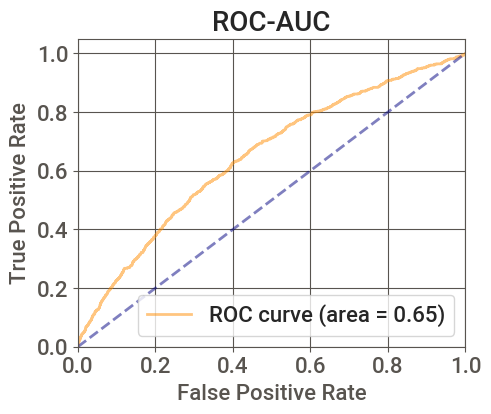

In [631]:
eval_pool = Pool(xy_c['x_valid'], xy_c['y_valid'],cat_features=columns_c)
curve = get_roc_curve(cbc, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 4))
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-AUC', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [628]:
y_predict = cbc.predict(xy_c['x_valid'])
print(classification_report(y_predict, xy_c['y_valid']))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      8548
           1       0.02      0.42      0.05        55

    accuracy                           0.89      8603
   macro avg       0.51      0.66      0.49      8603
weighted avg       0.99      0.89      0.94      8603



### CatBoostClassifier,  Apparel <a class="anchor" id="section_3_4"></a>

In [599]:
model_cb_a = CatBoostClassifier(loss_function='Logloss',early_stopping_rounds=20,
                              iterations=1000,random_seed=seed, eval_metric='AUC')
grid = {'learning_rate': [0.05, 0.1, 0.2],
        'depth': [7,10,15,20],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
       }
train_pool_a = Pool(xy_a['x_train'], xy_a['y_train'],cat_features=columns_c)
grid_cb_a = model_cb_a.grid_search(grid,
                                   train_pool_a
                                   )

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.4936576	best: 0.4936576 (0)	total: 47.3ms	remaining: 47.3s
1:	test: 0.5125916	best: 0.5125916 (1)	total: 188ms	remaining: 1m 34s
2:	test: 0.5651964	best: 0.5651964 (2)	total: 253ms	remaining: 1m 24s
3:	test: 0.5698260	best: 0.5698260 (3)	total: 343ms	remaining: 1m 25s
4:	test: 0.5739978	best: 0.5739978 (4)	total: 430ms	remaining: 1m 25s
5:	test: 0.5491623	best: 0.5739978 (4)	total: 497ms	remaining: 1m 22s
6:	test: 0.5490944	best: 0.5739978 (4)	total: 534ms	remaining: 1m 15s
7:	test: 0.5596849	best: 0.5739978 (4)	total: 592ms	remaining: 1m 13s
8:	test: 0.5604226	best: 0.5739978 (4)	total: 673ms	remaining: 1m 14s
9:	test: 0.5595238	best: 0.5739978 (4)	total: 748ms	remaining: 1m 14s
10:	test: 0.5584385	best: 0.5739978 (4)	total: 767ms	remaining: 1m 8s
11:	test: 0.5584554	best: 0.5739978 (4)	total: 795ms	remaining: 1m 5s
12:	test: 0.5635260	best: 0.5739978 (4)	total: 850ms	remaining: 1m 4s
13:	test: 0.5621778	best: 0.5739978 (4)	total: 922ms	remaining: 1m 4s
14:	test: 0.5621778	

3:	test: 0.5696225	best: 0.5696225 (3)	total: 254ms	remaining: 1m 3s
4:	test: 0.5738451	best: 0.5738451 (4)	total: 356ms	remaining: 1m 10s
5:	test: 0.5577601	best: 0.5738451 (4)	total: 438ms	remaining: 1m 12s
6:	test: 0.5577262	best: 0.5738451 (4)	total: 456ms	remaining: 1m 4s
7:	test: 0.5563865	best: 0.5738451 (4)	total: 493ms	remaining: 1m 1s
8:	test: 0.5691222	best: 0.5738451 (4)	total: 566ms	remaining: 1m 2s
9:	test: 0.5731329	best: 0.5738451 (4)	total: 662ms	remaining: 1m 5s
10:	test: 0.5754138	best: 0.5754138 (10)	total: 722ms	remaining: 1m 4s
11:	test: 0.5755155	best: 0.5755155 (11)	total: 745ms	remaining: 1m 1s
12:	test: 0.5755155	best: 0.5755155 (11)	total: 785ms	remaining: 59.6s
13:	test: 0.5527405	best: 0.5755155 (11)	total: 857ms	remaining: 1m
14:	test: 0.5527405	best: 0.5755155 (11)	total: 879ms	remaining: 57.7s
15:	test: 0.5527405	best: 0.5755155 (11)	total: 890ms	remaining: 54.7s
16:	test: 0.5527405	best: 0.5755155 (11)	total: 900ms	remaining: 52s
17:	test: 0.5527744	bes

1:	test: 0.5105566	best: 0.5105566 (1)	total: 124ms	remaining: 1m 1s
2:	test: 0.5234958	best: 0.5234958 (2)	total: 188ms	remaining: 1m 2s
3:	test: 0.5343746	best: 0.5343746 (3)	total: 252ms	remaining: 1m 2s
4:	test: 0.5334334	best: 0.5343746 (3)	total: 317ms	remaining: 1m 3s
5:	test: 0.5211386	best: 0.5343746 (3)	total: 374ms	remaining: 1m 1s
6:	test: 0.5299824	best: 0.5343746 (3)	total: 427ms	remaining: 1m
7:	test: 0.5356041	best: 0.5356041 (7)	total: 477ms	remaining: 59.1s
8:	test: 0.5352649	best: 0.5356041 (7)	total: 508ms	remaining: 55.9s
9:	test: 0.5428961	best: 0.5428961 (9)	total: 566ms	remaining: 56s
10:	test: 0.5428961	best: 0.5428961 (9)	total: 587ms	remaining: 52.8s
11:	test: 0.5391484	best: 0.5428961 (9)	total: 634ms	remaining: 52.2s
12:	test: 0.5391484	best: 0.5428961 (9)	total: 646ms	remaining: 49s
13:	test: 0.5488400	best: 0.5488400 (13)	total: 683ms	remaining: 48.1s
14:	test: 0.5488400	best: 0.5488400 (13)	total: 692ms	remaining: 45.5s
15:	test: 0.5488231	best: 0.548840

4:	test: 0.5817647	best: 0.5817647 (4)	total: 297ms	remaining: 59.2s
5:	test: 0.5482126	best: 0.5817647 (4)	total: 375ms	remaining: 1m 2s
6:	test: 0.5481448	best: 0.5817647 (4)	total: 398ms	remaining: 56.4s
7:	test: 0.5549281	best: 0.5817647 (4)	total: 436ms	remaining: 54s
8:	test: 0.5585233	best: 0.5817647 (4)	total: 504ms	remaining: 55.5s
9:	test: 0.5585233	best: 0.5817647 (4)	total: 517ms	remaining: 51.2s
10:	test: 0.5585233	best: 0.5817647 (4)	total: 532ms	remaining: 47.8s
11:	test: 0.5568783	best: 0.5817647 (4)	total: 615ms	remaining: 50.6s
12:	test: 0.5568783	best: 0.5817647 (4)	total: 638ms	remaining: 48.4s
13:	test: 0.5562508	best: 0.5817647 (4)	total: 698ms	remaining: 49.2s
14:	test: 0.5562508	best: 0.5817647 (4)	total: 710ms	remaining: 46.6s
15:	test: 0.5565391	best: 0.5817647 (4)	total: 739ms	remaining: 45.5s
16:	test: 0.5798230	best: 0.5817647 (4)	total: 799ms	remaining: 46.2s
17:	test: 0.5769570	best: 0.5817647 (4)	total: 841ms	remaining: 45.9s
18:	test: 0.5737264	best: 0.

58:	test: 0.6061338	best: 0.6118234 (50)	total: 3.04s	remaining: 48.5s
59:	test: 0.6061338	best: 0.6118234 (50)	total: 3.05s	remaining: 47.8s
60:	test: 0.6061338	best: 0.6118234 (50)	total: 3.06s	remaining: 47.1s
61:	test: 0.6061508	best: 0.6118234 (50)	total: 3.15s	remaining: 47.7s
62:	test: 0.6061508	best: 0.6118234 (50)	total: 3.16s	remaining: 47s
63:	test: 0.6061508	best: 0.6118234 (50)	total: 3.2s	remaining: 46.8s
64:	test: 0.6061338	best: 0.6118234 (50)	total: 3.24s	remaining: 46.6s
65:	test: 0.6061338	best: 0.6118234 (50)	total: 3.25s	remaining: 46s
66:	test: 0.6090507	best: 0.6118234 (50)	total: 3.33s	remaining: 46.4s
67:	test: 0.6090507	best: 0.6118234 (50)	total: 3.34s	remaining: 45.8s
68:	test: 0.6090507	best: 0.6118234 (50)	total: 3.38s	remaining: 45.7s
69:	test: 0.6078297	best: 0.6118234 (50)	total: 3.44s	remaining: 45.7s
70:	test: 0.6015890	best: 0.6118234 (50)	total: 3.52s	remaining: 46.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6118233618
bes

0:	test: 0.5063255	best: 0.5063255 (0)	total: 29.8ms	remaining: 29.8s
1:	test: 0.5252255	best: 0.5252255 (1)	total: 89.9ms	remaining: 44.8s
2:	test: 0.5756936	best: 0.5756936 (2)	total: 153ms	remaining: 50.9s
3:	test: 0.5802215	best: 0.5802215 (3)	total: 216ms	remaining: 53.9s
4:	test: 0.5839014	best: 0.5839014 (4)	total: 282ms	remaining: 56.1s
5:	test: 0.5839099	best: 0.5839099 (5)	total: 367ms	remaining: 1m
6:	test: 0.5838760	best: 0.5839099 (5)	total: 395ms	remaining: 56s
7:	test: 0.5663071	best: 0.5839099 (5)	total: 430ms	remaining: 53.3s
8:	test: 0.5663241	best: 0.5839099 (5)	total: 492ms	remaining: 54.2s
9:	test: 0.5663241	best: 0.5839099 (5)	total: 505ms	remaining: 50s
10:	test: 0.5508751	best: 0.5839099 (5)	total: 598ms	remaining: 53.7s
11:	test: 0.5508751	best: 0.5839099 (5)	total: 616ms	remaining: 50.8s
12:	test: 0.5486535	best: 0.5839099 (5)	total: 685ms	remaining: 52s
13:	test: 0.5459741	best: 0.5839099 (5)	total: 761ms	remaining: 53.6s
14:	test: 0.5458130	best: 0.5839099 (

31:	test: 0.5346629	best: 0.5663495 (18)	total: 1.64s	remaining: 49.6s
32:	test: 0.5342898	best: 0.5663495 (18)	total: 1.7s	remaining: 49.7s
33:	test: 0.5338573	best: 0.5663495 (18)	total: 1.72s	remaining: 48.9s
34:	test: 0.5336369	best: 0.5663495 (18)	total: 1.83s	remaining: 50.4s
35:	test: 0.5361467	best: 0.5663495 (18)	total: 1.92s	remaining: 51.5s
36:	test: 0.5384191	best: 0.5663495 (18)	total: 2.02s	remaining: 52.5s
37:	test: 0.5323820	best: 0.5663495 (18)	total: 2.11s	remaining: 53.3s
38:	test: 0.5530288	best: 0.5663495 (18)	total: 2.2s	remaining: 54.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5663495455
bestIteration = 18

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
16:	loss: 0.5663495	best: 0.6431624 (8)	total: 36.3s	remaining: 1m 31s
0:	test: 0.4936576	best: 0.4936576 (0)	total: 19.2ms	remaining: 19.2s
1:	test: 0.5305335	best: 0.5305335 (1)	total: 107ms	remainin

32:	test: 0.5807981	best: 0.5873355 (16)	total: 1.84s	remaining: 54.1s
33:	test: 0.5761430	best: 0.5873355 (16)	total: 1.94s	remaining: 55.1s
34:	test: 0.5731753	best: 0.5873355 (16)	total: 2.04s	remaining: 56.3s
35:	test: 0.5717508	best: 0.5873355 (16)	total: 2.11s	remaining: 56.5s
36:	test: 0.5717508	best: 0.5873355 (16)	total: 2.12s	remaining: 55.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.587335504
bestIteration = 16

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
19:	loss: 0.5873355	best: 0.6431624 (8)	total: 41.8s	remaining: 1m 23s
0:	test: 0.4926062	best: 0.4926062 (0)	total: 22.2ms	remaining: 22.2s
1:	test: 0.5302622	best: 0.5302622 (1)	total: 108ms	remaining: 53.9s
2:	test: 0.5412597	best: 0.5412597 (2)	total: 153ms	remaining: 50.7s
3:	test: 0.5594475	best: 0.5594475 (3)	total: 211ms	remaining: 52.7s
4:	test: 0.5595662	best: 0.5595662 (4)	total: 254ms	remaining: 50

41:	test: 0.6085589	best: 0.6211505 (22)	total: 2.52s	remaining: 57.5s
42:	test: 0.6017247	best: 0.6211505 (22)	total: 2.62s	remaining: 58.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6211504545
bestIteration = 22

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
22:	loss: 0.6211505	best: 0.6431624 (8)	total: 47.4s	remaining: 1m 16s
0:	test: 0.4926062	best: 0.4926062 (0)	total: 21.4ms	remaining: 21.4s
1:	test: 0.5295499	best: 0.5295499 (1)	total: 109ms	remaining: 54.6s
2:	test: 0.5515025	best: 0.5515025 (2)	total: 157ms	remaining: 52.2s
3:	test: 0.5703348	best: 0.5703348 (3)	total: 220ms	remaining: 54.8s
4:	test: 0.5705213	best: 0.5705213 (4)	total: 264ms	remaining: 52.5s
5:	test: 0.5624576	best: 0.5705213 (4)	total: 293ms	remaining: 48.6s
6:	test: 0.5624576	best: 0.5705213 (4)	total: 321ms	remaining: 45.5s
7:	test: 0.5654931	best: 0.5705213 (4)	total: 384ms	remaining: 47.7s
8

51:	test: 0.5877086	best: 0.5929657 (38)	total: 2.42s	remaining: 44.1s
52:	test: 0.5871659	best: 0.5929657 (38)	total: 2.52s	remaining: 44.9s
53:	test: 0.5871659	best: 0.5929657 (38)	total: 2.54s	remaining: 44.5s
54:	test: 0.5871659	best: 0.5929657 (38)	total: 2.55s	remaining: 43.9s
55:	test: 0.5871659	best: 0.5929657 (38)	total: 2.56s	remaining: 43.2s
56:	test: 0.5880308	best: 0.5929657 (38)	total: 2.6s	remaining: 43s
57:	test: 0.5853175	best: 0.5929657 (38)	total: 2.7s	remaining: 43.8s
58:	test: 0.5854870	best: 0.5929657 (38)	total: 2.79s	remaining: 44.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5929656763
bestIteration = 38

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
24:	loss: 0.5929657	best: 0.6431624 (8)	total: 54.1s	remaining: 1m 15s
0:	test: 0.4926062	best: 0.4926062 (0)	total: 18.8ms	remaining: 18.8s
1:	test: 0.5427605	best: 0.5427605 (1)	total: 102ms	remaining:

13:	test: 0.5707078	best: 0.5707078 (13)	total: 660ms	remaining: 46.5s
14:	test: 0.5353921	best: 0.5707078 (13)	total: 730ms	remaining: 47.9s
15:	test: 0.5319665	best: 0.5707078 (13)	total: 781ms	remaining: 48s
16:	test: 0.5319665	best: 0.5707078 (13)	total: 790ms	remaining: 45.7s
17:	test: 0.5291175	best: 0.5707078 (13)	total: 856ms	remaining: 46.7s
18:	test: 0.5281000	best: 0.5707078 (13)	total: 880ms	remaining: 45.4s
19:	test: 0.5279304	best: 0.5707078 (13)	total: 907ms	remaining: 44.4s
20:	test: 0.5307540	best: 0.5707078 (13)	total: 939ms	remaining: 43.8s
21:	test: 0.5307540	best: 0.5707078 (13)	total: 956ms	remaining: 42.5s
22:	test: 0.5349681	best: 0.5707078 (13)	total: 1.02s	remaining: 43.2s
23:	test: 0.5357228	best: 0.5707078 (13)	total: 1.05s	remaining: 42.7s
24:	test: 0.5357482	best: 0.5707078 (13)	total: 1.06s	remaining: 41.6s
25:	test: 0.5368844	best: 0.5707078 (13)	total: 1.12s	remaining: 41.9s
26:	test: 0.5365792	best: 0.5707078 (13)	total: 1.14s	remaining: 41s
27:	test: 

7:	test: 0.5586250	best: 0.5586250 (7)	total: 358ms	remaining: 44.4s
8:	test: 0.5575312	best: 0.5586250 (7)	total: 385ms	remaining: 42.4s
9:	test: 0.5575312	best: 0.5586250 (7)	total: 396ms	remaining: 39.2s
10:	test: 0.5575312	best: 0.5586250 (7)	total: 409ms	remaining: 36.8s
11:	test: 0.5575312	best: 0.5586250 (7)	total: 418ms	remaining: 34.4s
12:	test: 0.5468050	best: 0.5586250 (7)	total: 561ms	remaining: 42.6s
13:	test: 0.5497897	best: 0.5586250 (7)	total: 604ms	remaining: 42.6s
14:	test: 0.5497897	best: 0.5586250 (7)	total: 614ms	remaining: 40.3s
15:	test: 0.5499254	best: 0.5586250 (7)	total: 631ms	remaining: 38.8s
16:	test: 0.5509259	best: 0.5586250 (7)	total: 671ms	remaining: 38.8s
17:	test: 0.5601682	best: 0.5601682 (17)	total: 751ms	remaining: 41s
18:	test: 0.5514856	best: 0.5601682 (17)	total: 808ms	remaining: 41.7s
19:	test: 0.5490859	best: 0.5601682 (17)	total: 923ms	remaining: 45.2s
20:	test: 0.5490859	best: 0.5601682 (17)	total: 934ms	remaining: 43.5s
21:	test: 0.5495862	b

19:	test: 0.5421415	best: 0.5756682 (13)	total: 5.82s	remaining: 4m 45s
20:	test: 0.5421415	best: 0.5756682 (13)	total: 5.83s	remaining: 4m 31s
21:	test: 0.5392925	best: 0.5756682 (13)	total: 5.87s	remaining: 4m 20s
22:	test: 0.5396825	best: 0.5756682 (13)	total: 5.92s	remaining: 4m 11s
23:	test: 0.5396825	best: 0.5756682 (13)	total: 5.92s	remaining: 4m
24:	test: 0.5395130	best: 0.5756682 (13)	total: 5.98s	remaining: 3m 53s
25:	test: 0.5392416	best: 0.5756682 (13)	total: 6s	remaining: 3m 44s
26:	test: 0.5397334	best: 0.5756682 (13)	total: 6.06s	remaining: 3m 38s
27:	test: 0.5434473	best: 0.5756682 (13)	total: 6.88s	remaining: 3m 58s
28:	test: 0.5354599	best: 0.5756682 (13)	total: 7.6s	remaining: 4m 14s
29:	test: 0.5364774	best: 0.5756682 (13)	total: 7.71s	remaining: 4m 9s
30:	test: 0.5326363	best: 0.5756682 (13)	total: 8.47s	remaining: 4m 24s
31:	test: 0.5330603	best: 0.5756682 (13)	total: 8.49s	remaining: 4m 16s
32:	test: 0.5242165	best: 0.5756682 (13)	total: 9.27s	remaining: 4m 31s
3

67:	test: 0.5777286	best: 0.6051842 (49)	total: 9.99s	remaining: 2m 16s
68:	test: 0.5777286	best: 0.6051842 (49)	total: 10s	remaining: 2m 14s
69:	test: 0.5778134	best: 0.6051842 (49)	total: 10s	remaining: 2m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6051841677
bestIteration = 49

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
34:	loss: 0.6051842	best: 0.6431624 (8)	total: 1m 37s	remaining: 1m 9s
0:	test: 0.4926062	best: 0.4926062 (0)	total: 18.1ms	remaining: 18.1s
1:	test: 0.5302622	best: 0.5302622 (1)	total: 103ms	remaining: 51.5s
2:	test: 0.5412597	best: 0.5412597 (2)	total: 145ms	remaining: 48.2s
3:	test: 0.5594475	best: 0.5594475 (3)	total: 205ms	remaining: 51s
4:	test: 0.5595662	best: 0.5595662 (4)	total: 246ms	remaining: 48.9s
5:	test: 0.5514177	best: 0.5595662 (4)	total: 276ms	remaining: 45.7s
6:	test: 0.5514177	best: 0.5595662 (4)	total: 303ms	remaining: 43s
7:	t

36:	test: 0.5588116	best: 0.5674603 (20)	total: 6.05s	remaining: 2m 37s
37:	test: 0.5588285	best: 0.5674603 (20)	total: 6.1s	remaining: 2m 34s
38:	test: 0.5588285	best: 0.5674603 (20)	total: 6.11s	remaining: 2m 30s
39:	test: 0.5610670	best: 0.5674603 (20)	total: 6.18s	remaining: 2m 28s
40:	test: 0.5618810	best: 0.5674603 (20)	total: 6.24s	remaining: 2m 26s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5674603175
bestIteration = 20

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
37:	loss: 0.5674603	best: 0.6431624 (8)	total: 1m 51s	remaining: 1m 4s
0:	test: 0.4926062	best: 0.4926062 (0)	total: 21.3ms	remaining: 21.2s
1:	test: 0.5295499	best: 0.5295499 (1)	total: 120ms	remaining: 1m
2:	test: 0.5515025	best: 0.5515025 (2)	total: 170ms	remaining: 56.6s
3:	test: 0.5703348	best: 0.5703348 (3)	total: 238ms	remaining: 59.3s
4:	test: 0.5705213	best: 0.5705213 (4)	total: 283ms	remaining: 

5:	test: 0.5645096	best: 0.5645096 (5)	total: 485ms	remaining: 1m 20s
6:	test: 0.5645096	best: 0.5645096 (5)	total: 505ms	remaining: 1m 11s
7:	test: 0.5527998	best: 0.5645096 (5)	total: 579ms	remaining: 1m 11s
8:	test: 0.5505359	best: 0.5645096 (5)	total: 646ms	remaining: 1m 11s
9:	test: 0.5488061	best: 0.5645096 (5)	total: 678ms	remaining: 1m 7s
10:	test: 0.5487213	best: 0.5645096 (5)	total: 727ms	remaining: 1m 5s
11:	test: 0.5487213	best: 0.5645096 (5)	total: 761ms	remaining: 1m 2s
12:	test: 0.5487213	best: 0.5645096 (5)	total: 779ms	remaining: 59.2s
13:	test: 0.5513668	best: 0.5645096 (5)	total: 1.44s	remaining: 1m 41s
14:	test: 0.5545381	best: 0.5645096 (5)	total: 1.53s	remaining: 1m 40s
15:	test: 0.5545381	best: 0.5645096 (5)	total: 1.54s	remaining: 1m 34s
16:	test: 0.5550214	best: 0.5645096 (5)	total: 1.57s	remaining: 1m 30s
17:	test: 0.5550214	best: 0.5645096 (5)	total: 1.57s	remaining: 1m 25s
18:	test: 0.5559371	best: 0.5645096 (5)	total: 1.61s	remaining: 1m 23s
19:	test: 0.561

14:	test: 0.5402422	best: 0.5643993 (8)	total: 687ms	remaining: 45.1s
15:	test: 0.5443461	best: 0.5643993 (8)	total: 842ms	remaining: 51.8s
16:	test: 0.5473477	best: 0.5643993 (8)	total: 931ms	remaining: 53.9s
17:	test: 0.5483991	best: 0.5643993 (8)	total: 950ms	remaining: 51.8s
18:	test: 0.5605244	best: 0.5643993 (8)	total: 989ms	remaining: 51.1s
19:	test: 0.5605922	best: 0.5643993 (8)	total: 1.01s	remaining: 49.4s
20:	test: 0.5605583	best: 0.5643993 (8)	total: 1.03s	remaining: 48.1s
21:	test: 0.5605583	best: 0.5643993 (8)	total: 1.04s	remaining: 46.3s
22:	test: 0.5605583	best: 0.5643993 (8)	total: 1.05s	remaining: 44.7s
23:	test: 0.5605583	best: 0.5643993 (8)	total: 1.07s	remaining: 43.4s
24:	test: 0.5616436	best: 0.5643993 (8)	total: 1.08s	remaining: 42.3s
25:	test: 0.5616436	best: 0.5643993 (8)	total: 1.09s	remaining: 41s
26:	test: 0.5546907	best: 0.5643993 (8)	total: 1.13s	remaining: 40.9s
27:	test: 0.5546907	best: 0.5643993 (8)	total: 1.14s	remaining: 39.7s
28:	test: 0.5547076	be

10:	test: 0.5225572	best: 0.5419780 (3)	total: 699ms	remaining: 1m 2s
11:	test: 0.5493820	best: 0.5493820 (11)	total: 766ms	remaining: 1m 3s
12:	test: 0.5527434	best: 0.5527434 (12)	total: 841ms	remaining: 1m 3s
13:	test: 0.5508947	best: 0.5527434 (12)	total: 865ms	remaining: 1m
14:	test: 0.5510927	best: 0.5527434 (12)	total: 942ms	remaining: 1m 1s
15:	test: 0.5486858	best: 0.5527434 (12)	total: 1.01s	remaining: 1m 2s
16:	test: 0.5486858	best: 0.5527434 (12)	total: 1.02s	remaining: 59.2s
17:	test: 0.5513959	best: 0.5527434 (12)	total: 1.08s	remaining: 58.9s
18:	test: 0.5518911	best: 0.5527434 (12)	total: 1.14s	remaining: 59s
19:	test: 0.5491510	best: 0.5527434 (12)	total: 1.25s	remaining: 1m 1s
20:	test: 0.5559787	best: 0.5559787 (20)	total: 1.3s	remaining: 1m
21:	test: 0.5559907	best: 0.5559907 (21)	total: 1.33s	remaining: 59.4s
22:	test: 0.5492230	best: 0.5559907 (21)	total: 1.47s	remaining: 1m 2s
23:	test: 0.5549463	best: 0.5559907 (21)	total: 1.53s	remaining: 1m 2s
24:	test: 0.5542

In [600]:
model_cb_a.get_params()

{'iterations': 1000,
 'loss_function': 'Logloss',
 'random_seed': 123,
 'eval_metric': 'AUC',
 'early_stopping_rounds': 20,
 'depth': 7,
 'l2_leaf_reg': 5,
 'learning_rate': 0.2}

In [620]:
cbc_a = CatBoostClassifier(iterations=1000,
                         loss_function='Logloss',
                         eval_metric='AUC',
                         random_seed=seed,
                         learning_rate=0.2,
                         l2_leaf_reg=5,
                         early_stopping_rounds=20,
                         depth=7
                         )
cbc_a.fit(train_pool_a)

0:	total: 102ms	remaining: 1m 41s
1:	total: 160ms	remaining: 1m 20s
2:	total: 252ms	remaining: 1m 23s
3:	total: 336ms	remaining: 1m 23s
4:	total: 459ms	remaining: 1m 31s
5:	total: 565ms	remaining: 1m 33s
6:	total: 657ms	remaining: 1m 33s
7:	total: 774ms	remaining: 1m 36s
8:	total: 869ms	remaining: 1m 35s
9:	total: 958ms	remaining: 1m 34s
10:	total: 1.06s	remaining: 1m 35s
11:	total: 1.15s	remaining: 1m 34s
12:	total: 1.25s	remaining: 1m 35s
13:	total: 1.35s	remaining: 1m 34s
14:	total: 1.43s	remaining: 1m 34s
15:	total: 1.47s	remaining: 1m 30s
16:	total: 1.55s	remaining: 1m 29s
17:	total: 1.63s	remaining: 1m 29s
18:	total: 1.73s	remaining: 1m 29s
19:	total: 1.82s	remaining: 1m 29s
20:	total: 1.93s	remaining: 1m 30s
21:	total: 2.02s	remaining: 1m 29s
22:	total: 2.18s	remaining: 1m 32s
23:	total: 2.27s	remaining: 1m 32s
24:	total: 2.37s	remaining: 1m 32s
25:	total: 2.46s	remaining: 1m 32s
26:	total: 2.54s	remaining: 1m 31s
27:	total: 2.59s	remaining: 1m 29s
28:	total: 2.64s	remaining: 1m

233:	total: 21.3s	remaining: 1m 9s
234:	total: 21.4s	remaining: 1m 9s
235:	total: 21.5s	remaining: 1m 9s
236:	total: 21.6s	remaining: 1m 9s
237:	total: 21.7s	remaining: 1m 9s
238:	total: 21.8s	remaining: 1m 9s
239:	total: 21.9s	remaining: 1m 9s
240:	total: 22s	remaining: 1m 9s
241:	total: 22.1s	remaining: 1m 9s
242:	total: 22.2s	remaining: 1m 9s
243:	total: 22.3s	remaining: 1m 8s
244:	total: 22.3s	remaining: 1m 8s
245:	total: 22.4s	remaining: 1m 8s
246:	total: 22.5s	remaining: 1m 8s
247:	total: 22.6s	remaining: 1m 8s
248:	total: 22.7s	remaining: 1m 8s
249:	total: 22.8s	remaining: 1m 8s
250:	total: 22.9s	remaining: 1m 8s
251:	total: 23s	remaining: 1m 8s
252:	total: 23.1s	remaining: 1m 8s
253:	total: 23.1s	remaining: 1m 7s
254:	total: 23.2s	remaining: 1m 7s
255:	total: 23.3s	remaining: 1m 7s
256:	total: 23.4s	remaining: 1m 7s
257:	total: 23.5s	remaining: 1m 7s
258:	total: 23.6s	remaining: 1m 7s
259:	total: 23.7s	remaining: 1m 7s
260:	total: 23.8s	remaining: 1m 7s
261:	total: 23.9s	remain

472:	total: 44s	remaining: 49s
473:	total: 44.1s	remaining: 49s
474:	total: 44.2s	remaining: 48.9s
475:	total: 44.3s	remaining: 48.8s
476:	total: 44.4s	remaining: 48.7s
477:	total: 44.6s	remaining: 48.7s
478:	total: 44.6s	remaining: 48.6s
479:	total: 44.8s	remaining: 48.5s
480:	total: 44.9s	remaining: 48.4s
481:	total: 44.9s	remaining: 48.3s
482:	total: 45s	remaining: 48.2s
483:	total: 45.1s	remaining: 48.1s
484:	total: 45.2s	remaining: 48s
485:	total: 45.4s	remaining: 48s
486:	total: 45.5s	remaining: 47.9s
487:	total: 45.6s	remaining: 47.8s
488:	total: 45.7s	remaining: 47.7s
489:	total: 45.7s	remaining: 47.6s
490:	total: 45.8s	remaining: 47.5s
491:	total: 45.9s	remaining: 47.4s
492:	total: 46s	remaining: 47.3s
493:	total: 46.1s	remaining: 47.2s
494:	total: 46.2s	remaining: 47.2s
495:	total: 46.3s	remaining: 47.1s
496:	total: 46.4s	remaining: 47s
497:	total: 46.6s	remaining: 46.9s
498:	total: 46.6s	remaining: 46.8s
499:	total: 46.7s	remaining: 46.7s
500:	total: 46.8s	remaining: 46.6s
5

711:	total: 1m 7s	remaining: 27.2s
712:	total: 1m 7s	remaining: 27.1s
713:	total: 1m 7s	remaining: 27s
714:	total: 1m 7s	remaining: 26.9s
715:	total: 1m 7s	remaining: 26.8s
716:	total: 1m 7s	remaining: 26.7s
717:	total: 1m 7s	remaining: 26.6s
718:	total: 1m 7s	remaining: 26.5s
719:	total: 1m 7s	remaining: 26.4s
720:	total: 1m 8s	remaining: 26.3s
721:	total: 1m 8s	remaining: 26.2s
722:	total: 1m 8s	remaining: 26.1s
723:	total: 1m 8s	remaining: 26s
724:	total: 1m 8s	remaining: 25.9s
725:	total: 1m 8s	remaining: 25.8s
726:	total: 1m 8s	remaining: 25.7s
727:	total: 1m 8s	remaining: 25.6s
728:	total: 1m 8s	remaining: 25.6s
729:	total: 1m 8s	remaining: 25.5s
730:	total: 1m 8s	remaining: 25.4s
731:	total: 1m 9s	remaining: 25.3s
732:	total: 1m 9s	remaining: 25.2s
733:	total: 1m 9s	remaining: 25.1s
734:	total: 1m 9s	remaining: 25s
735:	total: 1m 9s	remaining: 24.9s
736:	total: 1m 9s	remaining: 24.8s
737:	total: 1m 9s	remaining: 24.7s
738:	total: 1m 9s	remaining: 24.6s
739:	total: 1m 9s	remainin

943:	total: 1m 28s	remaining: 5.27s
944:	total: 1m 28s	remaining: 5.17s
945:	total: 1m 28s	remaining: 5.08s
946:	total: 1m 29s	remaining: 4.99s
947:	total: 1m 29s	remaining: 4.89s
948:	total: 1m 29s	remaining: 4.8s
949:	total: 1m 29s	remaining: 4.7s
950:	total: 1m 29s	remaining: 4.61s
951:	total: 1m 29s	remaining: 4.51s
952:	total: 1m 29s	remaining: 4.42s
953:	total: 1m 29s	remaining: 4.33s
954:	total: 1m 29s	remaining: 4.23s
955:	total: 1m 29s	remaining: 4.14s
956:	total: 1m 30s	remaining: 4.04s
957:	total: 1m 30s	remaining: 3.95s
958:	total: 1m 30s	remaining: 3.86s
959:	total: 1m 30s	remaining: 3.76s
960:	total: 1m 30s	remaining: 3.67s
961:	total: 1m 30s	remaining: 3.57s
962:	total: 1m 30s	remaining: 3.48s
963:	total: 1m 30s	remaining: 3.39s
964:	total: 1m 30s	remaining: 3.29s
965:	total: 1m 30s	remaining: 3.2s
966:	total: 1m 30s	remaining: 3.1s
967:	total: 1m 31s	remaining: 3.01s
968:	total: 1m 31s	remaining: 2.92s
969:	total: 1m 31s	remaining: 2.82s
970:	total: 1m 31s	remaining: 2.

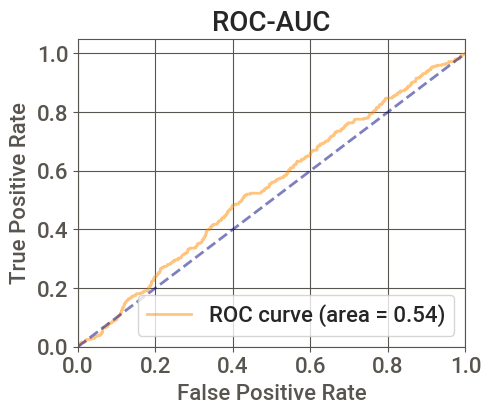

In [621]:
eval_pool = Pool(xy_a['x_valid'], xy_a['y_valid'],cat_features=columns_c)
curve = get_roc_curve(cbc_a, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 4))
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-AUC', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [622]:
y_predict = cbc_a.predict(xy_a['x_valid'])
print(classification_report(y_predict, xy_a['y_valid']))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      4986
           1       0.00      0.00      0.00         5

    accuracy                           0.93      4991
   macro avg       0.50      0.47      0.48      4991
weighted avg       1.00      0.93      0.97      4991



### CatBoostClassifier,  MarketPlace <a class="anchor" id="section_3_6"></a>

In [632]:
model_cb_m = CatBoostClassifier(loss_function='Logloss',early_stopping_rounds=20,
                              iterations=1000,random_seed=seed, eval_metric='AUC')
train_pool_m = Pool(xy_m['x_train'], xy_m['y_train'],cat_features=columns_c)
grid_cb_m = model_cb_m.grid_search(grid,
                                   train_pool_m
                                   )

0:	test: 0.5120861	best: 0.5120861 (0)	total: 79.4ms	remaining: 1m 19s
1:	test: 0.5174559	best: 0.5174559 (1)	total: 161ms	remaining: 1m 20s
2:	test: 0.5206635	best: 0.5206635 (2)	total: 235ms	remaining: 1m 18s
3:	test: 0.5349790	best: 0.5349790 (3)	total: 324ms	remaining: 1m 20s
4:	test: 0.5349803	best: 0.5349803 (4)	total: 462ms	remaining: 1m 31s
5:	test: 0.5356133	best: 0.5356133 (5)	total: 521ms	remaining: 1m 26s
6:	test: 0.5356133	best: 0.5356133 (5)	total: 545ms	remaining: 1m 17s
7:	test: 0.5500257	best: 0.5500257 (7)	total: 579ms	remaining: 1m 11s
8:	test: 0.5572717	best: 0.5572717 (8)	total: 668ms	remaining: 1m 13s
9:	test: 0.5584430	best: 0.5584430 (9)	total: 724ms	remaining: 1m 11s
10:	test: 0.5582593	best: 0.5584430 (9)	total: 789ms	remaining: 1m 10s
11:	test: 0.5575530	best: 0.5584430 (9)	total: 834ms	remaining: 1m 8s
12:	test: 0.5561276	best: 0.5584430 (9)	total: 927ms	remaining: 1m 10s
13:	test: 0.5587128	best: 0.5587128 (13)	total: 1.05s	remaining: 1m 13s
14:	test: 0.559

40:	test: 0.5985185	best: 0.5990976 (32)	total: 2.99s	remaining: 1m 9s
41:	test: 0.5996055	best: 0.5996055 (41)	total: 3.09s	remaining: 1m 10s
42:	test: 0.5994933	best: 0.5996055 (41)	total: 3.11s	remaining: 1m 9s
43:	test: 0.5998944	best: 0.5998944 (43)	total: 3.19s	remaining: 1m 9s
44:	test: 0.5999640	best: 0.5999640 (44)	total: 3.28s	remaining: 1m 9s
45:	test: 0.5992171	best: 0.5999640 (44)	total: 3.37s	remaining: 1m 9s
46:	test: 0.6001795	best: 0.6001795 (46)	total: 3.44s	remaining: 1m 9s
47:	test: 0.6003607	best: 0.6003607 (47)	total: 3.52s	remaining: 1m 9s
48:	test: 0.5999474	best: 0.6003607 (47)	total: 3.59s	remaining: 1m 9s
49:	test: 0.6008281	best: 0.6008281 (49)	total: 3.67s	remaining: 1m 9s
50:	test: 0.6006646	best: 0.6008281 (49)	total: 3.76s	remaining: 1m 9s
51:	test: 0.6007169	best: 0.6008281 (49)	total: 3.84s	remaining: 1m 10s
52:	test: 0.6003996	best: 0.6008281 (49)	total: 3.92s	remaining: 1m 10s
53:	test: 0.6001119	best: 0.6008281 (49)	total: 3.99s	remaining: 1m 9s
54:

17:	test: 0.5606892	best: 0.5606892 (17)	total: 1.21s	remaining: 1m 5s
18:	test: 0.5606459	best: 0.5606892 (17)	total: 1.24s	remaining: 1m 4s
19:	test: 0.5616280	best: 0.5616280 (19)	total: 1.32s	remaining: 1m 4s
20:	test: 0.5616280	best: 0.5616280 (19)	total: 1.35s	remaining: 1m 3s
21:	test: 0.5616280	best: 0.5616280 (19)	total: 1.39s	remaining: 1m 1s
22:	test: 0.5616280	best: 0.5616280 (19)	total: 1.41s	remaining: 59.7s
23:	test: 0.5734345	best: 0.5734345 (23)	total: 1.48s	remaining: 1m
24:	test: 0.5734345	best: 0.5734345 (23)	total: 1.52s	remaining: 59.4s
25:	test: 0.5734345	best: 0.5734345 (23)	total: 1.55s	remaining: 58.1s
26:	test: 0.5723876	best: 0.5734345 (23)	total: 1.65s	remaining: 59.6s
27:	test: 0.5723876	best: 0.5734345 (23)	total: 1.67s	remaining: 57.9s
28:	test: 0.5723589	best: 0.5734345 (23)	total: 1.75s	remaining: 58.5s
29:	test: 0.5710562	best: 0.5734345 (23)	total: 1.84s	remaining: 59.6s
30:	test: 0.5708713	best: 0.5734345 (23)	total: 1.9s	remaining: 59.5s
31:	test: 

33:	test: 0.6038439	best: 0.6043171 (29)	total: 2.22s	remaining: 1m 3s
34:	test: 0.6034733	best: 0.6043171 (29)	total: 2.28s	remaining: 1m 2s
35:	test: 0.6032960	best: 0.6043171 (29)	total: 2.37s	remaining: 1m 3s
36:	test: 0.6041149	best: 0.6043171 (29)	total: 2.46s	remaining: 1m 4s
37:	test: 0.6041098	best: 0.6043171 (29)	total: 2.48s	remaining: 1m 2s
38:	test: 0.6045011	best: 0.6045011 (38)	total: 2.56s	remaining: 1m 3s
39:	test: 0.6044584	best: 0.6045011 (38)	total: 2.67s	remaining: 1m 4s
40:	test: 0.6050783	best: 0.6050783 (40)	total: 2.77s	remaining: 1m 4s
41:	test: 0.6050528	best: 0.6050783 (40)	total: 2.86s	remaining: 1m 5s
42:	test: 0.6062677	best: 0.6062677 (42)	total: 2.94s	remaining: 1m 5s
43:	test: 0.6071912	best: 0.6071912 (43)	total: 3.05s	remaining: 1m 6s
44:	test: 0.6078682	best: 0.6078682 (44)	total: 3.15s	remaining: 1m 6s
45:	test: 0.6074243	best: 0.6078682 (44)	total: 3.24s	remaining: 1m 7s
46:	test: 0.6074243	best: 0.6078682 (44)	total: 3.25s	remaining: 1m 6s
47:	te

1:	test: 0.5174444	best: 0.5174444 (1)	total: 161ms	remaining: 1m 20s
2:	test: 0.5203727	best: 0.5203727 (2)	total: 243ms	remaining: 1m 20s
3:	test: 0.5349745	best: 0.5349745 (3)	total: 349ms	remaining: 1m 26s
4:	test: 0.5349777	best: 0.5349777 (4)	total: 390ms	remaining: 1m 17s
5:	test: 0.5356094	best: 0.5356094 (5)	total: 452ms	remaining: 1m 14s
6:	test: 0.5356094	best: 0.5356094 (5)	total: 477ms	remaining: 1m 7s
7:	test: 0.5581515	best: 0.5581515 (7)	total: 564ms	remaining: 1m 9s
8:	test: 0.5581515	best: 0.5581515 (7)	total: 584ms	remaining: 1m 4s
9:	test: 0.5550134	best: 0.5581515 (7)	total: 679ms	remaining: 1m 7s
10:	test: 0.5550178	best: 0.5581515 (7)	total: 762ms	remaining: 1m 8s
11:	test: 0.5625015	best: 0.5625015 (11)	total: 836ms	remaining: 1m 8s
12:	test: 0.5646689	best: 0.5646689 (12)	total: 884ms	remaining: 1m 7s
13:	test: 0.5752228	best: 0.5752228 (13)	total: 954ms	remaining: 1m 7s
14:	test: 0.5751884	best: 0.5752228 (13)	total: 1.06s	remaining: 1m 9s
15:	test: 0.5751989	

16:	test: 0.5737068	best: 0.5742713 (15)	total: 1.17s	remaining: 1m 7s
17:	test: 0.5737145	best: 0.5742713 (15)	total: 1.2s	remaining: 1m 5s
18:	test: 0.5752046	best: 0.5752046 (18)	total: 1.23s	remaining: 1m 3s
19:	test: 0.5754263	best: 0.5754263 (19)	total: 1.27s	remaining: 1m 2s
20:	test: 0.5937367	best: 0.5937367 (20)	total: 1.36s	remaining: 1m 3s
21:	test: 0.5997156	best: 0.5997156 (21)	total: 1.44s	remaining: 1m 4s
22:	test: 0.5997156	best: 0.5997156 (21)	total: 1.47s	remaining: 1m 2s
23:	test: 0.6002360	best: 0.6002360 (23)	total: 1.49s	remaining: 1m
24:	test: 0.6013996	best: 0.6013996 (24)	total: 1.57s	remaining: 1m 1s
25:	test: 0.6002028	best: 0.6013996 (24)	total: 1.66s	remaining: 1m 2s
26:	test: 0.6001531	best: 0.6013996 (24)	total: 1.78s	remaining: 1m 4s
27:	test: 0.6020756	best: 0.6020756 (27)	total: 1.88s	remaining: 1m 5s
28:	test: 0.6013393	best: 0.6020756 (27)	total: 1.99s	remaining: 1m 6s
29:	test: 0.6004994	best: 0.6020756 (27)	total: 2.03s	remaining: 1m 5s
30:	test: 

26:	test: 0.5785032	best: 0.5788620 (15)	total: 1.77s	remaining: 1m 3s
27:	test: 0.5786738	best: 0.5788620 (15)	total: 1.84s	remaining: 1m 4s
28:	test: 0.5786738	best: 0.5788620 (15)	total: 1.88s	remaining: 1m 2s
29:	test: 0.5800565	best: 0.5800565 (29)	total: 1.97s	remaining: 1m 3s
30:	test: 0.5896834	best: 0.5896834 (30)	total: 2.05s	remaining: 1m 3s
31:	test: 0.5896885	best: 0.5896885 (31)	total: 2.07s	remaining: 1m 2s
32:	test: 0.5883712	best: 0.5896885 (31)	total: 2.14s	remaining: 1m 2s
33:	test: 0.5883712	best: 0.5896885 (31)	total: 2.15s	remaining: 1m 1s
34:	test: 0.5885198	best: 0.5896885 (31)	total: 2.24s	remaining: 1m 1s
35:	test: 0.5885198	best: 0.5896885 (31)	total: 2.25s	remaining: 1m
36:	test: 0.5913700	best: 0.5913700 (36)	total: 2.33s	remaining: 1m
37:	test: 0.5923840	best: 0.5923840 (37)	total: 2.38s	remaining: 1m
38:	test: 0.5962257	best: 0.5962257 (38)	total: 2.45s	remaining: 1m
39:	test: 0.5973545	best: 0.5973545 (39)	total: 2.53s	remaining: 1m
40:	test: 0.6000880	b

66:	test: 0.6013683	best: 0.6047648 (53)	total: 4.88s	remaining: 1m 8s
67:	test: 0.6013211	best: 0.6047648 (53)	total: 4.97s	remaining: 1m 8s
68:	test: 0.6016011	best: 0.6047648 (53)	total: 5.05s	remaining: 1m 8s
69:	test: 0.6016011	best: 0.6047648 (53)	total: 5.11s	remaining: 1m 7s
70:	test: 0.6016011	best: 0.6047648 (53)	total: 5.12s	remaining: 1m 7s
71:	test: 0.6016011	best: 0.6047648 (53)	total: 5.16s	remaining: 1m 6s
72:	test: 0.6018763	best: 0.6047648 (53)	total: 5.24s	remaining: 1m 6s
73:	test: 0.6023483	best: 0.6047648 (53)	total: 5.33s	remaining: 1m 6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6047648051
bestIteration = 53

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
10:	loss: 0.6047648	best: 0.6092850 (2)	total: 58.3s	remaining: 4m 19s
0:	test: 0.5120746	best: 0.5120746 (0)	total: 76.8ms	remaining: 1m 16s
1:	test: 0.5174444	best: 0.5174444 (1)	total: 153ms	remai

53:	test: 0.6058372	best: 0.6058372 (53)	total: 3.62s	remaining: 1m 3s
54:	test: 0.6050502	best: 0.6058372 (53)	total: 3.71s	remaining: 1m 3s
55:	test: 0.6063101	best: 0.6063101 (55)	total: 3.8s	remaining: 1m 4s
56:	test: 0.6063101	best: 0.6063101 (55)	total: 3.84s	remaining: 1m 3s
57:	test: 0.6066284	best: 0.6066284 (57)	total: 3.88s	remaining: 1m 3s
58:	test: 0.6066195	best: 0.6066284 (57)	total: 3.94s	remaining: 1m 2s
59:	test: 0.6066195	best: 0.6066284 (57)	total: 3.97s	remaining: 1m 2s
60:	test: 0.6064482	best: 0.6066284 (57)	total: 3.99s	remaining: 1m 1s
61:	test: 0.6050298	best: 0.6066284 (57)	total: 4.07s	remaining: 1m 1s
62:	test: 0.6048340	best: 0.6066284 (57)	total: 4.15s	remaining: 1m 1s
63:	test: 0.6052575	best: 0.6066284 (57)	total: 4.25s	remaining: 1m 2s
64:	test: 0.6050324	best: 0.6066284 (57)	total: 4.32s	remaining: 1m 2s
65:	test: 0.6046841	best: 0.6066284 (57)	total: 4.4s	remaining: 1m 2s
66:	test: 0.6045030	best: 0.6066284 (57)	total: 4.48s	remaining: 1m 2s
67:	test

28:	test: 0.6009378	best: 0.6039823 (15)	total: 2.13s	remaining: 1m 11s
29:	test: 0.6009404	best: 0.6039823 (15)	total: 2.17s	remaining: 1m 10s
30:	test: 0.6022510	best: 0.6039823 (15)	total: 2.26s	remaining: 1m 10s
31:	test: 0.6024793	best: 0.6039823 (15)	total: 2.3s	remaining: 1m 9s
32:	test: 0.6023732	best: 0.6039823 (15)	total: 2.44s	remaining: 1m 11s
33:	test: 0.6023732	best: 0.6039823 (15)	total: 2.47s	remaining: 1m 10s
34:	test: 0.6029401	best: 0.6039823 (15)	total: 2.53s	remaining: 1m 9s
35:	test: 0.6029274	best: 0.6039823 (15)	total: 2.61s	remaining: 1m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6039822571
bestIteration = 15

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
14:	loss: 0.6039823	best: 0.6092850 (2)	total: 1m 13s	remaining: 3m 41s
0:	test: 0.5120861	best: 0.5120861 (0)	total: 75.9ms	remaining: 1m 15s
1:	test: 0.5174559	best: 0.5174559 (1)	total: 145ms	

26:	test: 0.6001821	best: 0.6001821 (26)	total: 2.18s	remaining: 1m 18s
27:	test: 0.6002127	best: 0.6002127 (27)	total: 2.31s	remaining: 1m 20s
28:	test: 0.5996531	best: 0.6002127 (27)	total: 2.46s	remaining: 1m 22s
29:	test: 0.5996531	best: 0.6002127 (27)	total: 2.47s	remaining: 1m 19s
30:	test: 0.5999719	best: 0.6002127 (27)	total: 2.49s	remaining: 1m 17s
31:	test: 0.6003501	best: 0.6003501 (31)	total: 2.52s	remaining: 1m 16s
32:	test: 0.6005131	best: 0.6005131 (32)	total: 2.57s	remaining: 1m 15s
33:	test: 0.5999614	best: 0.6005131 (32)	total: 2.72s	remaining: 1m 17s
34:	test: 0.5979004	best: 0.6005131 (32)	total: 2.86s	remaining: 1m 18s
35:	test: 0.5975707	best: 0.6005131 (32)	total: 3.01s	remaining: 1m 20s
36:	test: 0.5975694	best: 0.6005131 (32)	total: 3.03s	remaining: 1m 18s
37:	test: 0.5987844	best: 0.6005131 (32)	total: 3.18s	remaining: 1m 20s
38:	test: 0.5999260	best: 0.6005131 (32)	total: 3.32s	remaining: 1m 21s
39:	test: 0.5996135	best: 0.6005131 (32)	total: 3.46s	remaining:

14:	test: 0.5420242	best: 0.5528842 (10)	total: 986ms	remaining: 1m 4s
15:	test: 0.5420242	best: 0.5528842 (10)	total: 1.01s	remaining: 1m 2s
16:	test: 0.5477051	best: 0.5528842 (10)	total: 1.16s	remaining: 1m 7s
17:	test: 0.5477051	best: 0.5528842 (10)	total: 1.17s	remaining: 1m 4s
18:	test: 0.5475329	best: 0.5528842 (10)	total: 1.2s	remaining: 1m 1s
19:	test: 0.5552580	best: 0.5552580 (19)	total: 1.34s	remaining: 1m 5s
20:	test: 0.5555520	best: 0.5555520 (20)	total: 1.38s	remaining: 1m 4s
21:	test: 0.5555462	best: 0.5555520 (20)	total: 1.42s	remaining: 1m 3s
22:	test: 0.5573314	best: 0.5573314 (22)	total: 1.49s	remaining: 1m 3s
23:	test: 0.5573314	best: 0.5573314 (22)	total: 1.5s	remaining: 1m 1s
24:	test: 0.5616124	best: 0.5616124 (24)	total: 1.61s	remaining: 1m 2s
25:	test: 0.5615486	best: 0.5616124 (24)	total: 1.68s	remaining: 1m 2s
26:	test: 0.5724064	best: 0.5724064 (26)	total: 1.82s	remaining: 1m 5s
27:	test: 0.5752228	best: 0.5752228 (27)	total: 1.97s	remaining: 1m 8s
28:	test

0:	test: 0.5120861	best: 0.5120861 (0)	total: 70.9ms	remaining: 1m 10s
1:	test: 0.5174559	best: 0.5174559 (1)	total: 136ms	remaining: 1m 8s
2:	test: 0.5431980	best: 0.5431980 (2)	total: 209ms	remaining: 1m 9s
3:	test: 0.5472000	best: 0.5472000 (3)	total: 302ms	remaining: 1m 15s
4:	test: 0.5481350	best: 0.5481350 (4)	total: 327ms	remaining: 1m 5s
5:	test: 0.5633213	best: 0.5633213 (5)	total: 434ms	remaining: 1m 11s
6:	test: 0.5653817	best: 0.5653817 (6)	total: 485ms	remaining: 1m 8s
7:	test: 0.5928238	best: 0.5928238 (7)	total: 653ms	remaining: 1m 20s
8:	test: 0.5928238	best: 0.5928238 (7)	total: 669ms	remaining: 1m 13s
9:	test: 0.5928238	best: 0.5928238 (7)	total: 686ms	remaining: 1m 7s
10:	test: 0.5992854	best: 0.5992854 (10)	total: 739ms	remaining: 1m 6s
11:	test: 0.5992854	best: 0.5992854 (10)	total: 752ms	remaining: 1m 1s
12:	test: 0.5998791	best: 0.5998791 (12)	total: 815ms	remaining: 1m 1s
13:	test: 0.6003878	best: 0.6003878 (13)	total: 906ms	remaining: 1m 3s
14:	test: 0.6003428	

77:	test: 0.6023145	best: 0.6043155 (63)	total: 7.28s	remaining: 1m 26s
78:	test: 0.6021241	best: 0.6043155 (63)	total: 7.44s	remaining: 1m 26s
79:	test: 0.6022759	best: 0.6043155 (63)	total: 7.62s	remaining: 1m 27s
80:	test: 0.6022759	best: 0.6043155 (63)	total: 7.65s	remaining: 1m 26s
81:	test: 0.6028212	best: 0.6043155 (63)	total: 7.81s	remaining: 1m 27s
82:	test: 0.6033040	best: 0.6043155 (63)	total: 7.95s	remaining: 1m 27s
83:	test: 0.6032683	best: 0.6043155 (63)	total: 8.05s	remaining: 1m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6043154937
bestIteration = 63

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
21:	loss: 0.6043155	best: 0.6092850 (2)	total: 1m 55s	remaining: 3m 18s
0:	test: 0.5120734	best: 0.5120734 (0)	total: 67.3ms	remaining: 1m 7s
1:	test: 0.5174444	best: 0.5174444 (1)	total: 136ms	remaining: 1m 7s
2:	test: 0.5203727	best: 0.5203727 (2)	total: 202ms	

14:	test: 0.5913084	best: 0.5913084 (14)	total: 1.47s	remaining: 1m 36s
15:	test: 0.5939498	best: 0.5939498 (15)	total: 1.63s	remaining: 1m 40s
16:	test: 0.5957180	best: 0.5957180 (16)	total: 1.79s	remaining: 1m 43s
17:	test: 0.5959265	best: 0.5959265 (17)	total: 1.86s	remaining: 1m 41s
18:	test: 0.5970117	best: 0.5970117 (18)	total: 2.03s	remaining: 1m 45s
19:	test: 0.5970117	best: 0.5970117 (18)	total: 2.06s	remaining: 1m 41s
20:	test: 0.5962174	best: 0.5970117 (18)	total: 2.13s	remaining: 1m 39s
21:	test: 0.5965168	best: 0.5970117 (18)	total: 2.29s	remaining: 1m 42s
22:	test: 0.5955726	best: 0.5970117 (18)	total: 2.46s	remaining: 1m 44s
23:	test: 0.5963545	best: 0.5970117 (18)	total: 2.62s	remaining: 1m 46s
24:	test: 0.5961402	best: 0.5970117 (18)	total: 2.67s	remaining: 1m 44s
25:	test: 0.5959291	best: 0.5970117 (18)	total: 2.84s	remaining: 1m 46s
26:	test: 0.5977400	best: 0.5977400 (26)	total: 3.01s	remaining: 1m 48s
27:	test: 0.5976919	best: 0.5977400 (26)	total: 3.13s	remaining:

2:	test: 0.5203714	best: 0.5203714 (2)	total: 227ms	remaining: 1m 15s
3:	test: 0.5349988	best: 0.5349988 (3)	total: 317ms	remaining: 1m 18s
4:	test: 0.5348674	best: 0.5349988 (3)	total: 348ms	remaining: 1m 9s
5:	test: 0.5348674	best: 0.5349988 (3)	total: 365ms	remaining: 1m
6:	test: 0.5625209	best: 0.5625209 (6)	total: 521ms	remaining: 1m 13s
7:	test: 0.5598802	best: 0.5625209 (6)	total: 554ms	remaining: 1m 8s
8:	test: 0.5704612	best: 0.5704612 (8)	total: 661ms	remaining: 1m 12s
9:	test: 0.5704612	best: 0.5704612 (8)	total: 674ms	remaining: 1m 6s
10:	test: 0.5808789	best: 0.5808789 (10)	total: 827ms	remaining: 1m 14s
11:	test: 0.5930151	best: 0.5930151 (11)	total: 973ms	remaining: 1m 20s
12:	test: 0.5930151	best: 0.5930151 (11)	total: 986ms	remaining: 1m 14s
13:	test: 0.5939600	best: 0.5939600 (13)	total: 1.15s	remaining: 1m 20s
14:	test: 0.5938525	best: 0.5939600 (13)	total: 1.28s	remaining: 1m 24s
15:	test: 0.5948436	best: 0.5948436 (15)	total: 1.31s	remaining: 1m 20s
16:	test: 0.593

10:	test: 0.5674847	best: 0.5674847 (10)	total: 771ms	remaining: 1m 9s
11:	test: 0.5637907	best: 0.5674847 (10)	total: 832ms	remaining: 1m 8s
12:	test: 0.5637754	best: 0.5674847 (10)	total: 855ms	remaining: 1m 4s
13:	test: 0.5672271	best: 0.5674847 (10)	total: 925ms	remaining: 1m 5s
14:	test: 0.5680294	best: 0.5680294 (14)	total: 1.08s	remaining: 1m 11s
15:	test: 0.5694848	best: 0.5694848 (15)	total: 1.18s	remaining: 1m 12s
16:	test: 0.5694848	best: 0.5694848 (15)	total: 1.2s	remaining: 1m 9s
17:	test: 0.5699000	best: 0.5699000 (17)	total: 1.24s	remaining: 1m 7s
18:	test: 0.5682382	best: 0.5699000 (17)	total: 1.31s	remaining: 1m 7s
19:	test: 0.5671400	best: 0.5699000 (17)	total: 1.34s	remaining: 1m 5s
20:	test: 0.5662363	best: 0.5699000 (17)	total: 1.41s	remaining: 1m 5s
21:	test: 0.5882002	best: 0.5882002 (21)	total: 1.51s	remaining: 1m 7s
22:	test: 0.5882002	best: 0.5882002 (21)	total: 1.54s	remaining: 1m 5s
23:	test: 0.5954348	best: 0.5954348 (23)	total: 1.59s	remaining: 1m 4s
24:	t

33:	test: 0.6044159	best: 0.6044159 (33)	total: 3.48s	remaining: 1m 38s
34:	test: 0.6042562	best: 0.6044159 (33)	total: 3.68s	remaining: 1m 41s
35:	test: 0.6028540	best: 0.6044159 (33)	total: 3.87s	remaining: 1m 43s
36:	test: 0.6027781	best: 0.6044159 (33)	total: 4.07s	remaining: 1m 45s
37:	test: 0.6032967	best: 0.6044159 (33)	total: 4.28s	remaining: 1m 48s
38:	test: 0.6033250	best: 0.6044159 (33)	total: 4.51s	remaining: 1m 51s
39:	test: 0.6026796	best: 0.6044159 (33)	total: 4.68s	remaining: 1m 52s
40:	test: 0.6019908	best: 0.6044159 (33)	total: 4.85s	remaining: 1m 53s
41:	test: 0.6019927	best: 0.6044159 (33)	total: 4.89s	remaining: 1m 51s
42:	test: 0.6024242	best: 0.6044159 (33)	total: 5.07s	remaining: 1m 52s
43:	test: 0.6025763	best: 0.6044159 (33)	total: 5.24s	remaining: 1m 53s
44:	test: 0.6033250	best: 0.6044159 (33)	total: 5.33s	remaining: 1m 53s
45:	test: 0.6014608	best: 0.6044159 (33)	total: 5.53s	remaining: 1m 54s
46:	test: 0.6021643	best: 0.6044159 (33)	total: 5.61s	remaining:

43:	test: 0.5981881	best: 0.6020288 (40)	total: 14.3s	remaining: 5m 10s
44:	test: 0.5986438	best: 0.6020288 (40)	total: 16.5s	remaining: 5m 51s
45:	test: 0.5974467	best: 0.6020288 (40)	total: 18.8s	remaining: 6m 29s
46:	test: 0.5990226	best: 0.6020288 (40)	total: 18.8s	remaining: 6m 22s
47:	test: 0.5989952	best: 0.6020288 (40)	total: 18.9s	remaining: 6m 14s
48:	test: 0.5991585	best: 0.6020288 (40)	total: 21.2s	remaining: 6m 51s
49:	test: 0.5989805	best: 0.6020288 (40)	total: 21.4s	remaining: 6m 46s
50:	test: 0.5990950	best: 0.6020288 (40)	total: 21.4s	remaining: 6m 38s
51:	test: 0.5999490	best: 0.6020288 (40)	total: 21.5s	remaining: 6m 32s
52:	test: 0.5997519	best: 0.6020288 (40)	total: 21.6s	remaining: 6m 26s
53:	test: 0.6013913	best: 0.6020288 (40)	total: 23.7s	remaining: 6m 55s
54:	test: 0.5982346	best: 0.6020288 (40)	total: 26s	remaining: 7m 27s
55:	test: 0.5990019	best: 0.6020288 (40)	total: 26.1s	remaining: 7m 19s
56:	test: 0.5994853	best: 0.6020288 (40)	total: 26.1s	remaining: 7

1:	test: 0.5174559	best: 0.5174559 (1)	total: 144ms	remaining: 1m 11s
2:	test: 0.5204154	best: 0.5204154 (2)	total: 215ms	remaining: 1m 11s
3:	test: 0.5349777	best: 0.5349777 (3)	total: 306ms	remaining: 1m 16s
4:	test: 0.5348285	best: 0.5349777 (3)	total: 331ms	remaining: 1m 5s
5:	test: 0.5348285	best: 0.5349777 (3)	total: 376ms	remaining: 1m 2s
6:	test: 0.5417161	best: 0.5417161 (6)	total: 422ms	remaining: 59.8s
7:	test: 0.5417174	best: 0.5417174 (7)	total: 461ms	remaining: 57.2s
8:	test: 0.5396408	best: 0.5417174 (7)	total: 523ms	remaining: 57.5s
9:	test: 0.5395225	best: 0.5417174 (7)	total: 602ms	remaining: 59.6s
10:	test: 0.5528842	best: 0.5528842 (10)	total: 786ms	remaining: 1m 10s
11:	test: 0.5687290	best: 0.5687290 (11)	total: 847ms	remaining: 1m 9s
12:	test: 0.5692236	best: 0.5692236 (12)	total: 888ms	remaining: 1m 7s
13:	test: 0.5677558	best: 0.5692236 (12)	total: 946ms	remaining: 1m 6s
14:	test: 0.5677558	best: 0.5692236 (12)	total: 974ms	remaining: 1m 3s
15:	test: 0.5677577	

0:	test: 0.5120861	best: 0.5120861 (0)	total: 84.6ms	remaining: 1m 24s
1:	test: 0.5174559	best: 0.5174559 (1)	total: 161ms	remaining: 1m 20s
2:	test: 0.5431980	best: 0.5431980 (2)	total: 239ms	remaining: 1m 19s
3:	test: 0.5472000	best: 0.5472000 (3)	total: 372ms	remaining: 1m 32s
4:	test: 0.5481350	best: 0.5481350 (4)	total: 399ms	remaining: 1m 19s
5:	test: 0.5633213	best: 0.5633213 (5)	total: 517ms	remaining: 1m 25s
6:	test: 0.5653817	best: 0.5653817 (6)	total: 576ms	remaining: 1m 21s
7:	test: 0.5924236	best: 0.5924236 (7)	total: 4.44s	remaining: 9m 10s
8:	test: 0.5883948	best: 0.5924236 (7)	total: 7.87s	remaining: 14m 26s
9:	test: 0.5883948	best: 0.5924236 (7)	total: 7.88s	remaining: 13m
10:	test: 0.5942412	best: 0.5942412 (10)	total: 9.63s	remaining: 14m 26s
11:	test: 0.5982924	best: 0.5982924 (11)	total: 10.8s	remaining: 14m 48s
12:	test: 0.6006923	best: 0.6006923 (12)	total: 10.9s	remaining: 13m 44s
13:	test: 0.6006068	best: 0.6006923 (12)	total: 10.9s	remaining: 12m 48s
14:	test:

5:	test: 0.5348674	best: 0.5349962 (3)	total: 364ms	remaining: 1m
6:	test: 0.5625420	best: 0.5625420 (6)	total: 655ms	remaining: 1m 32s
7:	test: 0.5638574	best: 0.5638574 (7)	total: 730ms	remaining: 1m 30s
8:	test: 0.5642815	best: 0.5642815 (8)	total: 765ms	remaining: 1m 24s
9:	test: 0.5785434	best: 0.5785434 (9)	total: 832ms	remaining: 1m 22s
10:	test: 0.5771333	best: 0.5785434 (9)	total: 903ms	remaining: 1m 21s
11:	test: 0.5771333	best: 0.5785434 (9)	total: 918ms	remaining: 1m 15s
12:	test: 0.5768839	best: 0.5785434 (9)	total: 998ms	remaining: 1m 15s
13:	test: 0.5883731	best: 0.5883731 (13)	total: 1.76s	remaining: 2m 3s
14:	test: 0.5879065	best: 0.5883731 (13)	total: 1.83s	remaining: 2m
15:	test: 0.5901301	best: 0.5901301 (15)	total: 1.93s	remaining: 1m 58s
16:	test: 0.5901372	best: 0.5901372 (16)	total: 1.95s	remaining: 1m 53s
17:	test: 0.5972840	best: 0.5972840 (17)	total: 3.35s	remaining: 3m 2s
18:	test: 0.5968561	best: 0.5972840 (17)	total: 3.37s	remaining: 2m 54s
19:	test: 0.596

38:	test: 0.5993192	best: 0.6006145 (36)	total: 14.6s	remaining: 6m
39:	test: 0.6022112	best: 0.6022112 (39)	total: 14.8s	remaining: 5m 54s
40:	test: 0.6026340	best: 0.6026340 (40)	total: 14.8s	remaining: 5m 45s
41:	test: 0.6025281	best: 0.6026340 (40)	total: 19.3s	remaining: 7m 20s
42:	test: 0.6032214	best: 0.6032214 (42)	total: 19.4s	remaining: 7m 12s
43:	test: 0.6038617	best: 0.6038617 (43)	total: 19.5s	remaining: 7m 2s
44:	test: 0.6036831	best: 0.6038617 (43)	total: 19.5s	remaining: 6m 54s
45:	test: 0.6045563	best: 0.6045563 (45)	total: 23.2s	remaining: 8m
46:	test: 0.6047820	best: 0.6047820 (46)	total: 23.3s	remaining: 7m 52s
47:	test: 0.6046411	best: 0.6047820 (46)	total: 23.3s	remaining: 7m 42s
48:	test: 0.6053235	best: 0.6053235 (48)	total: 26.7s	remaining: 8m 38s
49:	test: 0.6051213	best: 0.6053235 (48)	total: 26.8s	remaining: 8m 28s
50:	test: 0.6058771	best: 0.6058771 (50)	total: 30.1s	remaining: 9m 20s
51:	test: 0.6051309	best: 0.6058771 (50)	total: 30.2s	remaining: 9m 11s
5

15:	test: 0.6012669	best: 0.6025884 (10)	total: 11.9s	remaining: 12m 8s
16:	test: 0.6020546	best: 0.6025884 (10)	total: 11.9s	remaining: 11m 30s
17:	test: 0.6020546	best: 0.6025884 (10)	total: 11.9s	remaining: 10m 51s
18:	test: 0.6020546	best: 0.6025884 (10)	total: 12s	remaining: 10m 17s
19:	test: 0.6020680	best: 0.6025884 (10)	total: 12s	remaining: 9m 48s
20:	test: 0.6013683	best: 0.6025884 (10)	total: 16.2s	remaining: 12m 33s
21:	test: 0.5991731	best: 0.6025884 (10)	total: 20s	remaining: 14m 48s
22:	test: 0.5988667	best: 0.6025884 (10)	total: 20.1s	remaining: 14m 11s
23:	test: 0.5985535	best: 0.6025884 (10)	total: 20.1s	remaining: 13m 36s
24:	test: 0.5990720	best: 0.6025884 (10)	total: 20.1s	remaining: 13m 4s
25:	test: 0.5993080	best: 0.6025884 (10)	total: 20.2s	remaining: 12m 35s
26:	test: 0.5994075	best: 0.6025884 (10)	total: 20.2s	remaining: 12m 8s
27:	test: 0.5974805	best: 0.6025884 (10)	total: 24s	remaining: 13m 52s
28:	test: 0.5972515	best: 0.6025884 (10)	total: 24.1s	remaining

30:	test: 0.5986629	best: 0.6011470 (20)	total: 12.6s	remaining: 6m 33s
31:	test: 0.5960254	best: 0.6011470 (20)	total: 16.2s	remaining: 8m 9s
32:	test: 0.5967722	best: 0.6011470 (20)	total: 16.3s	remaining: 7m 59s
33:	test: 0.5967722	best: 0.6011470 (20)	total: 16.4s	remaining: 7m 45s
34:	test: 0.5959106	best: 0.6011470 (20)	total: 19.9s	remaining: 9m 9s
35:	test: 0.5990542	best: 0.6011470 (20)	total: 23.5s	remaining: 10m 30s
36:	test: 0.6008814	best: 0.6011470 (20)	total: 23.6s	remaining: 10m 14s
37:	test: 0.6006923	best: 0.6011470 (20)	total: 27s	remaining: 11m 23s
38:	test: 0.6014028	best: 0.6014028 (38)	total: 27.1s	remaining: 11m 8s
39:	test: 0.6011069	best: 0.6014028 (38)	total: 27.2s	remaining: 10m 51s
40:	test: 0.6011145	best: 0.6014028 (38)	total: 27.3s	remaining: 10m 38s
41:	test: 0.6012344	best: 0.6014028 (38)	total: 27.4s	remaining: 10m 24s
42:	test: 0.6013004	best: 0.6014028 (38)	total: 29.5s	remaining: 10m 56s
43:	test: 0.6014548	best: 0.6014548 (43)	total: 29.6s	remaini

36:	test: 0.6080754	best: 0.6105261 (20)	total: 2.86s	remaining: 1m 14s
37:	test: 0.6079187	best: 0.6105261 (20)	total: 2.95s	remaining: 1m 14s
38:	test: 0.6079900	best: 0.6105261 (20)	total: 3.03s	remaining: 1m 14s
39:	test: 0.6082042	best: 0.6105261 (20)	total: 3.14s	remaining: 1m 15s
40:	test: 0.6088320	best: 0.6105261 (20)	total: 3.23s	remaining: 1m 15s

bestTest = 0.6105260844
bestIteration = 20

Training on fold [1/3]
0:	test: 0.5208140	best: 0.5208140 (0)	total: 70.2ms	remaining: 1m 10s
1:	test: 0.5347746	best: 0.5347746 (1)	total: 195ms	remaining: 1m 37s
2:	test: 0.5401817	best: 0.5401817 (2)	total: 275ms	remaining: 1m 31s
3:	test: 0.5385296	best: 0.5401817 (2)	total: 358ms	remaining: 1m 29s
4:	test: 0.5507142	best: 0.5507142 (4)	total: 453ms	remaining: 1m 30s
5:	test: 0.5576358	best: 0.5576358 (5)	total: 532ms	remaining: 1m 28s
6:	test: 0.5576358	best: 0.5576358 (5)	total: 553ms	remaining: 1m 18s
7:	test: 0.5595872	best: 0.5595872 (7)	total: 667ms	remaining: 1m 22s
8:	test: 0.

34:	test: 0.5932549	best: 0.5932549 (34)	total: 2.62s	remaining: 1m 12s
35:	test: 0.5932549	best: 0.5932549 (34)	total: 2.65s	remaining: 1m 10s
36:	test: 0.5934480	best: 0.5934480 (36)	total: 2.73s	remaining: 1m 10s
37:	test: 0.5931987	best: 0.5934480 (36)	total: 2.8s	remaining: 1m 10s
38:	test: 0.5919372	best: 0.5934480 (36)	total: 2.91s	remaining: 1m 11s
39:	test: 0.5917740	best: 0.5934480 (36)	total: 2.95s	remaining: 1m 10s
40:	test: 0.5913118	best: 0.5934480 (36)	total: 3.03s	remaining: 1m 10s
41:	test: 0.5920591	best: 0.5934480 (36)	total: 3.15s	remaining: 1m 11s
42:	test: 0.5939885	best: 0.5939885 (42)	total: 3.23s	remaining: 1m 11s
43:	test: 0.5940382	best: 0.5940382 (43)	total: 3.28s	remaining: 1m 11s
44:	test: 0.5941841	best: 0.5941841 (44)	total: 3.36s	remaining: 1m 11s
45:	test: 0.5942057	best: 0.5942057 (45)	total: 3.45s	remaining: 1m 11s
46:	test: 0.5930740	best: 0.5942057 (45)	total: 3.51s	remaining: 1m 11s
47:	test: 0.5924057	best: 0.5942057 (45)	total: 3.59s	remaining: 

In [614]:
model_cb_m.get_params()

{'iterations': 1000,
 'loss_function': 'Logloss',
 'random_seed': 123,
 'eval_metric': 'AUC',
 'early_stopping_rounds': 20,
 'depth': 10,
 'l2_leaf_reg': 7,
 'learning_rate': 0.2}

In [634]:
cbc_m = CatBoostClassifier(iterations=1000,
                         loss_function='Logloss',
                         eval_metric='AUC',
                         random_seed=seed,
                         learning_rate=0.2,
                         l2_leaf_reg=1,
                         early_stopping_rounds=20,
                         depth=7
                         )
cbc_m.fit(train_pool_m)

0:	total: 108ms	remaining: 1m 47s
1:	total: 178ms	remaining: 1m 29s
2:	total: 257ms	remaining: 1m 25s
3:	total: 326ms	remaining: 1m 21s
4:	total: 419ms	remaining: 1m 23s
5:	total: 500ms	remaining: 1m 22s
6:	total: 522ms	remaining: 1m 14s
7:	total: 625ms	remaining: 1m 17s
8:	total: 649ms	remaining: 1m 11s
9:	total: 752ms	remaining: 1m 14s
10:	total: 881ms	remaining: 1m 19s
11:	total: 980ms	remaining: 1m 20s
12:	total: 1.02s	remaining: 1m 17s
13:	total: 1.05s	remaining: 1m 13s
14:	total: 1.15s	remaining: 1m 15s
15:	total: 1.19s	remaining: 1m 12s
16:	total: 1.28s	remaining: 1m 14s
17:	total: 1.36s	remaining: 1m 14s
18:	total: 1.48s	remaining: 1m 16s
19:	total: 1.55s	remaining: 1m 15s
20:	total: 1.65s	remaining: 1m 16s
21:	total: 1.69s	remaining: 1m 14s
22:	total: 1.76s	remaining: 1m 14s
23:	total: 1.79s	remaining: 1m 12s
24:	total: 1.87s	remaining: 1m 13s
25:	total: 1.99s	remaining: 1m 14s
26:	total: 2.06s	remaining: 1m 14s
27:	total: 2.14s	remaining: 1m 14s
28:	total: 2.23s	remaining: 1m

234:	total: 19.8s	remaining: 1m 4s
235:	total: 19.9s	remaining: 1m 4s
236:	total: 19.9s	remaining: 1m 4s
237:	total: 20s	remaining: 1m 4s
238:	total: 20.1s	remaining: 1m 4s
239:	total: 20.2s	remaining: 1m 3s
240:	total: 20.3s	remaining: 1m 3s
241:	total: 20.4s	remaining: 1m 3s
242:	total: 20.4s	remaining: 1m 3s
243:	total: 20.5s	remaining: 1m 3s
244:	total: 20.6s	remaining: 1m 3s
245:	total: 20.7s	remaining: 1m 3s
246:	total: 20.8s	remaining: 1m 3s
247:	total: 20.9s	remaining: 1m 3s
248:	total: 20.9s	remaining: 1m 3s
249:	total: 21s	remaining: 1m 3s
250:	total: 21.1s	remaining: 1m 3s
251:	total: 21.2s	remaining: 1m 2s
252:	total: 21.3s	remaining: 1m 2s
253:	total: 21.4s	remaining: 1m 2s
254:	total: 21.4s	remaining: 1m 2s
255:	total: 21.5s	remaining: 1m 2s
256:	total: 21.6s	remaining: 1m 2s
257:	total: 21.7s	remaining: 1m 2s
258:	total: 21.8s	remaining: 1m 2s
259:	total: 21.9s	remaining: 1m 2s
260:	total: 21.9s	remaining: 1m 2s
261:	total: 22s	remaining: 1m 2s
262:	total: 22.1s	remainin

474:	total: 41s	remaining: 45.3s
475:	total: 41s	remaining: 45.2s
476:	total: 41.1s	remaining: 45.1s
477:	total: 41.2s	remaining: 45s
478:	total: 41.3s	remaining: 45s
479:	total: 41.4s	remaining: 44.9s
480:	total: 41.5s	remaining: 44.8s
481:	total: 41.6s	remaining: 44.7s
482:	total: 41.7s	remaining: 44.6s
483:	total: 41.8s	remaining: 44.6s
484:	total: 41.9s	remaining: 44.5s
485:	total: 42s	remaining: 44.4s
486:	total: 42.1s	remaining: 44.3s
487:	total: 42.2s	remaining: 44.2s
488:	total: 42.3s	remaining: 44.2s
489:	total: 42.4s	remaining: 44.1s
490:	total: 42.4s	remaining: 44s
491:	total: 42.5s	remaining: 43.9s
492:	total: 42.6s	remaining: 43.8s
493:	total: 42.7s	remaining: 43.7s
494:	total: 42.8s	remaining: 43.6s
495:	total: 42.9s	remaining: 43.6s
496:	total: 43s	remaining: 43.5s
497:	total: 43s	remaining: 43.4s
498:	total: 43.1s	remaining: 43.3s
499:	total: 43.2s	remaining: 43.2s
500:	total: 43.3s	remaining: 43.1s
501:	total: 43.4s	remaining: 43s
502:	total: 43.5s	remaining: 42.9s
503

713:	total: 1m 1s	remaining: 24.7s
714:	total: 1m 1s	remaining: 24.6s
715:	total: 1m 1s	remaining: 24.5s
716:	total: 1m 1s	remaining: 24.4s
717:	total: 1m 1s	remaining: 24.3s
718:	total: 1m 2s	remaining: 24.3s
719:	total: 1m 2s	remaining: 24.2s
720:	total: 1m 2s	remaining: 24.1s
721:	total: 1m 2s	remaining: 24s
722:	total: 1m 2s	remaining: 23.9s
723:	total: 1m 2s	remaining: 23.8s
724:	total: 1m 2s	remaining: 23.8s
725:	total: 1m 2s	remaining: 23.7s
726:	total: 1m 2s	remaining: 23.6s
727:	total: 1m 2s	remaining: 23.5s
728:	total: 1m 2s	remaining: 23.4s
729:	total: 1m 3s	remaining: 23.3s
730:	total: 1m 3s	remaining: 23.2s
731:	total: 1m 3s	remaining: 23.1s
732:	total: 1m 3s	remaining: 23s
733:	total: 1m 3s	remaining: 23s
734:	total: 1m 3s	remaining: 22.9s
735:	total: 1m 3s	remaining: 22.8s
736:	total: 1m 3s	remaining: 22.7s
737:	total: 1m 3s	remaining: 22.6s
738:	total: 1m 3s	remaining: 22.5s
739:	total: 1m 3s	remaining: 22.4s
740:	total: 1m 3s	remaining: 22.4s
741:	total: 1m 4s	remainin

947:	total: 1m 21s	remaining: 4.49s
948:	total: 1m 21s	remaining: 4.4s
949:	total: 1m 22s	remaining: 4.32s
950:	total: 1m 22s	remaining: 4.23s
951:	total: 1m 22s	remaining: 4.14s
952:	total: 1m 22s	remaining: 4.06s
953:	total: 1m 22s	remaining: 3.97s
954:	total: 1m 22s	remaining: 3.89s
955:	total: 1m 22s	remaining: 3.8s
956:	total: 1m 22s	remaining: 3.71s
957:	total: 1m 22s	remaining: 3.63s
958:	total: 1m 22s	remaining: 3.54s
959:	total: 1m 22s	remaining: 3.45s
960:	total: 1m 22s	remaining: 3.37s
961:	total: 1m 23s	remaining: 3.28s
962:	total: 1m 23s	remaining: 3.19s
963:	total: 1m 23s	remaining: 3.11s
964:	total: 1m 23s	remaining: 3.02s
965:	total: 1m 23s	remaining: 2.94s
966:	total: 1m 23s	remaining: 2.85s
967:	total: 1m 23s	remaining: 2.76s
968:	total: 1m 23s	remaining: 2.68s
969:	total: 1m 23s	remaining: 2.59s
970:	total: 1m 23s	remaining: 2.5s
971:	total: 1m 23s	remaining: 2.42s
972:	total: 1m 23s	remaining: 2.33s
973:	total: 1m 24s	remaining: 2.24s
974:	total: 1m 24s	remaining: 2

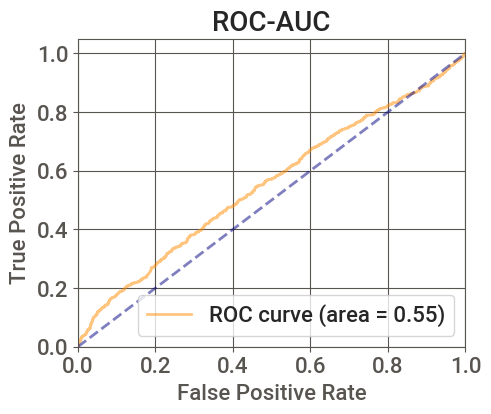

In [635]:
eval_pool = Pool(xy_m['x_valid'], xy_m['y_valid'],cat_features=columns_c)
curve = get_roc_curve(cbc_m, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 4))
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-AUC', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [636]:
y_predict = cbc_m.predict(xy_m['x_valid'])
print(classification_report(y_predict, xy_m['y_valid']))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      3522
           1       0.04      0.30      0.08        90

    accuracy                           0.82      3612
   macro avg       0.51      0.57      0.49      3612
weighted avg       0.96      0.82      0.88      3612



### CatBoostClassifier,  Gifts <a class="anchor" id="section_3_8"></a>

In [637]:
model_cb_g = CatBoostClassifier(loss_function='Logloss',early_stopping_rounds=20,
                              iterations=1000,random_seed=seed, eval_metric='AUC')
train_pool_g = Pool(xy_g['x_train'], xy_g['y_train'],cat_features=columns_c)
grid_cb_g = model_cb_g.grid_search(grid,
                                   train_pool_g
                                   )

0:	test: 0.1764706	best: 0.1764706 (0)	total: 52.3ms	remaining: 52.3s
1:	test: 0.1764706	best: 0.1764706 (0)	total: 62ms	remaining: 30.9s
2:	test: 0.1764706	best: 0.1764706 (0)	total: 82.7ms	remaining: 27.5s
3:	test: 0.2156863	best: 0.2156863 (3)	total: 131ms	remaining: 32.7s
4:	test: 0.2156863	best: 0.2156863 (3)	total: 142ms	remaining: 28.4s
5:	test: 0.1862745	best: 0.2156863 (3)	total: 198ms	remaining: 32.8s
6:	test: 0.1862745	best: 0.2156863 (3)	total: 213ms	remaining: 30.2s
7:	test: 0.1862745	best: 0.2156863 (3)	total: 265ms	remaining: 32.9s
8:	test: 0.1666667	best: 0.2156863 (3)	total: 282ms	remaining: 31.1s
9:	test: 0.1470588	best: 0.2156863 (3)	total: 337ms	remaining: 33.3s
10:	test: 0.1470588	best: 0.2156863 (3)	total: 372ms	remaining: 33.4s
11:	test: 0.1470588	best: 0.2156863 (3)	total: 395ms	remaining: 32.5s
12:	test: 0.2058824	best: 0.2156863 (3)	total: 451ms	remaining: 34.2s
13:	test: 0.2058824	best: 0.2156863 (3)	total: 525ms	remaining: 36.9s
14:	test: 0.1862745	best: 0.2

17:	test: 0.8039216	best: 0.8431373 (13)	total: 746ms	remaining: 40.7s
18:	test: 0.9215686	best: 0.9215686 (18)	total: 808ms	remaining: 41.7s
19:	test: 0.9019608	best: 0.9215686 (18)	total: 863ms	remaining: 42.3s
20:	test: 0.9607843	best: 0.9607843 (20)	total: 948ms	remaining: 44.2s
21:	test: 0.9607843	best: 0.9607843 (20)	total: 985ms	remaining: 43.8s
22:	test: 0.9607843	best: 0.9607843 (20)	total: 1.02s	remaining: 43.5s
23:	test: 0.9215686	best: 0.9607843 (20)	total: 1.09s	remaining: 44.5s
24:	test: 0.9215686	best: 0.9607843 (20)	total: 1.17s	remaining: 45.7s
25:	test: 0.9411765	best: 0.9607843 (20)	total: 1.25s	remaining: 47s
26:	test: 0.9411765	best: 0.9607843 (20)	total: 1.32s	remaining: 47.5s
27:	test: 0.9411765	best: 0.9607843 (20)	total: 1.33s	remaining: 46.3s
28:	test: 0.9215686	best: 0.9607843 (20)	total: 1.39s	remaining: 46.6s
29:	test: 0.9215686	best: 0.9607843 (20)	total: 1.45s	remaining: 47s
30:	test: 0.9215686	best: 0.9607843 (20)	total: 1.48s	remaining: 46.3s
31:	test: 

26:	test: 0.7843137	best: 0.7843137 (26)	total: 1.08s	remaining: 39.1s
27:	test: 0.8627451	best: 0.8627451 (27)	total: 1.14s	remaining: 39.7s
28:	test: 0.8431373	best: 0.8627451 (27)	total: 1.18s	remaining: 39.7s
29:	test: 0.8627451	best: 0.8627451 (27)	total: 1.23s	remaining: 39.7s
30:	test: 0.8627451	best: 0.8627451 (27)	total: 1.31s	remaining: 40.8s
31:	test: 0.8823529	best: 0.8823529 (31)	total: 1.37s	remaining: 41.5s
32:	test: 0.8627451	best: 0.8823529 (31)	total: 1.42s	remaining: 41.6s
33:	test: 0.8823529	best: 0.8823529 (31)	total: 1.49s	remaining: 42.5s
34:	test: 0.8823529	best: 0.8823529 (31)	total: 1.55s	remaining: 42.7s
35:	test: 0.8823529	best: 0.8823529 (31)	total: 1.58s	remaining: 42.3s
36:	test: 0.8823529	best: 0.8823529 (31)	total: 1.6s	remaining: 41.8s
37:	test: 0.8823529	best: 0.8823529 (31)	total: 1.62s	remaining: 41.1s
38:	test: 0.8823529	best: 0.8823529 (31)	total: 1.67s	remaining: 41.2s
39:	test: 0.8823529	best: 0.8823529 (31)	total: 1.71s	remaining: 41.1s
40:	tes

17:	test: 0.5588235	best: 0.5882353 (12)	total: 619ms	remaining: 33.8s
18:	test: 0.5588235	best: 0.5882353 (12)	total: 688ms	remaining: 35.5s
19:	test: 0.5588235	best: 0.5882353 (12)	total: 708ms	remaining: 34.7s
20:	test: 0.5784314	best: 0.5882353 (12)	total: 768ms	remaining: 35.8s
21:	test: 0.5784314	best: 0.5882353 (12)	total: 783ms	remaining: 34.8s
22:	test: 0.5980392	best: 0.5980392 (22)	total: 828ms	remaining: 35.2s
23:	test: 0.6568627	best: 0.6568627 (23)	total: 884ms	remaining: 36s
24:	test: 0.7156863	best: 0.7156863 (24)	total: 927ms	remaining: 36.2s
25:	test: 0.6960784	best: 0.7156863 (24)	total: 982ms	remaining: 36.8s
26:	test: 0.6960784	best: 0.7156863 (24)	total: 992ms	remaining: 35.7s
27:	test: 0.6862745	best: 0.7156863 (24)	total: 1.04s	remaining: 36s
28:	test: 0.6862745	best: 0.7156863 (24)	total: 1.05s	remaining: 35s
29:	test: 0.6862745	best: 0.7156863 (24)	total: 1.06s	remaining: 34.2s
30:	test: 0.6470588	best: 0.7156863 (24)	total: 1.11s	remaining: 34.9s
31:	test: 0.

64:	test: 0.9803922	best: 0.9803922 (57)	total: 3.24s	remaining: 46.6s
65:	test: 0.9803922	best: 0.9803922 (57)	total: 3.3s	remaining: 46.7s
66:	test: 0.9803922	best: 0.9803922 (57)	total: 3.36s	remaining: 46.8s
67:	test: 0.9803922	best: 0.9803922 (57)	total: 3.44s	remaining: 47.1s
68:	test: 0.9803922	best: 0.9803922 (57)	total: 3.52s	remaining: 47.5s
69:	test: 0.9803922	best: 0.9803922 (57)	total: 3.58s	remaining: 47.6s
70:	test: 0.9803922	best: 0.9803922 (57)	total: 3.63s	remaining: 47.6s
71:	test: 0.9803922	best: 0.9803922 (57)	total: 3.69s	remaining: 47.5s
72:	test: 0.9803922	best: 0.9803922 (57)	total: 3.75s	remaining: 47.7s
73:	test: 0.9803922	best: 0.9803922 (57)	total: 3.82s	remaining: 47.8s
74:	test: 1.0000000	best: 1.0000000 (74)	total: 3.88s	remaining: 47.8s
75:	test: 1.0000000	best: 1.0000000 (74)	total: 3.94s	remaining: 47.9s
76:	test: 1.0000000	best: 1.0000000 (74)	total: 4.01s	remaining: 48s
77:	test: 1.0000000	best: 1.0000000 (74)	total: 4.06s	remaining: 48s
78:	test: 1

4:	test: 0.3627451	best: 0.3627451 (4)	total: 168ms	remaining: 33.4s
5:	test: 0.3627451	best: 0.3627451 (4)	total: 194ms	remaining: 32.1s
6:	test: 0.3627451	best: 0.3627451 (4)	total: 212ms	remaining: 30.1s
7:	test: 0.3627451	best: 0.3627451 (4)	total: 221ms	remaining: 27.4s
8:	test: 0.3333333	best: 0.3627451 (4)	total: 276ms	remaining: 30.3s
9:	test: 0.3333333	best: 0.3627451 (4)	total: 298ms	remaining: 29.5s
10:	test: 0.3333333	best: 0.3627451 (4)	total: 322ms	remaining: 29s
11:	test: 0.3333333	best: 0.3627451 (4)	total: 369ms	remaining: 30.4s
12:	test: 0.3333333	best: 0.3627451 (4)	total: 388ms	remaining: 29.4s
13:	test: 0.3333333	best: 0.3627451 (4)	total: 403ms	remaining: 28.4s
14:	test: 0.3333333	best: 0.3627451 (4)	total: 418ms	remaining: 27.4s
15:	test: 0.0490196	best: 0.3627451 (4)	total: 472ms	remaining: 29s
16:	test: 0.2450980	best: 0.3627451 (4)	total: 539ms	remaining: 31.1s
17:	test: 0.2450980	best: 0.3627451 (4)	total: 590ms	remaining: 32.2s
18:	test: 0.2450980	best: 0.36

28:	test: 0.9607843	best: 0.9607843 (28)	total: 1.14s	remaining: 38s
29:	test: 0.9607843	best: 0.9607843 (28)	total: 1.17s	remaining: 37.7s
30:	test: 0.9607843	best: 0.9607843 (28)	total: 1.23s	remaining: 38.4s
31:	test: 0.9607843	best: 0.9607843 (28)	total: 1.28s	remaining: 38.8s
32:	test: 0.9607843	best: 0.9607843 (28)	total: 1.34s	remaining: 39.2s
33:	test: 0.9607843	best: 0.9607843 (28)	total: 1.39s	remaining: 39.6s
34:	test: 0.9607843	best: 0.9607843 (28)	total: 1.42s	remaining: 39.1s
35:	test: 0.9607843	best: 0.9607843 (28)	total: 1.48s	remaining: 39.6s
36:	test: 0.9607843	best: 0.9607843 (28)	total: 1.54s	remaining: 40.1s
37:	test: 0.9607843	best: 0.9607843 (28)	total: 1.58s	remaining: 39.9s
38:	test: 0.9607843	best: 0.9607843 (28)	total: 1.64s	remaining: 40.4s
39:	test: 0.9607843	best: 0.9607843 (28)	total: 1.66s	remaining: 39.9s
40:	test: 0.9607843	best: 0.9607843 (28)	total: 1.72s	remaining: 40.1s
41:	test: 0.9607843	best: 0.9607843 (28)	total: 1.78s	remaining: 40.6s
42:	test

5:	test: 0.2843137	best: 0.2843137 (4)	total: 166ms	remaining: 27.5s
6:	test: 0.2843137	best: 0.2843137 (4)	total: 182ms	remaining: 25.9s
7:	test: 0.2647059	best: 0.2843137 (4)	total: 199ms	remaining: 24.7s
8:	test: 0.2647059	best: 0.2843137 (4)	total: 216ms	remaining: 23.8s
9:	test: 0.2647059	best: 0.2843137 (4)	total: 244ms	remaining: 24.2s
10:	test: 0.2647059	best: 0.2843137 (4)	total: 306ms	remaining: 27.6s
11:	test: 0.2647059	best: 0.2843137 (4)	total: 376ms	remaining: 30.9s
12:	test: 0.5098039	best: 0.5098039 (12)	total: 433ms	remaining: 32.9s
13:	test: 0.5098039	best: 0.5098039 (12)	total: 488ms	remaining: 34.4s
14:	test: 0.5098039	best: 0.5098039 (12)	total: 556ms	remaining: 36.5s
15:	test: 0.5098039	best: 0.5098039 (12)	total: 564ms	remaining: 34.7s
16:	test: 0.6666667	best: 0.6666667 (16)	total: 623ms	remaining: 36s
17:	test: 0.6666667	best: 0.6666667 (16)	total: 708ms	remaining: 38.6s
18:	test: 0.6862745	best: 0.6862745 (18)	total: 753ms	remaining: 38.9s
19:	test: 0.6274510	

55:	test: 0.7647059	best: 0.7843137 (48)	total: 2.24s	remaining: 37.8s
56:	test: 0.7647059	best: 0.7843137 (48)	total: 2.29s	remaining: 37.8s
57:	test: 0.5686275	best: 0.7843137 (48)	total: 2.36s	remaining: 38.4s
58:	test: 0.5686275	best: 0.7843137 (48)	total: 2.38s	remaining: 38s
59:	test: 0.7254902	best: 0.7843137 (48)	total: 2.47s	remaining: 38.7s
60:	test: 0.7254902	best: 0.7843137 (48)	total: 2.49s	remaining: 38.3s
61:	test: 0.7647059	best: 0.7843137 (48)	total: 2.53s	remaining: 38.3s
62:	test: 0.7647059	best: 0.7843137 (48)	total: 2.56s	remaining: 38.1s
63:	test: 0.8823529	best: 0.8823529 (63)	total: 2.65s	remaining: 38.7s
64:	test: 0.8823529	best: 0.8823529 (63)	total: 2.73s	remaining: 39.3s
65:	test: 0.8823529	best: 0.8823529 (63)	total: 2.75s	remaining: 39s
66:	test: 0.8823529	best: 0.8823529 (63)	total: 2.84s	remaining: 39.5s
67:	test: 0.9019608	best: 0.9019608 (67)	total: 2.92s	remaining: 40s
68:	test: 0.8823529	best: 0.9019608 (67)	total: 3.02s	remaining: 40.7s
69:	test: 0.

47:	test: 1.0000000	best: 1.0000000 (33)	total: 2.28s	remaining: 45.2s
48:	test: 1.0000000	best: 1.0000000 (33)	total: 2.37s	remaining: 45.9s
49:	test: 1.0000000	best: 1.0000000 (33)	total: 2.45s	remaining: 46.6s
50:	test: 1.0000000	best: 1.0000000 (33)	total: 2.54s	remaining: 47.2s
51:	test: 1.0000000	best: 1.0000000 (33)	total: 2.57s	remaining: 46.8s
52:	test: 1.0000000	best: 1.0000000 (33)	total: 2.65s	remaining: 47.4s
53:	test: 1.0000000	best: 1.0000000 (33)	total: 2.73s	remaining: 47.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1
bestIteration = 33

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
16:	loss: 1.0000000	best: 1.0000000 (7)	total: 50.1s	remaining: 2m 6s
0:	test: 0.1764706	best: 0.1764706 (0)	total: 27ms	remaining: 26.9s
1:	test: 0.1764706	best: 0.1764706 (0)	total: 36.9ms	remaining: 18.4s
2:	test: 0.1764706	best: 0.1764706 (0)	total: 61.1ms	remaining: 20.3s
3:	

44:	test: 0.8627451	best: 0.8627451 (39)	total: 1.7s	remaining: 36.1s
45:	test: 0.8627451	best: 0.8627451 (39)	total: 1.71s	remaining: 35.5s
46:	test: 0.9215686	best: 0.9215686 (46)	total: 1.81s	remaining: 36.6s
47:	test: 0.9215686	best: 0.9215686 (46)	total: 1.87s	remaining: 37s
48:	test: 0.9215686	best: 0.9215686 (46)	total: 1.91s	remaining: 37s
49:	test: 0.9215686	best: 0.9215686 (46)	total: 1.95s	remaining: 37.1s
50:	test: 0.9411765	best: 0.9411765 (50)	total: 2.04s	remaining: 37.9s
51:	test: 0.9215686	best: 0.9411765 (50)	total: 2.1s	remaining: 38.2s
52:	test: 0.9215686	best: 0.9411765 (50)	total: 2.1s	remaining: 37.6s
53:	test: 0.9215686	best: 0.9411765 (50)	total: 2.14s	remaining: 37.5s
54:	test: 0.9019608	best: 0.9411765 (50)	total: 2.2s	remaining: 37.9s
55:	test: 0.9607843	best: 0.9607843 (55)	total: 2.29s	remaining: 38.6s
56:	test: 0.9607843	best: 0.9607843 (55)	total: 2.35s	remaining: 38.8s
57:	test: 0.9607843	best: 0.9607843 (55)	total: 2.43s	remaining: 39.5s
58:	test: 0.96

2:	test: 0.1764706	best: 0.1764706 (2)	total: 52.1ms	remaining: 17.3s
3:	test: 0.1568627	best: 0.1764706 (2)	total: 94.1ms	remaining: 23.4s
4:	test: 0.3431373	best: 0.3431373 (4)	total: 181ms	remaining: 36.1s
5:	test: 0.3431373	best: 0.3431373 (4)	total: 211ms	remaining: 34.9s
6:	test: 0.3431373	best: 0.3431373 (4)	total: 219ms	remaining: 31s
7:	test: 0.4019608	best: 0.4019608 (7)	total: 310ms	remaining: 38.5s
8:	test: 0.4215686	best: 0.4215686 (8)	total: 327ms	remaining: 36s
9:	test: 0.4215686	best: 0.4215686 (8)	total: 395ms	remaining: 39.1s
10:	test: 0.4215686	best: 0.4215686 (8)	total: 432ms	remaining: 38.8s
11:	test: 0.6274510	best: 0.6274510 (11)	total: 453ms	remaining: 37.3s
12:	test: 0.6274510	best: 0.6274510 (11)	total: 503ms	remaining: 38.2s
13:	test: 0.6666667	best: 0.6666667 (13)	total: 542ms	remaining: 38.1s
14:	test: 0.6666667	best: 0.6666667 (13)	total: 557ms	remaining: 36.6s
15:	test: 0.6666667	best: 0.6666667 (13)	total: 608ms	remaining: 37.4s
16:	test: 0.6372549	best:

54:	test: 0.7450980	best: 0.7647059 (49)	total: 2.23s	remaining: 38.3s
55:	test: 0.7647059	best: 0.7647059 (49)	total: 2.29s	remaining: 38.5s
56:	test: 0.7647059	best: 0.7647059 (49)	total: 2.34s	remaining: 38.7s
57:	test: 0.7647059	best: 0.7647059 (49)	total: 2.42s	remaining: 39.3s
58:	test: 0.7647059	best: 0.7647059 (49)	total: 2.43s	remaining: 38.8s
59:	test: 0.7647059	best: 0.7647059 (49)	total: 2.47s	remaining: 38.7s
60:	test: 0.8235294	best: 0.8235294 (60)	total: 2.54s	remaining: 39.1s
61:	test: 0.8235294	best: 0.8235294 (60)	total: 2.64s	remaining: 40s
62:	test: 0.8235294	best: 0.8235294 (60)	total: 2.7s	remaining: 40.1s
63:	test: 0.8431373	best: 0.8431373 (63)	total: 2.78s	remaining: 40.7s
64:	test: 0.7450980	best: 0.8431373 (63)	total: 2.87s	remaining: 41.4s
65:	test: 0.7254902	best: 0.8431373 (63)	total: 2.91s	remaining: 41.2s
66:	test: 0.7058824	best: 0.8431373 (63)	total: 2.99s	remaining: 41.7s
67:	test: 0.7058824	best: 0.8431373 (63)	total: 3.01s	remaining: 41.2s
68:	test:

34:	test: 0.9215686	best: 0.9411765 (21)	total: 1.74s	remaining: 48s
35:	test: 0.9215686	best: 0.9411765 (21)	total: 1.78s	remaining: 47.6s
36:	test: 0.9215686	best: 0.9411765 (21)	total: 1.86s	remaining: 48.4s
37:	test: 0.9215686	best: 0.9411765 (21)	total: 1.94s	remaining: 49.1s
38:	test: 0.9215686	best: 0.9411765 (21)	total: 2.03s	remaining: 50.1s
39:	test: 0.9215686	best: 0.9411765 (21)	total: 2.12s	remaining: 50.8s
40:	test: 0.9215686	best: 0.9411765 (21)	total: 2.19s	remaining: 51.3s
41:	test: 0.9411765	best: 0.9411765 (21)	total: 2.27s	remaining: 51.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9411764706
bestIteration = 21

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
23:	loss: 0.9411765	best: 1.0000000 (7)	total: 1m 14s	remaining: 1m 51s
0:	test: 0.1568627	best: 0.1568627 (0)	total: 21.4ms	remaining: 21.4s
1:	test: 0.1568627	best: 0.1568627 (0)	total: 31.9ms	remain

0:	test: 0.1568627	best: 0.1568627 (0)	total: 21.5ms	remaining: 21.5s
1:	test: 0.1568627	best: 0.1568627 (0)	total: 30.8ms	remaining: 15.4s
2:	test: 0.1568627	best: 0.1568627 (0)	total: 54.5ms	remaining: 18.1s
3:	test: 0.1372549	best: 0.1568627 (0)	total: 96.1ms	remaining: 23.9s
4:	test: 0.3627451	best: 0.3627451 (4)	total: 132ms	remaining: 26.3s
5:	test: 0.3627451	best: 0.3627451 (4)	total: 147ms	remaining: 24.4s
6:	test: 0.3627451	best: 0.3627451 (4)	total: 162ms	remaining: 23s
7:	test: 0.3627451	best: 0.3627451 (4)	total: 207ms	remaining: 25.7s
8:	test: 0.3627451	best: 0.3627451 (4)	total: 245ms	remaining: 26.9s
9:	test: 0.3627451	best: 0.3627451 (4)	total: 253ms	remaining: 25s
10:	test: 0.3627451	best: 0.3627451 (4)	total: 262ms	remaining: 23.5s
11:	test: 0.4019608	best: 0.4019608 (11)	total: 285ms	remaining: 23.4s
12:	test: 0.4019608	best: 0.4019608 (11)	total: 308ms	remaining: 23.4s
13:	test: 0.4019608	best: 0.4019608 (11)	total: 322ms	remaining: 22.7s
14:	test: 0.4215686	best: 0

38:	test: 0.5294118	best: 0.5294118 (38)	total: 1.39s	remaining: 34.2s
39:	test: 0.5294118	best: 0.5294118 (38)	total: 1.4s	remaining: 33.6s
40:	test: 0.5294118	best: 0.5294118 (38)	total: 1.49s	remaining: 34.8s
41:	test: 0.5294118	best: 0.5294118 (38)	total: 1.52s	remaining: 34.6s
42:	test: 0.5294118	best: 0.5294118 (38)	total: 1.59s	remaining: 35.5s
43:	test: 0.5294118	best: 0.5294118 (38)	total: 1.6s	remaining: 34.8s
44:	test: 0.5490196	best: 0.5490196 (44)	total: 1.68s	remaining: 35.7s
45:	test: 0.5490196	best: 0.5490196 (44)	total: 1.74s	remaining: 36.2s
46:	test: 0.5490196	best: 0.5490196 (44)	total: 1.78s	remaining: 36.1s
47:	test: 0.5490196	best: 0.5490196 (44)	total: 1.87s	remaining: 37s
48:	test: 0.6078431	best: 0.6078431 (48)	total: 1.95s	remaining: 37.8s
49:	test: 0.6078431	best: 0.6078431 (48)	total: 2.03s	remaining: 38.5s
50:	test: 0.5882353	best: 0.6078431 (48)	total: 2.08s	remaining: 38.6s
51:	test: 0.5882353	best: 0.6078431 (48)	total: 2.16s	remaining: 39.4s
52:	test: 

33:	test: 0.5882353	best: 0.5882353 (33)	total: 1.34s	remaining: 38s
34:	test: 0.6078431	best: 0.6078431 (34)	total: 1.39s	remaining: 38.4s
35:	test: 0.6470588	best: 0.6470588 (35)	total: 1.48s	remaining: 39.5s
36:	test: 0.6078431	best: 0.6470588 (35)	total: 1.53s	remaining: 39.8s
37:	test: 0.7843137	best: 0.7843137 (37)	total: 1.62s	remaining: 40.9s
38:	test: 0.7647059	best: 0.7843137 (37)	total: 1.68s	remaining: 41.4s
39:	test: 0.7647059	best: 0.7843137 (37)	total: 1.77s	remaining: 42.4s
40:	test: 0.7647059	best: 0.7843137 (37)	total: 1.85s	remaining: 43.3s
41:	test: 0.7647059	best: 0.7843137 (37)	total: 1.91s	remaining: 43.6s
42:	test: 0.7647059	best: 0.7843137 (37)	total: 1.97s	remaining: 43.9s
43:	test: 0.7647059	best: 0.7843137 (37)	total: 2.01s	remaining: 43.8s
44:	test: 0.7450980	best: 0.7843137 (37)	total: 2.06s	remaining: 43.6s
45:	test: 0.7450980	best: 0.7843137 (37)	total: 2.14s	remaining: 44.5s
46:	test: 0.7450980	best: 0.7843137 (37)	total: 2.17s	remaining: 44.1s
47:	test

5:	test: 0.1666667	best: 0.2156863 (3)	total: 245ms	remaining: 40.6s
6:	test: 0.1666667	best: 0.2156863 (3)	total: 253ms	remaining: 35.9s
7:	test: 0.1666667	best: 0.2156863 (3)	total: 260ms	remaining: 32.3s
8:	test: 0.1274510	best: 0.2156863 (3)	total: 492ms	remaining: 54.2s
9:	test: 0.1274510	best: 0.2156863 (3)	total: 500ms	remaining: 49.5s
10:	test: 0.1274510	best: 0.2156863 (3)	total: 521ms	remaining: 46.8s
11:	test: 0.1274510	best: 0.2156863 (3)	total: 544ms	remaining: 44.8s
12:	test: 0.1274510	best: 0.2156863 (3)	total: 595ms	remaining: 45.2s
13:	test: 0.1666667	best: 0.2156863 (3)	total: 649ms	remaining: 45.7s
14:	test: 0.1666667	best: 0.2156863 (3)	total: 656ms	remaining: 43.1s
15:	test: 0.1666667	best: 0.2156863 (3)	total: 678ms	remaining: 41.7s
16:	test: 0.1666667	best: 0.2156863 (3)	total: 693ms	remaining: 40.1s
17:	test: 0.1666667	best: 0.2156863 (3)	total: 723ms	remaining: 39.4s
18:	test: 0.1764706	best: 0.2156863 (3)	total: 825ms	remaining: 42.6s
19:	test: 0.1764706	best:

14:	test: 0.3627451	best: 0.4411765 (9)	total: 1.44s	remaining: 1m 34s
15:	test: 0.3039216	best: 0.4411765 (9)	total: 1.6s	remaining: 1m 38s
16:	test: 0.7843137	best: 0.7843137 (16)	total: 2.26s	remaining: 2m 10s
17:	test: 0.7843137	best: 0.7843137 (16)	total: 2.29s	remaining: 2m 4s
18:	test: 0.8333333	best: 0.8333333 (18)	total: 2.95s	remaining: 2m 32s
19:	test: 0.8333333	best: 0.8333333 (18)	total: 2.97s	remaining: 2m 25s
20:	test: 0.8333333	best: 0.8333333 (18)	total: 2.99s	remaining: 2m 19s
21:	test: 0.8333333	best: 0.8333333 (18)	total: 3.04s	remaining: 2m 15s
22:	test: 0.8137255	best: 0.8333333 (18)	total: 3.66s	remaining: 2m 35s
23:	test: 0.8431373	best: 0.8431373 (23)	total: 4s	remaining: 2m 42s
24:	test: 0.8431373	best: 0.8431373 (23)	total: 4.37s	remaining: 2m 50s
25:	test: 0.8431373	best: 0.8431373 (23)	total: 4.4s	remaining: 2m 44s
26:	test: 0.8431373	best: 0.8431373 (23)	total: 5.07s	remaining: 3m 2s
27:	test: 0.8431373	best: 0.8431373 (23)	total: 5.09s	remaining: 2m 56s
2

71:	test: 0.9215686	best: 0.9215686 (62)	total: 7.37s	remaining: 1m 35s
72:	test: 0.9215686	best: 0.9215686 (62)	total: 7.45s	remaining: 1m 34s
73:	test: 0.9215686	best: 0.9215686 (62)	total: 7.55s	remaining: 1m 34s
74:	test: 0.9215686	best: 0.9215686 (62)	total: 7.57s	remaining: 1m 33s
75:	test: 0.9215686	best: 0.9215686 (62)	total: 7.63s	remaining: 1m 32s
76:	test: 0.9215686	best: 0.9215686 (62)	total: 7.68s	remaining: 1m 32s
77:	test: 0.9411765	best: 0.9411765 (77)	total: 7.74s	remaining: 1m 31s
78:	test: 0.9411765	best: 0.9411765 (77)	total: 7.77s	remaining: 1m 30s
79:	test: 0.9411765	best: 0.9411765 (77)	total: 7.81s	remaining: 1m 29s
80:	test: 0.9607843	best: 0.9607843 (80)	total: 8.52s	remaining: 1m 36s
81:	test: 0.9411765	best: 0.9607843 (80)	total: 8.62s	remaining: 1m 36s
82:	test: 0.9411765	best: 0.9607843 (80)	total: 8.65s	remaining: 1m 35s
83:	test: 0.9411765	best: 0.9607843 (80)	total: 8.68s	remaining: 1m 34s
84:	test: 0.9411765	best: 0.9607843 (80)	total: 8.75s	remaining:

59:	test: 0.8823529	best: 0.9019608 (56)	total: 4.6s	remaining: 1m 12s
60:	test: 0.8823529	best: 0.9019608 (56)	total: 4.68s	remaining: 1m 12s
61:	test: 0.9019608	best: 0.9019608 (56)	total: 5.3s	remaining: 1m 20s
62:	test: 0.9019608	best: 0.9019608 (56)	total: 5.93s	remaining: 1m 28s
63:	test: 0.9019608	best: 0.9019608 (56)	total: 6.02s	remaining: 1m 28s
64:	test: 0.9215686	best: 0.9215686 (64)	total: 6.08s	remaining: 1m 27s
65:	test: 0.9803922	best: 0.9803922 (65)	total: 6.13s	remaining: 1m 26s
66:	test: 0.9803922	best: 0.9803922 (65)	total: 6.77s	remaining: 1m 34s
67:	test: 0.9803922	best: 0.9803922 (65)	total: 7.5s	remaining: 1m 42s
68:	test: 0.9803922	best: 0.9803922 (65)	total: 7.86s	remaining: 1m 46s
69:	test: 0.9803922	best: 0.9803922 (65)	total: 8.5s	remaining: 1m 52s
70:	test: 0.9803922	best: 0.9803922 (65)	total: 9.15s	remaining: 1m 59s
71:	test: 0.9803922	best: 0.9803922 (65)	total: 9.77s	remaining: 2m 5s
72:	test: 0.9411765	best: 0.9803922 (65)	total: 10.4s	remaining: 2m 1

4:	test: 0.3823529	best: 0.3823529 (4)	total: 117ms	remaining: 23.2s
5:	test: 0.3823529	best: 0.3823529 (4)	total: 142ms	remaining: 23.5s
6:	test: 0.3823529	best: 0.3823529 (4)	total: 150ms	remaining: 21.3s
7:	test: 0.3921569	best: 0.3921569 (7)	total: 198ms	remaining: 24.5s
8:	test: 0.4901961	best: 0.4901961 (8)	total: 850ms	remaining: 1m 33s
9:	test: 0.6372549	best: 0.6372549 (9)	total: 892ms	remaining: 1m 28s
10:	test: 0.6568627	best: 0.6568627 (10)	total: 936ms	remaining: 1m 24s
11:	test: 0.6568627	best: 0.6568627 (10)	total: 945ms	remaining: 1m 17s
12:	test: 0.6568627	best: 0.6568627 (10)	total: 959ms	remaining: 1m 12s
13:	test: 0.6568627	best: 0.6568627 (10)	total: 974ms	remaining: 1m 8s
14:	test: 0.6568627	best: 0.6568627 (10)	total: 987ms	remaining: 1m 4s
15:	test: 0.6568627	best: 0.6568627 (10)	total: 995ms	remaining: 1m 1s
16:	test: 0.6176471	best: 0.6568627 (10)	total: 1.07s	remaining: 1m 1s
17:	test: 0.6372549	best: 0.6568627 (10)	total: 1.12s	remaining: 1m
18:	test: 0.6568

2:	test: 0.1568627	best: 0.1568627 (0)	total: 57.6ms	remaining: 19.2s
3:	test: 0.1078431	best: 0.1568627 (0)	total: 127ms	remaining: 31.5s
4:	test: 0.3627451	best: 0.3627451 (4)	total: 165ms	remaining: 32.7s
5:	test: 0.3627451	best: 0.3627451 (4)	total: 185ms	remaining: 30.6s
6:	test: 0.3627451	best: 0.3627451 (4)	total: 193ms	remaining: 27.3s
7:	test: 0.3627451	best: 0.3627451 (4)	total: 200ms	remaining: 24.8s
8:	test: 0.3333333	best: 0.3627451 (4)	total: 259ms	remaining: 28.5s
9:	test: 0.0686275	best: 0.3627451 (4)	total: 274ms	remaining: 27.1s
10:	test: 0.5392157	best: 0.5392157 (10)	total: 335ms	remaining: 30.1s
11:	test: 0.5392157	best: 0.5392157 (10)	total: 344ms	remaining: 28.3s
12:	test: 0.5392157	best: 0.5392157 (10)	total: 358ms	remaining: 27.2s
13:	test: 0.5392157	best: 0.5392157 (10)	total: 366ms	remaining: 25.7s
14:	test: 0.5392157	best: 0.5392157 (10)	total: 382ms	remaining: 25.1s
15:	test: 0.4215686	best: 0.5392157 (10)	total: 412ms	remaining: 25.3s
16:	test: 0.4215686	b

32:	test: 0.6372549	best: 0.6372549 (27)	total: 1.62s	remaining: 47.4s
33:	test: 0.6372549	best: 0.6372549 (27)	total: 1.64s	remaining: 46.6s
34:	test: 0.6764706	best: 0.6764706 (34)	total: 1.67s	remaining: 46s
35:	test: 0.6764706	best: 0.6764706 (34)	total: 1.75s	remaining: 47s
36:	test: 0.7058824	best: 0.7058824 (36)	total: 1.81s	remaining: 47.1s
37:	test: 0.7058824	best: 0.7058824 (36)	total: 1.83s	remaining: 46.4s
38:	test: 0.7450980	best: 0.7450980 (38)	total: 2.47s	remaining: 1m
39:	test: 0.8039216	best: 0.8039216 (39)	total: 2.69s	remaining: 1m 4s
40:	test: 0.8431373	best: 0.8431373 (40)	total: 2.78s	remaining: 1m 5s
41:	test: 0.8431373	best: 0.8431373 (40)	total: 2.81s	remaining: 1m 4s
42:	test: 0.8431373	best: 0.8431373 (40)	total: 2.83s	remaining: 1m 3s
43:	test: 0.8431373	best: 0.8431373 (40)	total: 2.85s	remaining: 1m 1s
44:	test: 0.8431373	best: 0.8431373 (40)	total: 2.88s	remaining: 1m 1s
45:	test: 0.8431373	best: 0.8431373 (40)	total: 2.94s	remaining: 1m
46:	test: 0.8235

44:	test: 0.9215686	best: 0.9215686 (42)	total: 8.97s	remaining: 3m 10s
45:	test: 0.9215686	best: 0.9215686 (42)	total: 9.7s	remaining: 3m 21s
46:	test: 0.9215686	best: 0.9215686 (42)	total: 10.5s	remaining: 3m 32s
47:	test: 0.9215686	best: 0.9215686 (42)	total: 11.2s	remaining: 3m 42s
48:	test: 0.9215686	best: 0.9215686 (42)	total: 12s	remaining: 3m 53s
49:	test: 0.9215686	best: 0.9215686 (42)	total: 12.1s	remaining: 3m 50s
50:	test: 0.9215686	best: 0.9215686 (42)	total: 12.8s	remaining: 3m 57s
51:	test: 0.9215686	best: 0.9215686 (42)	total: 13.4s	remaining: 4m 4s
52:	test: 0.9215686	best: 0.9215686 (42)	total: 13.8s	remaining: 4m 7s
53:	test: 0.9215686	best: 0.9215686 (42)	total: 14.5s	remaining: 4m 13s
54:	test: 0.9215686	best: 0.9215686 (42)	total: 15.2s	remaining: 4m 21s
55:	test: 0.9215686	best: 0.9215686 (42)	total: 15.9s	remaining: 4m 28s
56:	test: 0.9215686	best: 0.9215686 (42)	total: 16.7s	remaining: 4m 36s
57:	test: 0.9215686	best: 0.9215686 (42)	total: 17.4s	remaining: 4m 4

35:	test: 0.5490196	best: 0.5490196 (29)	total: 3.48s	remaining: 1m 33s
36:	test: 0.6666667	best: 0.6666667 (36)	total: 3.51s	remaining: 1m 31s
37:	test: 0.6666667	best: 0.6666667 (36)	total: 3.54s	remaining: 1m 29s
38:	test: 0.6666667	best: 0.6666667 (36)	total: 3.57s	remaining: 1m 28s
39:	test: 0.7647059	best: 0.7647059 (39)	total: 3.62s	remaining: 1m 26s
40:	test: 0.7843137	best: 0.7843137 (40)	total: 3.66s	remaining: 1m 25s
41:	test: 0.7450980	best: 0.7843137 (40)	total: 4.07s	remaining: 1m 32s
42:	test: 0.7450980	best: 0.7843137 (40)	total: 4.12s	remaining: 1m 31s
43:	test: 0.7450980	best: 0.7843137 (40)	total: 4.83s	remaining: 1m 45s
44:	test: 0.7450980	best: 0.7843137 (40)	total: 4.88s	remaining: 1m 43s
45:	test: 0.7450980	best: 0.7843137 (40)	total: 4.92s	remaining: 1m 42s
46:	test: 0.7647059	best: 0.7843137 (40)	total: 5.67s	remaining: 1m 54s
47:	test: 0.7647059	best: 0.7843137 (40)	total: 5.71s	remaining: 1m 53s
48:	test: 0.7647059	best: 0.7843137 (40)	total: 5.75s	remaining:

19:	test: 0.7567901	best: 0.8888889 (13)	total: 867ms	remaining: 42.5s
20:	test: 0.7395062	best: 0.8888889 (13)	total: 925ms	remaining: 43.1s
21:	test: 0.7444444	best: 0.8888889 (13)	total: 987ms	remaining: 43.9s
22:	test: 0.6925926	best: 0.8888889 (13)	total: 1.06s	remaining: 45.1s
23:	test: 0.6629630	best: 0.8888889 (13)	total: 1.14s	remaining: 46.5s
24:	test: 0.6456790	best: 0.8888889 (13)	total: 1.22s	remaining: 47.5s
25:	test: 0.6506173	best: 0.8888889 (13)	total: 1.29s	remaining: 48.3s
26:	test: 0.6185185	best: 0.8888889 (13)	total: 1.36s	remaining: 49s
27:	test: 0.6283951	best: 0.8888889 (13)	total: 1.42s	remaining: 49.3s
28:	test: 0.6086420	best: 0.8888889 (13)	total: 1.49s	remaining: 49.9s
29:	test: 0.5987654	best: 0.8888889 (13)	total: 1.56s	remaining: 50.5s
30:	test: 0.5765432	best: 0.8888889 (13)	total: 1.6s	remaining: 50s
31:	test: 0.5938272	best: 0.8888889 (13)	total: 1.66s	remaining: 50.2s
32:	test: 0.5913580	best: 0.8888889 (13)	total: 1.72s	remaining: 50.5s
33:	test: 0

In [638]:
model_cb_g.get_params()

{'iterations': 1000,
 'loss_function': 'Logloss',
 'random_seed': 123,
 'eval_metric': 'AUC',
 'early_stopping_rounds': 20,
 'depth': 7,
 'l2_leaf_reg': 5,
 'learning_rate': 0.1}

0:	total: 67.6ms	remaining: 1m 7s
1:	total: 123ms	remaining: 1m 1s
2:	total: 146ms	remaining: 48.6s
3:	total: 162ms	remaining: 40.3s
4:	total: 227ms	remaining: 45.2s
5:	total: 272ms	remaining: 45.1s
6:	total: 296ms	remaining: 42s
7:	total: 346ms	remaining: 42.9s
8:	total: 371ms	remaining: 40.9s
9:	total: 414ms	remaining: 41s
10:	total: 428ms	remaining: 38.5s
11:	total: 440ms	remaining: 36.2s
12:	total: 503ms	remaining: 38.2s
13:	total: 512ms	remaining: 36s
14:	total: 564ms	remaining: 37s
15:	total: 622ms	remaining: 38.3s
16:	total: 692ms	remaining: 40s
17:	total: 755ms	remaining: 41.2s
18:	total: 818ms	remaining: 42.2s
19:	total: 834ms	remaining: 40.9s
20:	total: 858ms	remaining: 40s
21:	total: 912ms	remaining: 40.5s
22:	total: 967ms	remaining: 41.1s
23:	total: 1.04s	remaining: 42.2s
24:	total: 1.09s	remaining: 42.5s
25:	total: 1.1s	remaining: 41.1s
26:	total: 1.14s	remaining: 41s
27:	total: 1.18s	remaining: 41s
28:	total: 1.25s	remaining: 41.8s
29:	total: 1.31s	remaining: 42.5s
30:	to

243:	total: 13.7s	remaining: 42.4s
244:	total: 13.8s	remaining: 42.4s
245:	total: 13.8s	remaining: 42.3s
246:	total: 13.8s	remaining: 42.2s
247:	total: 13.9s	remaining: 42.1s
248:	total: 14s	remaining: 42.1s
249:	total: 14s	remaining: 42s
250:	total: 14.1s	remaining: 42s
251:	total: 14.1s	remaining: 41.9s
252:	total: 14.2s	remaining: 41.8s
253:	total: 14.2s	remaining: 41.8s
254:	total: 14.3s	remaining: 41.7s
255:	total: 14.3s	remaining: 41.7s
256:	total: 14.4s	remaining: 41.6s
257:	total: 14.4s	remaining: 41.5s
258:	total: 14.5s	remaining: 41.5s
259:	total: 14.6s	remaining: 41.4s
260:	total: 14.6s	remaining: 41.4s
261:	total: 14.6s	remaining: 41.2s
262:	total: 14.7s	remaining: 41.2s
263:	total: 14.7s	remaining: 41.1s
264:	total: 14.8s	remaining: 41s
265:	total: 14.8s	remaining: 41s
266:	total: 14.9s	remaining: 40.9s
267:	total: 15s	remaining: 40.9s
268:	total: 15s	remaining: 40.8s
269:	total: 15.1s	remaining: 40.8s
270:	total: 15.1s	remaining: 40.7s
271:	total: 15.2s	remaining: 40.6s
2

482:	total: 27.6s	remaining: 29.5s
483:	total: 27.6s	remaining: 29.4s
484:	total: 27.7s	remaining: 29.4s
485:	total: 27.7s	remaining: 29.3s
486:	total: 27.8s	remaining: 29.3s
487:	total: 27.8s	remaining: 29.2s
488:	total: 27.9s	remaining: 29.1s
489:	total: 27.9s	remaining: 29.1s
490:	total: 28s	remaining: 29s
491:	total: 28.1s	remaining: 29s
492:	total: 28.1s	remaining: 28.9s
493:	total: 28.2s	remaining: 28.9s
494:	total: 28.2s	remaining: 28.8s
495:	total: 28.3s	remaining: 28.7s
496:	total: 28.4s	remaining: 28.7s
497:	total: 28.4s	remaining: 28.6s
498:	total: 28.5s	remaining: 28.6s
499:	total: 28.5s	remaining: 28.5s
500:	total: 28.6s	remaining: 28.5s
501:	total: 28.6s	remaining: 28.4s
502:	total: 28.7s	remaining: 28.4s
503:	total: 28.8s	remaining: 28.3s
504:	total: 28.8s	remaining: 28.2s
505:	total: 28.9s	remaining: 28.2s
506:	total: 28.9s	remaining: 28.1s
507:	total: 29s	remaining: 28.1s
508:	total: 29.1s	remaining: 28s
509:	total: 29.1s	remaining: 28s
510:	total: 29.2s	remaining: 28s

720:	total: 41.7s	remaining: 16.1s
721:	total: 41.7s	remaining: 16.1s
722:	total: 41.8s	remaining: 16s
723:	total: 41.8s	remaining: 15.9s
724:	total: 41.9s	remaining: 15.9s
725:	total: 41.9s	remaining: 15.8s
726:	total: 42s	remaining: 15.8s
727:	total: 42s	remaining: 15.7s
728:	total: 42.1s	remaining: 15.6s
729:	total: 42.1s	remaining: 15.6s
730:	total: 42.2s	remaining: 15.5s
731:	total: 42.2s	remaining: 15.5s
732:	total: 42.3s	remaining: 15.4s
733:	total: 42.4s	remaining: 15.4s
734:	total: 42.4s	remaining: 15.3s
735:	total: 42.5s	remaining: 15.2s
736:	total: 42.6s	remaining: 15.2s
737:	total: 42.6s	remaining: 15.1s
738:	total: 42.7s	remaining: 15.1s
739:	total: 42.8s	remaining: 15s
740:	total: 42.8s	remaining: 15s
741:	total: 42.9s	remaining: 14.9s
742:	total: 42.9s	remaining: 14.8s
743:	total: 43s	remaining: 14.8s
744:	total: 43s	remaining: 14.7s
745:	total: 43.1s	remaining: 14.7s
746:	total: 43.2s	remaining: 14.6s
747:	total: 43.2s	remaining: 14.6s
748:	total: 43.3s	remaining: 14.5s

957:	total: 56.5s	remaining: 2.48s
958:	total: 56.6s	remaining: 2.42s
959:	total: 56.6s	remaining: 2.36s
960:	total: 56.7s	remaining: 2.3s
961:	total: 56.7s	remaining: 2.24s
962:	total: 56.8s	remaining: 2.18s
963:	total: 56.9s	remaining: 2.12s
964:	total: 56.9s	remaining: 2.06s
965:	total: 57s	remaining: 2.01s
966:	total: 57.1s	remaining: 1.95s
967:	total: 57.1s	remaining: 1.89s
968:	total: 57.2s	remaining: 1.83s
969:	total: 57.2s	remaining: 1.77s
970:	total: 57.3s	remaining: 1.71s
971:	total: 57.3s	remaining: 1.65s
972:	total: 57.4s	remaining: 1.59s
973:	total: 57.5s	remaining: 1.53s
974:	total: 57.5s	remaining: 1.47s
975:	total: 57.6s	remaining: 1.42s
976:	total: 57.6s	remaining: 1.36s
977:	total: 57.7s	remaining: 1.3s
978:	total: 57.8s	remaining: 1.24s
979:	total: 57.8s	remaining: 1.18s
980:	total: 57.9s	remaining: 1.12s
981:	total: 57.9s	remaining: 1.06s
982:	total: 58s	remaining: 1s
983:	total: 58.1s	remaining: 944ms
984:	total: 58.1s	remaining: 886ms
985:	total: 58.2s	remaining: 

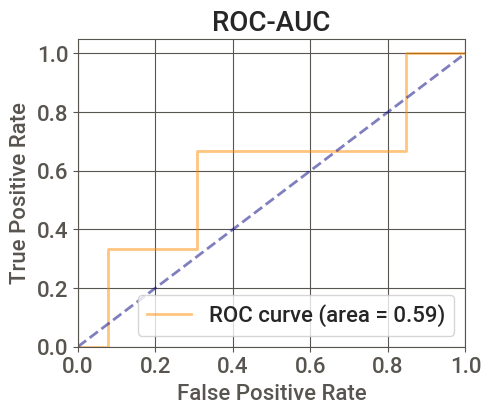

In [639]:
cbc_g = CatBoostClassifier(iterations=1000,
                         loss_function='Logloss',
                         eval_metric='AUC',
                         random_seed=seed,
                         learning_rate=0.1,
                         l2_leaf_reg=5,
                         early_stopping_rounds=20,
                         depth=7
                         )
cbc_g.fit(train_pool_g)

eval_pool = Pool(xy_g['x_valid'], xy_g['y_valid'],cat_features=columns_c)
curve = get_roc_curve(cbc_g, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 4))
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-AUC', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [641]:
y_predict = cbc_g.predict(xy_g['x_valid'])
print(classification_report(y_predict, xy_g['y_valid']))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       0.00      0.00      0.00         0

    accuracy                           0.95        55
   macro avg       0.50      0.47      0.49        55
weighted avg       1.00      0.95      0.97        55



### Вывод: <a class="anchor" id="section_3_9"></a>

Лушей моделью для Apparel и  MarketPlace оказалась CatBoostClassifier, обученная на общей выборке. Модели обученные на соответсвующих выборках показали худший результат

Данных в Gifts оказалось мало для обучения. Поэтому она имеет 0 точность.

В итоге, выберем модель cbc_m.

## Тестирование модели <a class="anchor" id="chapter4"></a>

Проведем тестирование моделей и сравним их с dummy моделями

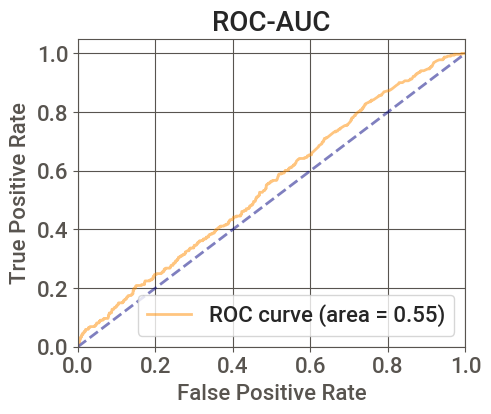

In [642]:
eval_pool = Pool(xy_a['x_test'], xy_a['y_test'],cat_features=columns_c)
curve = get_roc_curve(cbc, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 4))
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-AUC', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [645]:
y_predict = cbc.predict(xy_a['x_test'])
print(classification_report(y_predict, xy_a['y_test']))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4882
           1       0.05      0.16      0.08       109

    accuracy                           0.92      4991
   macro avg       0.52      0.55      0.52      4991
weighted avg       0.96      0.92      0.94      4991



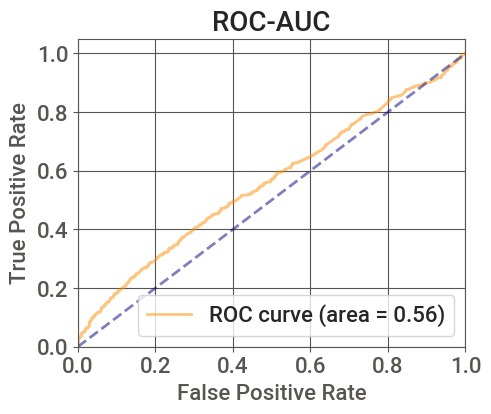

In [648]:
eval_pool = Pool(xy_m['x_test'], xy_m['y_test'],cat_features=columns_c)
curve = get_roc_curve(cbc, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 4))
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-AUC', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [651]:
y_predict = cbc.predict(xy_m['x_test'])
print(classification_report(y_predict, xy_m['y_test']))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3562
           1       0.04      0.46      0.07        50

    accuracy                           0.83      3612
   macro avg       0.51      0.65      0.49      3612
weighted avg       0.98      0.83      0.90      3612



Построим dummy модели

In [654]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(xy_m['x_train'], xy_m['y_train'])
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(xy_m['x_train'])
y_predict = dummy_clf.predict(xy_m['x_test'])
print(classification_report(y_predict, xy_m['y_test']))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3612
           1       0.00      0.00      0.00         0

    accuracy                           0.83      3612
   macro avg       0.50      0.42      0.45      3612
weighted avg       1.00      0.83      0.91      3612



In [656]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(xy_a['x_train'], xy_a['y_train'])
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(xy_a['x_train'])
y_predict = dummy_clf.predict(xy_a['x_test'])
print(classification_report(y_predict, xy_a['y_test']))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      4991
           1       0.00      0.00      0.00         0

    accuracy                           0.94      4991
   macro avg       0.50      0.47      0.48      4991
weighted avg       1.00      0.94      0.97      4991



## Заключение

Модель градиентного бустинга показала слабый результат: roc-auc = 0,56 на тестовой выборке. Precision для обоих выборок около 0.05, что говорит о низкой предсказательной силе модели. Для магазина Gifts  не удалось создать адекватную модель.

**Итоговый вывод:**

- В первом части были изучены и подготовлены данные, проведено исследование признаков и их первичная обработка
- Во втрой части была осуществленна подготовка признаков, создание целевого признака. После проверки корреляции были убраны взаимосвязанные признаки. 
- В третьей части выборка была разделена на обучающую, валидационную и тестовую
- Далее были обученные модели для соответсвующих выборок
- В последней части был проведен тест модели CatBoost, он показал низкую точность.